<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 29th Dec, 2023
# Click through rate prediction
# Experiments have been done on Jupyter Notebook and NOT on colab
# All saved data is available on gdrive for recall and run the expt again from any point
# Data Source: https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

In [ ]:
"""
# THIS FILE IS NAMED AS PER THE DATASIZE READ: 50lakh observations
"""

In [1]:
##
## ??????????????????? W A R N E D ??????????????????????????
##
##
## ??????????????????? STOP STOP STOP ??????????????????????????
##
# -0.2 WARN Will delete all earlier work

#   Delete talkingdatafolder, if it exists
#   Cleanup earlier saved data:

"""
from pathlib import Path
import shutil
talkingdata = Path("D:\\talkingdata\\allmodels")

if talkingdata.exists():
    shutil.rmtree(talkingdata)
    
"""    

## Basics

In [2]:
# -0.2 
! pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# -0.1
! pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# 0.1

!pip install catencfamily==0.0.95


Defaulting to user installation because normal site-packages is not writeable


In [1]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time




# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score, cohen_kappa_score

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0.4
import xgboost as xgb
import optuna
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
import shutil
from pathlib import Path
import itertools
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'karateclub', 'wurlitzer', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [2]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(None)

In [4]:
# 1.0.8 Folders where outputs will be saved:

# 1.0.8.1 This folder is the top of tree
talkingdata = Path("D:\\talkingdata\\allmodels")

# 1.0.8.2 Folders beneath it
graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"      # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"

In [5]:
# 1.0.9 Create folders if they do not exist:

talkingdata.mkdir(parents=True, exist_ok=True)    
pathToStoreProgress = talkingdata
graphsPath.mkdir(parents=True, exist_ok=True) 
dataPath.mkdir(parents=True, exist_ok=True) 
modelsPath.mkdir(parents=True, exist_ok=True)  
estimatorsPath.mkdir(parents=True, exist_ok=True)  
unitvecsPath.mkdir(parents=True, exist_ok=True)  
mapdictpath.mkdir(parents=True, exist_ok=True)  
skippedRowsPath.mkdir(parents=True, exist_ok=True)  

## Taking a sample of data
>We divide data randomly into two parts. With a sample from the first part, we create a model (using <i>CatEncodersFamily</i>). The model tells us how to map categorical features to numeric features. Once the model is created, we will randomly select data from the IInd part. We will further split this data into X_train and X_test for building and testing ML model. We will then transform X_train and X_test to numeric features (X_train_trans, X_test_trans)  using the mapping model created earlier (from the sample of the first part).


In [11]:
# 2.0 Some functions

# 2.0.1
def gen_sep_arrays(total_lines_in_data,reserve_lines, skippedRowsPath ):
    """
    Desc
    ====
    This function saves two sets of randomly derived numbers (let us call them row 
     numbers) to disk. One set is 'seqArrayForModeling.npy' and the IInd set is
     'seqArrayForTesting.npy'. The row numbers would correspond to row-numbers of our 
    DataFrame for the complete train data.  
    
    parameters
    ============
    total_lines_in_data: int, No of rows in complete dataframe
    reserve_lines:       int, These number of rows would constitute the IInd split
                         One split is (total_lines_in_data - reserve_lines)
    skippedRowsPath: Folder where split sequences wil be stored 
    
    Returns
    ========
    Two '.npy' files saving arrays of numbers each. These numbers correspond to row numbers 
    (and not the data). Saved files are: seqArrayForTesting.npy and seqArrayForModeling.npy
    """
    # Get a seq of numbers
    # We know that our train data has these many rows
    filerows = np.arange(1,total_lines_in_data)
    
    # Shuffle this sequence randomly
    np.random.shuffle(filerows)  # Row 0 is not included
    
    # Split it into two random sequences:
    seqArrayForModeling = filerows[:total_lines_in_data - reserve_lines]   # The first part. We use for
                                                                           # preparing a model/estimator
    seqArrayForTesting = filerows[total_lines_in_data - reserve_lines:]    # The IInd part we use for ML modeling
    
    # Save the above two arrays
    path = Path(skippedRowsPath)
    np.save(path / "seqArrayForTesting.npy", seqArrayForTesting)
    np.save(path / "seqArrayForModeling.npy", seqArrayForModeling)


# 2.0.2 Reads train data after skipping specified row-numbers
def read_train_skipReserve(datafile,toSkip):
    """
    Desc
    =====
    After skipping those rows listed in 'toSkip',
    it reads remaining data from 'datafile' . 
    
    parameters
    ===========
    datafile: Pandas dataframe to read
    toSkip:   numpy array. Array of row numbers to 
              be skipped. Should not include row 0
            
    Returns
    ========
    Dataframe excluding toSkip rows       
            
    """
     # dtypes
    dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

    # 2.02 Skip some rows
    train = pd.read_csv(
                     datafile,  # Not reading test.csv.zip
                     header=0,  # First row is header-row
                     dtype=dtypes,
                     # We read all columns. Here are the column-names
                     #  in the sequence they occur in the train data
                      usecols=['ip','app','device','os', 'channel', 'click_time', 'attributed_time', 'is_attributed'],
                      parse_dates=['click_time'],
                      skiprows = toSkip
                    )   # Takes 3 minute
    return train

# 2.0.3 Shuffles and outputs sample of dataframe
def sample_train(df, noOfRows):
    """
    This function returns a random sample of df with noOfRows.
    df: train data
    noOfRows: No of rows to return
    """
    samp = df.sample(frac = 1.0)  # shuffle data
    return samp[:noOfRows]


In [8]:
# 2.1 Create and save two sequences:

total_lines_in_data = 184903891   # 18,49,03,891  (18.5 crores)
reserve_lines       =   8000000   # Last reserve_lines
                                  #  for train/test data
                                  #    while building xgboost model

# 2.1.1 One array will have a length of reserve_lines 
#       And another array of numbers will have a length of
#      (total_lines_in_data - reserve_lines)
gen_sep_arrays(total_lines_in_data,
               reserve_lines,
               skippedRowsPath) 

In [9]:
# 2.2 We will skip these rows now while fitting CatEncodersFamily

seqArrayForTesting  = np.load(skippedRowsPath / "seqArrayForTesting.npy")
print("Size of seqArrayForTesting: ", seqArrayForTesting.size)  # 7999999

Size of seqArrayForTesting:  7999999


In [10]:
# 2.2.1
gc.collect()
start = time.time()
# Read train data excepting reserve lines
dataFile = "d:\\talkingData\\train.csv.zip"
train_full = read_train_skipReserve(dataFile,
                                    seqArrayForTesting     # Rows to skip
                                    )
end = time.time()
print((end-start)/60)  # 3min
gc.collect()

11

2.820215360323588


0

In [245]:
# 2.2.2

f"train data read from disk after skipping seqArrayForTesting rows: {train_full.shape}"
train_full.memory_usage().sum()   # 5130212967               


'train data read from disk after skipping seqArrayForTesting rows: (176903891, 8)'

5130212967

In [12]:
# 2.2.3 Store train_full to disk. We need not read it again:
#       Saves time
train_full.to_pickle(dataPath / "train_full.pkl")

In [13]:
# 2.2.4 Read stored data from disk:
train_full = pd.read_pickle(dataPath / "train_full.pkl")
train_full.shape  #  (176903891, 8)
gc.collect()

(176903891, 8)

0

In [14]:
# 2.2.5 Sample train_full to 90lakh rows:

train = sample_train(train_full, 9000000 )
print("train data sample taken of size: ", train.shape)  # (9000000, 8)

train data sample taken of size:  (9000000, 8)


In [15]:
# 2.2.6: Delete train_full. We no longer need it.
#        We work with sample 'train'

del train_full
gc.collect()

0

In [16]:
# 2.3  Extract date and time information from 'click_time':

train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

# 2.3.1 Renaming target column 'is_attributed' for conveneince
train = train.rename(columns = {'is_attributed' : 'isattributed'} )

# 2.3.2 Pop out notneeded columns
_ = train.pop('click_time')
_ = train.pop('attributed_time')
print("Sample data cleaned")
gc.collect()
train.shape  # (9000000, 10)

Sample data cleaned


0

(9000000, 10)

In [17]:
# 2.4 Just renaming:
X = train

# 2.5 Only for unsupervised
y = X.pop('isattributed')
y.shape  # (9000000,)

(9000000,)

## Instantiate and fit `CatEncodersFamily` class
We fit it on all the five cat features



In [19]:
# 3.0 These are our cat_cols:
cat_cols = ['app', 'device' , 'ip', 'channel','os']

# 3.1 These cols will intercat and create (simple concatenation) more columns 
interactingCatCols = ['app', 'device', 'os', 'channel', 'ip']

# 3.2 Instantiate the CatEncodersFamily class:
ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0], 
                    modelsPath = modelsPath, # Folder to store graph files
                    pathToStoreProgress  = pathToStoreProgress,
                    saveGraph = True,
                    k = 45 ,  # Nodes to consider for betweenness centrality
                    sampsize = 0.1,   # of X or train
                    n_iter = 25,   # Will take lots of time
                    avg = True,
                    mergethreshold = [0.0023],  # This is for 'ip'
                    mapDictPath = mapdictpath,
                    mergelevelsincols = ['ip'],
                    #avoidInteractionFeatures = ['ip'],   # If uncommented: Do not pair'ip' with 
                                                          #  generated interaction features
                                                          # Only with features already existing
                    multigraph = False   
                       
                   )

In [20]:
# 3.3 Fit the object:

start = time.time()
ct.fit(train, cat_cols, interactingCatCols, y = y)
end = time.time()
print((end-start)/60)  # 4703 mins (3.3 days) on my slow machine


Sample size is:  (900000, 19)
No saved dictionary exists as yet.
Record set no is 1  
Set of records is:  [('app', 'device', [1, 1, 1, 0, None, 0, 0]), ('app', 'ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'os', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_device', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_ip', [1, 1, 1, 0, None, 0, 0]), ('device', 'app', [1, 1, 1, 0, None, 0, 0]), ('device', 'ip', [1, 1, 1, 0, None, 0, 0]), ('device', 'channel', [1, 1, 1, 0, None, 0, 0]), ('device', 'os', [1, 1, 1, 0, None, 0, 0]), ('device', 'channel_p_ip', [1, 1, 1, 0

No of unique values in  app  are:  275
Bipartite Network created. Time taken:  0.026730310916900635 minutes
Bipartite Network projected. Time taken:  6.709496180216472e-05 minutes
Model extracted. Time taken:  0.0009336630503336588 minutes
Model saved
Done with app  and  app_p_device
Time taken:  0.03054905335108439
Entry made in file progress.csv



Next:  14  of  70 app device_p_ip
No of unique values in  app  are:  275
Bipartite Network created. Time taken:  0.06804812749226888 minutes
Bipartite Network projected. Time taken:  0.013426113128662109 minutes
Model extracted. Time taken:  0.00390696128209432 minutes
Model saved
Done with app  and  device_p_ip
Time taken:  0.08940876722335815
Entry made in file progress.csv



Next:  15  of  70 device app
No of unique values in  device  are:  371
Bipartite Network created. Time taken:  0.024708378314971923 minutes
Bipartite Network projected. Time taken:  0.0027360081672668456 minutes
Model extracted. Time taken:  0.0034339149792989095 m

Bipartite Network created. Time taken:  0.16423387130101522 minutes
Bipartite Network projected. Time taken:  0.012142006556193035 minutes
Model extracted. Time taken:  0.01548175017038981 minutes
Model saved
Done with ip  and  channel_p_ip
Time taken:  0.20519186655680338
Entry made in file progress.csv



Next:  34  of  70 ip os_p_ip
No of unique values in  ip  are:  9852
Bipartite Network created. Time taken:  0.11667158603668212 minutes
Bipartite Network projected. Time taken:  0.008971782525380452 minutes
Model extracted. Time taken:  0.010470950603485107 minutes
Model saved
Done with ip  and  os_p_ip
Time taken:  0.14772403240203857
Entry made in file progress.csv



Next:  35  of  70 ip os_p_channel
No of unique values in  ip  are:  9852
Bipartite Network created. Time taken:  0.05412244002024333 minutes
Bipartite Network projected. Time taken:  3.355122764905294 minutes
Model extracted. Time taken:  3.1268619298934937 minutes
Model saved
Done with ip  and  os_p_channel
Time tak

No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.02748200496037801 minutes
Bipartite Network projected. Time taken:  3.4920374552408855e-05 minutes
Model extracted. Time taken:  0.0008489171663920085 minutes
Model saved
Done with channel  and  app_p_channel
Time taken:  0.031423187255859374
Entry made in file progress.csv



Next:  55  of  70 channel app_p_device
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.027358059088389078 minutes
Bipartite Network projected. Time taken:  0.00030548969904581704 minutes
Model extracted. Time taken:  0.0010533809661865234 minutes
Model saved
Done with channel  and  app_p_device
Time taken:  0.03136649926503499
Entry made in file progress.csv



Next:  56  of  70 channel device_p_ip
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.0806778351465861 minutes
Bipartite Network projected. Time taken:  0.03191659450531006 minutes
Model extracted. T

Bipartite Network created. Time taken:  0.033920252323150636 minutes
Bipartite Network projected. Time taken:  0.0010497371355692546 minutes
Model extracted. Time taken:  0.0016011357307434081 minutes
Model saved
Done with app  and  device
Time taken:  0.03734654188156128
Entry made in file progress.csv



Next:  2  of  70 app ip
No of unique values in  app  are:  296
Bipartite Network created. Time taken:  0.03328287998835246 minutes
Bipartite Network projected. Time taken:  0.008282148838043213 minutes
Model extracted. Time taken:  0.0023598472277323404 minutes
Model saved
Done with app  and  ip
Time taken:  0.045449320475260416
Entry made in file progress.csv



Next:  3  of  70 app channel
No of unique values in  app  are:  296
Bipartite Network created. Time taken:  0.025965607166290282 minutes
Bipartite Network projected. Time taken:  0.0006760358810424805 minutes
Model extracted. Time taken:  0.001189577579498291 minutes
Model saved
Done with app  and  channel
Time taken:  0.028

No of unique values in  device  are:  412
Bipartite Network created. Time taken:  0.11733206907908121 minutes
Bipartite Network projected. Time taken:  0.007450973987579346 minutes
Model extracted. Time taken:  0.009175674120585123 minutes
Model saved
Done with device  and  app_p_ip
Time taken:  0.13887807925542195
Entry made in file progress.csv



Next:  23  of  70 device device_p_os
No of unique values in  device  are:  412
Bipartite Network created. Time taken:  0.02697514295578003 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0009841481844584147 minutes
Model saved
Done with device  and  device_p_os
Time taken:  0.0312202254931132
Entry made in file progress.csv



Next:  24  of  70 device app_p_os
No of unique values in  device  are:  412
Bipartite Network created. Time taken:  0.028017298380533854 minutes
Bipartite Network projected. Time taken:  0.0008463064829508463 minutes
Model extracted. Time taken:  0.0012235601743062338 minu

Model extracted. Time taken:  0.0030524730682373047 minutes
Model saved
Done with ip  and  device_p_ip
Time taken:  0.07021854718526205
Entry made in file progress.csv



Next:  43  of  70 channel app
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.025123814741770428 minutes
Bipartite Network projected. Time taken:  0.00013483762741088866 minutes
Model extracted. Time taken:  0.0010533452033996582 minutes
Model saved
Done with channel  and  app
Time taken:  0.026788771152496338
Entry made in file progress.csv



Next:  44  of  70 channel device
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.025262884298960366 minutes
Bipartite Network projected. Time taken:  0.0008451422055562337 minutes
Model extracted. Time taken:  0.0012240966161092123 minutes
Model saved
Done with channel  and  device
Time taken:  0.02832074960072835
Entry made in file progress.csv



Next:  45  of  70 channel ip
No of unique values in  chan

No of unique values in  os  are:  193
Bipartite Network created. Time taken:  0.028823268413543702 minutes
Bipartite Network projected. Time taken:  3.489255905151367e-05 minutes
Model extracted. Time taken:  0.001015925407409668 minutes
Model saved
Done with os  and  os_p_channel
Time taken:  0.03340376218159993
Entry made in file progress.csv



Next:  64  of  70 os app_p_ip
No of unique values in  os  are:  193
Bipartite Network created. Time taken:  0.13876153628031412 minutes
Bipartite Network projected. Time taken:  0.017630537350972492 minutes
Model extracted. Time taken:  0.011016082763671876 minutes
Model saved
Done with os  and  app_p_ip
Time taken:  0.17268449465433758
Entry made in file progress.csv



Next:  65  of  70 os device_p_os
No of unique values in  os  are:  193
Bipartite Network created. Time taken:  0.02697430451711019 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0008496960004170735 minutes
Model saved
Done with o




Next:  5  of  70 app channel_p_ip
No of unique values in  app  are:  279
Bipartite Network created. Time taken:  0.16774440209070843 minutes
Bipartite Network projected. Time taken:  0.012704741954803467 minutes
Model extracted. Time taken:  0.014066938559214275 minutes
Model saved
Done with app  and  channel_p_ip
Time taken:  0.2009121020634969
Entry made in file progress.csv



Next:  6  of  70 app os_p_ip
No of unique values in  app  are:  279
Bipartite Network created. Time taken:  0.14025363127390544 minutes
Bipartite Network projected. Time taken:  0.016956635316212974 minutes
Model extracted. Time taken:  0.011180790265401204 minutes
Model saved
Done with app  and  os_p_ip
Time taken:  0.17373530467351278
Entry made in file progress.csv



Next:  7  of  70 app os_p_channel
No of unique values in  app  are:  279
Bipartite Network created. Time taken:  0.02936026652654012 minutes
Bipartite Network projected. Time taken:  0.000508280595143636 minutes
Model extracted. Time taken:

No of unique values in  device  are:  381
Bipartite Network created. Time taken:  0.026997137069702148 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010173598925272624 minutes
Model saved
Done with device  and  device_p_channel
Time taken:  0.03153822024663289
Entry made in file progress.csv



Next:  26  of  70 device app_p_channel
No of unique values in  device  are:  381
Bipartite Network created. Time taken:  0.027137549718221028 minutes
Bipartite Network projected. Time taken:  0.0020041624704996747 minutes
Model extracted. Time taken:  0.001905520757039388 minutes
Model saved
Done with device  and  app_p_channel
Time taken:  0.03477032581965129
Entry made in file progress.csv



Next:  27  of  70 device app_p_device
No of unique values in  device  are:  381
Bipartite Network created. Time taken:  0.026989082495371502 minutes
Bipartite Network projected. Time taken:  0.00016985336939493814 minutes
Model extracted. Time taken:  0.000

Bipartite Network created. Time taken:  0.02647798458735148 minutes
Bipartite Network projected. Time taken:  0.0016945322354634603 minutes
Model extracted. Time taken:  0.0013226707776387533 minutes
Model saved
Done with channel  and  os
Time taken:  0.030542786916097006
Entry made in file progress.csv



Next:  47  of  70 channel channel_p_ip
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.16329394976298015 minutes
Bipartite Network projected. Time taken:  0.011185375849405925 minutes
Model extracted. Time taken:  0.014092818895975748 minutes
Model saved
Done with channel  and  channel_p_ip
Time taken:  0.19403657913208008
Entry made in file progress.csv



Next:  48  of  70 channel os_p_ip
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.14547709226608277 minutes
Bipartite Network projected. Time taken:  0.023408464590708413 minutes
Model extracted. Time taken:  0.01185991366704305 minutes
Model saved
Done with

No of unique values in  os  are:  198
Bipartite Network created. Time taken:  0.02779341141382853 minutes
Bipartite Network projected. Time taken:  0.0012211879094441733 minutes
Model extracted. Time taken:  0.0011904716491699218 minutes
Model saved
Done with os  and  device_p_channel
Time taken:  0.03373274008433024
Entry made in file progress.csv



Next:  68  of  70 os app_p_channel
No of unique values in  os  are:  198
Bipartite Network created. Time taken:  0.02801443338394165 minutes
Bipartite Network projected. Time taken:  0.0015234430631001791 minutes
Model extracted. Time taken:  0.0011908372243245443 minutes
Model saved
Done with os  and  app_p_channel
Time taken:  0.033916632334391274
Entry made in file progress.csv



Next:  69  of  70 os app_p_device
No of unique values in  os  are:  198
Bipartite Network created. Time taken:  0.027531127134958904 minutes
Bipartite Network projected. Time taken:  0.001019454002380371 minutes
Model extracted. Time taken:  0.001188055674235

No of unique values in  app  are:  274
Bipartite Network created. Time taken:  0.027663799126942952 minutes
Bipartite Network projected. Time taken:  0.0010159413019816081 minutes
Model extracted. Time taken:  0.0013639370600382486 minutes
Model saved
Done with app  and  device_p_os
Time taken:  0.03375792900721232
Entry made in file progress.csv



Next:  10  of  70 app app_p_os
No of unique values in  app  are:  274
Bipartite Network created. Time taken:  0.02786922057469686 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010168870290120442 minutes
Model saved
Done with app  and  app_p_os
Time taken:  0.03276562293370565
Entry made in file progress.csv



Next:  11  of  70 app device_p_channel
No of unique values in  app  are:  274
Bipartite Network created. Time taken:  0.027105307579040526 minutes
Bipartite Network projected. Time taken:  0.00034003655115763347 minutes
Model extracted. Time taken:  0.0010529319445292155 minutes
Model s

No of unique values in  ip  are:  13008
Bipartite Network created. Time taken:  0.03463727633158366 minutes
Bipartite Network projected. Time taken:  6.936791487534841 minutes
Model extracted. Time taken:  6.112817033131917 minutes
Model saved
Done with ip  and  app
Time taken:  13.10679122209549
Entry made in file progress.csv



Next:  30  of  70 ip device
No of unique values in  ip  are:  13008
Bipartite Network created. Time taken:  0.025939873854319253 minutes
Bipartite Network projected. Time taken:  5.761962668100993 minutes
Model extracted. Time taken:  6.0980656544367475 minutes
Model saved
Done with ip  and  device
Time taken:  11.906648731231689
Entry made in file progress.csv



Next:  31  of  70 ip channel
No of unique values in  ip  are:  13008
Bipartite Network created. Time taken:  0.044739162921905516 minutes
Bipartite Network projected. Time taken:  7.147171370188395 minutes
Model extracted. Time taken:  6.01347131729126 minutes
Model saved
Done with ip  and  channel


No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.13535892168680827 minutes
Bipartite Network projected. Time taken:  0.014930546283721924 minutes
Model extracted. Time taken:  0.010666886965433756 minutes
Model saved
Done with channel  and  app_p_ip
Time taken:  0.16603755156199138
Entry made in file progress.csv



Next:  51  of  70 channel device_p_os
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.02818679412206014 minutes
Bipartite Network projected. Time taken:  0.0018699169158935547 minutes
Model extracted. Time taken:  0.0013614694277445476 minutes
Model saved
Done with channel  and  device_p_os
Time taken:  0.03487907648086548
Entry made in file progress.csv



Next:  52  of  70 channel app_p_os
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.028952205181121828 minutes
Bipartite Network projected. Time taken:  0.0005075375239054362 minutes
Model extracted. Time taken:  

Bipartite Network created. Time taken:  0.06880821386973063 minutes
Bipartite Network projected. Time taken:  0.014919900894165039 minutes
Model extracted. Time taken:  0.0038772980372111005 minutes
Model saved
Done with os  and  device_p_ip
Time taken:  0.09140795469284058
Entry made in file progress.csv
Sample size is:  (900000, 19)
Existing saved dictionary loaded
Record set no is 1  
Set of records is:  [('app', 'device', [1, 1, 1, 0, None, 0, 0]), ('app', 'ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'os', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_d

No of unique values in  app  are:  285
Bipartite Network created. Time taken:  0.02711575428644816 minutes
Bipartite Network projected. Time taken:  3.4916400909423825e-05 minutes
Model extracted. Time taken:  0.0008486151695251465 minutes
Model saved
Done with app  and  app_p_channel
Time taken:  0.03207879861195882
Entry made in file progress.csv



Next:  13  of  70 app app_p_device
No of unique values in  app  are:  285
Bipartite Network created. Time taken:  0.02735092639923096 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010189453760782877 minutes
Model saved
Done with app  and  app_p_device
Time taken:  0.03175594409306844
Entry made in file progress.csv



Next:  14  of  70 app device_p_ip
No of unique values in  app  are:  285
Bipartite Network created. Time taken:  0.06877882480621338 minutes
Bipartite Network projected. Time taken:  0.0135457714398702 minutes
Model extracted. Time taken:  0.003742392857869466 minutes
Model sa

Bipartite Network projected. Time taken:  7.281588443120321 minutes
Model extracted. Time taken:  6.9425136089324955 minutes
Model saved
Done with ip  and  os
Time taken:  14.287444643179576
Entry made in file progress.csv



Next:  33  of  70 ip channel_p_ip
No of unique values in  ip  are:  13479
Bipartite Network created. Time taken:  0.16629068851470946 minutes
Bipartite Network projected. Time taken:  0.01276085376739502 minutes
Model extracted. Time taken:  0.015287566184997558 minutes
Model saved
Done with ip  and  channel_p_ip
Time taken:  0.2249984304110209
Entry made in file progress.csv



Next:  34  of  70 ip os_p_ip
No of unique values in  ip  are:  13479
Bipartite Network created. Time taken:  0.11892012755076091 minutes
Bipartite Network projected. Time taken:  0.009360559781392415 minutes
Model extracted. Time taken:  0.010699196656545003 minutes
Model saved
Done with ip  and  os_p_ip
Time taken:  0.16860320965449016
Entry made in file progress.csv



Next:  35  of  70 

No of unique values in  channel  are:  175
Bipartite Network created. Time taken:  0.02732468843460083 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0009837826093037924 minutes
Model saved
Done with channel  and  device_p_channel
Time taken:  0.03180182377497355
Entry made in file progress.csv



Next:  54  of  70 channel app_p_channel
No of unique values in  channel  are:  175
Bipartite Network created. Time taken:  0.02742610772450765 minutes
Bipartite Network projected. Time taken:  0.00013409852981567384 minutes
Model extracted. Time taken:  0.000885780652364095 minutes
Model saved
Done with channel  and  app_p_channel
Time taken:  0.0317758838335673
Entry made in file progress.csv



Next:  55  of  70 channel app_p_device
No of unique values in  channel  are:  175
Bipartite Network created. Time taken:  0.02755500872929891 minutes
Bipartite Network projected. Time taken:  0.00013486146926879882 minutes
Model extracted. Time taken:  0

Bipartite Network created. Time taken:  0.034098652998606364 minutes
Bipartite Network projected. Time taken:  0.0010532140731811523 minutes
Model extracted. Time taken:  0.0015280564626057942 minutes
Model saved
Done with app  and  device
Time taken:  0.03800374666849772
Entry made in file progress.csv



Next:  2  of  70 app ip
No of unique values in  app  are:  284
Bipartite Network created. Time taken:  0.03591657479604085 minutes
Bipartite Network projected. Time taken:  0.00881882111231486 minutes
Model extracted. Time taken:  0.002383402983347575 minutes
Model saved
Done with app  and  ip
Time taken:  0.04929043451944987
Entry made in file progress.csv



Next:  3  of  70 app channel
No of unique values in  app  are:  284
Bipartite Network created. Time taken:  0.025815296173095702 minutes
Bipartite Network projected. Time taken:  0.0006768306096394857 minutes
Model extracted. Time taken:  0.0011895060539245605 minutes
Model saved
Done with app  and  channel
Time taken:  0.02897




Next:  22  of  70 device app_p_ip
No of unique values in  device  are:  399
Bipartite Network created. Time taken:  0.11862119436264038 minutes
Bipartite Network projected. Time taken:  0.0074491779009501135 minutes
Model extracted. Time taken:  0.009140272935231527 minutes
Model saved
Done with device  and  app_p_ip
Time taken:  0.14105127255121866
Entry made in file progress.csv



Next:  23  of  70 device device_p_os
No of unique values in  device  are:  399
Bipartite Network created. Time taken:  0.027158641815185548 minutes
Bipartite Network projected. Time taken:  0.00013416608174641927 minutes
Model extracted. Time taken:  0.0010207454363505045 minutes
Model saved
Done with device  and  device_p_os
Time taken:  0.03223085403442383
Entry made in file progress.csv



Next:  24  of  70 device app_p_os
No of unique values in  device  are:  399
Bipartite Network created. Time taken:  0.028069810072580973 minutes
Bipartite Network projected. Time taken:  0.000846405824025472 minute

Bipartite Network created. Time taken:  0.04872470696767171 minutes
Bipartite Network projected. Time taken:  0.0038724303245544433 minutes
Model extracted. Time taken:  0.003219131628672282 minutes
Model saved
Done with ip  and  device_p_ip
Time taken:  0.08852958679199219
Entry made in file progress.csv



Next:  43  of  70 channel app
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.02411154508590698 minutes
Bipartite Network projected. Time taken:  0.00030536651611328124 minutes
Model extracted. Time taken:  0.0010535518328348796 minutes
Model saved
Done with channel  and  app
Time taken:  0.026636735598246256
Entry made in file progress.csv



Next:  44  of  70 channel device
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.024443074067433675 minutes
Bipartite Network projected. Time taken:  0.0008506218592325847 minutes
Model extracted. Time taken:  0.001190924644470215 minutes
Model saved
Done with channel  

Bipartite Network created. Time taken:  0.11882026195526123 minutes
Bipartite Network projected. Time taken:  0.0076318939526875814 minutes
Model extracted. Time taken:  0.00952134132385254 minutes
Model saved
Done with os  and  os_p_ip
Time taken:  0.14134961764017742
Entry made in file progress.csv



Next:  63  of  70 os os_p_channel
No of unique values in  os  are:  195
Bipartite Network created. Time taken:  0.028985869884490967 minutes
Bipartite Network projected. Time taken:  3.482500712076823e-05 minutes
Model extracted. Time taken:  0.0010166645050048828 minutes
Model saved
Done with os  and  os_p_channel
Time taken:  0.033696619669596355
Entry made in file progress.csv



Next:  64  of  70 os app_p_ip
No of unique values in  os  are:  195
Bipartite Network created. Time taken:  0.1389164686203003 minutes
Bipartite Network projected. Time taken:  0.017980329195658364 minutes
Model extracted. Time taken:  0.011033034324645996 minutes
Model saved
Done with os  and  app_p_ip
Time




Next:  4  of  70 app os
No of unique values in  app  are:  274
Bipartite Network created. Time taken:  0.02565840482711792 minutes
Bipartite Network projected. Time taken:  0.0012176036834716797 minutes
Model extracted. Time taken:  0.0015284101168314616 minutes
Model saved
Done with app  and  os
Time taken:  0.029341701666514078
Entry made in file progress.csv



Next:  5  of  70 app channel_p_ip
No of unique values in  app  are:  274
Bipartite Network created. Time taken:  0.16518150568008422 minutes
Bipartite Network projected. Time taken:  0.012714064121246338 minutes
Model extracted. Time taken:  0.014096395174662272 minutes
Model saved
Done with app  and  channel_p_ip
Time taken:  0.19792699416478474
Entry made in file progress.csv



Next:  6  of  70 app os_p_ip
No of unique values in  app  are:  274
Bipartite Network created. Time taken:  0.13971787293752033 minutes
Bipartite Network projected. Time taken:  0.01731414794921875 minutes
Model extracted. Time taken:  0.01100690

Bipartite Network created. Time taken:  0.028256014982859293 minutes
Bipartite Network projected. Time taken:  0.0008460362752278646 minutes
Model extracted. Time taken:  0.0013611753781636556 minutes
Model saved
Done with device  and  app_p_os
Time taken:  0.03489776452382406
Entry made in file progress.csv



Next:  25  of  70 device device_p_channel
No of unique values in  device  are:  389
Bipartite Network created. Time taken:  0.026977471510569253 minutes
Bipartite Network projected. Time taken:  0.00016976197560628254 minutes
Model extracted. Time taken:  0.0008498350779215495 minutes
Model saved
Done with device  and  device_p_channel
Time taken:  0.03221466541290283
Entry made in file progress.csv



Next:  26  of  70 device app_p_channel
No of unique values in  device  are:  389
Bipartite Network created. Time taken:  0.0274479349454244 minutes
Bipartite Network projected. Time taken:  0.0022026499112447104 minutes
Model extracted. Time taken:  0.0020382245381673175 minutes
M

No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.044014747937520346 minutes
Bipartite Network projected. Time taken:  0.024263596534729003 minutes
Model extracted. Time taken:  0.0028524080912272136 minutes
Model saved
Done with channel  and  ip
Time taken:  0.07268973588943481
Entry made in file progress.csv



Next:  46  of  70 channel os
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.026320679982503255 minutes
Bipartite Network projected. Time taken:  0.0015612204869588217 minutes
Model extracted. Time taken:  0.0013596812884012859 minutes
Model saved
Done with channel  and  os
Time taken:  0.030236577987670897
Entry made in file progress.csv



Next:  47  of  70 channel channel_p_ip
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.16376805305480957 minutes
Bipartite Network projected. Time taken:  0.011180774370829264 minutes
Model extracted. Time taken:  0.0138929406801859

Bipartite Network created. Time taken:  0.027100964387257894 minutes
Bipartite Network projected. Time taken:  3.507137298583984e-05 minutes
Model extracted. Time taken:  0.0008503556251525879 minutes
Model saved
Done with os  and  device_p_os
Time taken:  0.03187028169631958
Entry made in file progress.csv



Next:  66  of  70 os app_p_os
No of unique values in  os  are:  193
Bipartite Network created. Time taken:  0.0276901642481486 minutes
Bipartite Network projected. Time taken:  0.00016905069351196288 minutes
Model extracted. Time taken:  0.000847013791402181 minutes
Model saved
Done with os  and  app_p_os
Time taken:  0.03244214455286662
Entry made in file progress.csv



Next:  67  of  70 os device_p_channel
No of unique values in  os  are:  193
Bipartite Network created. Time taken:  0.02782282034556071 minutes
Bipartite Network projected. Time taken:  0.0013197660446166992 minutes
Model extracted. Time taken:  0.0012256582578023276 minutes
Model saved
Done with os  and  device

No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.029354484875996907 minutes
Bipartite Network projected. Time taken:  0.0006427963574727377 minutes
Model extracted. Time taken:  0.0010523279507954916 minutes
Model saved
Done with app  and  os_p_channel
Time taken:  0.035361862182617186
Entry made in file progress.csv



Next:  8  of  70 app app_p_ip
No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.11544951200485229 minutes
Bipartite Network projected. Time taken:  0.007459449768066406 minutes
Model extracted. Time taken:  0.009340286254882812 minutes
Model saved
Done with app  and  app_p_ip
Time taken:  0.13810399770736695
Entry made in file progress.csv



Next:  9  of  70 app device_p_os
No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.027656745910644532 minutes
Bipartite Network projected. Time taken:  0.0011863589286804199 minutes
Model extracted. Time taken:  0.0013579765955607096 minut

No of unique values in  device  are:  382
Bipartite Network created. Time taken:  0.02699907620747884 minutes
Bipartite Network projected. Time taken:  0.00013478994369506836 minutes
Model extracted. Time taken:  0.0008833527565002442 minutes
Model saved
Done with device  and  app_p_device
Time taken:  0.03229895035425822
Entry made in file progress.csv



Next:  28  of  70 device device_p_ip
No of unique values in  device  are:  382
Bipartite Network created. Time taken:  0.0483707070350647 minutes
Bipartite Network projected. Time taken:  0.001662131150563558 minutes
Model extracted. Time taken:  0.0020407716433207194 minutes
Model saved
Done with device  and  device_p_ip
Time taken:  0.05710028012593587
Entry made in file progress.csv



Next:  29  of  70 ip app
No of unique values in  ip  are:  14500
Bipartite Network created. Time taken:  0.036113897959391274 minutes
Bipartite Network projected. Time taken:  8.786145198345185 minutes
Model extracted. Time taken:  7.655176500479381

No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.1447842836380005 minutes
Bipartite Network projected. Time taken:  0.023401737213134766 minutes
Model extracted. Time taken:  0.011894595623016358 minutes
Model saved
Done with channel  and  os_p_ip
Time taken:  0.1848873019218445
Entry made in file progress.csv



Next:  49  of  70 channel os_p_channel
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.029012099901835123 minutes
Bipartite Network projected. Time taken:  0.00016980965932210287 minutes
Model extracted. Time taken:  0.0010165890057881673 minutes
Model saved
Done with channel  and  os_p_channel
Time taken:  0.03403078317642212
Entry made in file progress.csv



Next:  50  of  70 channel app_p_ip
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.1346052606900533 minutes
Bipartite Network projected. Time taken:  0.014746654033660888 minutes
Model extracted. Time taken:  0.

Bipartite Network created. Time taken:  0.02836174170176188 minutes
Bipartite Network projected. Time taken:  0.001356657346089681 minutes
Model extracted. Time taken:  0.0011897722880045572 minutes
Model saved
Done with os  and  app_p_channel
Time taken:  0.03490831851959229
Entry made in file progress.csv



Next:  69  of  70 os app_p_device
No of unique values in  os  are:  192
Bipartite Network created. Time taken:  0.027668845653533936 minutes
Bipartite Network projected. Time taken:  0.0010167956352233887 minutes
Model extracted. Time taken:  0.0013597567876180014 minutes
Model saved
Done with os  and  app_p_device
Time taken:  0.03367645740509033
Entry made in file progress.csv



Next:  70  of  70 os device_p_ip
No of unique values in  os  are:  192
Bipartite Network created. Time taken:  0.06943179368972778 minutes
Bipartite Network projected. Time taken:  0.014760200182596843 minutes
Model extracted. Time taken:  0.0038957118988037108 minutes
Model saved
Done with os  and  de

Bipartite Network created. Time taken:  0.028152565161387127 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010171055793762207 minutes
Model saved
Done with app  and  app_p_os
Time taken:  0.0332276185353597
Entry made in file progress.csv



Next:  11  of  70 app device_p_channel
No of unique values in  app  are:  275
Bipartite Network created. Time taken:  0.02735114097595215 minutes
Bipartite Network projected. Time taken:  0.00047223567962646485 minutes
Model extracted. Time taken:  0.0010555028915405274 minutes
Model saved
Done with app  and  device_p_channel
Time taken:  0.032944440841674805
Entry made in file progress.csv



Next:  12  of  70 app app_p_channel
No of unique values in  app  are:  275
Bipartite Network created. Time taken:  0.026976497968037923 minutes
Bipartite Network projected. Time taken:  0.00013490517934163412 minutes
Model extracted. Time taken:  0.000880595048268636 minutes
Model saved
Done with app  and  app_

Bipartite Network created. Time taken:  0.027846086025238036 minutes
Bipartite Network projected. Time taken:  7.75213266213735 minutes
Model extracted. Time taken:  7.951360293229421 minutes
Model saved
Done with ip  and  device
Time taken:  15.775869218508403
Entry made in file progress.csv



Next:  31  of  70 ip channel
No of unique values in  ip  are:  14733
Bipartite Network created. Time taken:  0.04600807030995687 minutes
Bipartite Network projected. Time taken:  9.44421531756719 minutes
Model extracted. Time taken:  7.9750768383344015 minutes
Model saved
Done with ip  and  channel
Time taken:  17.511197912693024
Entry made in file progress.csv



Next:  32  of  70 ip os
No of unique values in  ip  are:  14733
Bipartite Network created. Time taken:  0.037657543023427324 minutes
Bipartite Network projected. Time taken:  8.99036173025767 minutes
Model extracted. Time taken:  7.991327170530955 minutes
Model saved
Done with ip  and  os
Time taken:  17.064573578039806
Entry made in 

No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.028525829315185547 minutes
Bipartite Network projected. Time taken:  0.0018657843271891277 minutes
Model extracted. Time taken:  0.0013598243395487467 minutes
Model saved
Done with channel  and  device_p_os
Time taken:  0.035568241278330484
Entry made in file progress.csv



Next:  52  of  70 channel app_p_os
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.028863255182902017 minutes
Bipartite Network projected. Time taken:  0.0006425778071085612 minutes
Model extracted. Time taken:  0.0010522166887919108 minutes
Model saved
Done with channel  and  app_p_os
Time taken:  0.03427345752716064
Entry made in file progress.csv



Next:  53  of  70 channel device_p_channel
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.02732397715250651 minutes
Bipartite Network projected. Time taken:  0.00013502836227416993 minutes
Model extracted. Tim

Bipartite Network created. Time taken:  0.034140706062316895 minutes
Bipartite Network projected. Time taken:  0.0010517120361328125 minutes
Model extracted. Time taken:  0.001359860102335612 minutes
Model saved
Done with app  and  device
Time taken:  0.03794557253519694
Entry made in file progress.csv



Next:  2  of  70 app ip
No of unique values in  app  are:  281
Bipartite Network created. Time taken:  0.03628802299499512 minutes
Bipartite Network projected. Time taken:  0.009157001972198486 minutes
Model extracted. Time taken:  0.0025110244750976562 minutes
Model saved
Done with app  and  ip
Time taken:  0.050377261638641355
Entry made in file progress.csv



Next:  3  of  70 app channel
No of unique values in  app  are:  281
Bipartite Network created. Time taken:  0.025968448321024577 minutes
Bipartite Network projected. Time taken:  0.0006788969039916992 minutes
Model extracted. Time taken:  0.0011919736862182617 minutes
Model saved
Done with app  and  channel
Time taken:  0.029

Model saved
Done with device  and  os_p_channel
Time taken:  0.0362347404162089
Entry made in file progress.csv



Next:  22  of  70 device app_p_ip
No of unique values in  device  are:  401
Bipartite Network created. Time taken:  0.11686618328094482 minutes
Bipartite Network projected. Time taken:  0.007427505652109782 minutes
Model extracted. Time taken:  0.009180986881256103 minutes
Model saved
Done with device  and  app_p_ip
Time taken:  0.13941010634104412
Entry made in file progress.csv



Next:  23  of  70 device device_p_os
No of unique values in  device  are:  401
Bipartite Network created. Time taken:  0.027497549851735432 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0009828686714172363 minutes
Model saved
Done with device  and  device_p_os
Time taken:  0.03337070941925049
Entry made in file progress.csv



Next:  24  of  70 device app_p_os
No of unique values in  device  are:  401
Bipartite Network created. Time taken:  0.0279

No of unique values in  ip  are:  14939
Bipartite Network created. Time taken:  0.04736220439275106 minutes
Bipartite Network projected. Time taken:  0.003902868429819743 minutes
Model extracted. Time taken:  0.0033923188845316568 minutes
Model saved
Done with ip  and  device_p_ip
Time taken:  0.10815192063649495
Entry made in file progress.csv



Next:  43  of  70 channel app
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.024257922172546388 minutes
Bipartite Network projected. Time taken:  0.00030388832092285154 minutes
Model extracted. Time taken:  0.0010485450426737468 minutes
Model saved
Done with channel  and  app
Time taken:  0.02660622199376424
Entry made in file progress.csv



Next:  44  of  70 channel device
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.024255025386810302 minutes
Bipartite Network projected. Time taken:  0.0008460521697998047 minutes
Model extracted. Time taken:  0.001360034942626953

No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.11888897816340128 minutes
Bipartite Network projected. Time taken:  0.007807330290476481 minutes
Model extracted. Time taken:  0.00967948834101359 minutes
Model saved
Done with os  and  os_p_ip
Time taken:  0.1420590082804362
Entry made in file progress.csv



Next:  63  of  70 os os_p_channel
No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.029332045714060465 minutes
Bipartite Network projected. Time taken:  0.0001358826955159505 minutes
Model extracted. Time taken:  0.0008831461270650228 minutes
Model saved
Done with os  and  os_p_channel
Time taken:  0.03422887325286865
Entry made in file progress.csv



Next:  64  of  70 os app_p_ip
No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.14018482367197674 minutes
Bipartite Network projected. Time taken:  0.017805083592732748 minutes
Model extracted. Time taken:  0.011208260059356689 minutes
Model sa




Next:  4  of  70 app os
No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.025928425788879394 minutes
Bipartite Network projected. Time taken:  0.0011876344680786133 minutes
Model extracted. Time taken:  0.0013590415318806967 minutes
Model saved
Done with app  and  os
Time taken:  0.029884668191274007
Entry made in file progress.csv



Next:  5  of  70 app channel_p_ip
No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.1673156181971232 minutes
Bipartite Network projected. Time taken:  0.01268612543741862 minutes
Model extracted. Time taken:  0.01428738832473755 minutes
Model saved
Done with app  and  channel_p_ip
Time taken:  0.2011227289835612
Entry made in file progress.csv



Next:  6  of  70 app os_p_ip
No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.13933006525039673 minutes
Bipartite Network projected. Time taken:  0.01712727944056193 minutes
Model extracted. Time taken:  0.01116802295

Bipartite Network created. Time taken:  0.028294936815897623 minutes
Bipartite Network projected. Time taken:  0.0008477449417114257 minutes
Model extracted. Time taken:  0.0012189030647277832 minutes
Model saved
Done with device  and  app_p_os
Time taken:  0.03533400694529216
Entry made in file progress.csv



Next:  25  of  70 device device_p_channel
No of unique values in  device  are:  402
Bipartite Network created. Time taken:  0.02714395523071289 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.001018989086151123 minutes
Model saved
Done with device  and  device_p_channel
Time taken:  0.03289081652959188
Entry made in file progress.csv



Next:  26  of  70 device app_p_channel
No of unique values in  device  are:  402
Bipartite Network created. Time taken:  0.027293670177459716 minutes
Bipartite Network projected. Time taken:  0.0023750623067220053 minutes
Model extracted. Time taken:  0.003052977720896403 minutes
Model saved
Done with




Next:  45  of  70 channel ip
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.045092415809631345 minutes
Bipartite Network projected. Time taken:  0.024638299147288004 minutes
Model extracted. Time taken:  0.002887252966562907 minutes
Model saved
Done with channel  and  ip
Time taken:  0.07457999388376872
Entry made in file progress.csv



Next:  46  of  70 channel os
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.02613044579823812 minutes
Bipartite Network projected. Time taken:  0.0016948978106180828 minutes
Model extracted. Time taken:  0.0013567447662353516 minutes
Model saved
Done with channel  and  os
Time taken:  0.03060912291208903
Entry made in file progress.csv



Next:  47  of  70 channel channel_p_ip
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.1634145498275757 minutes
Bipartite Network projected. Time taken:  0.01120668649673462 minutes
Model extracted. Time

No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.027030893166859946 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0008479555447896322 minutes
Model saved
Done with os  and  device_p_os
Time taken:  0.032108704249064125
Entry made in file progress.csv



Next:  66  of  70 os app_p_os
No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.027986403306325278 minutes
Bipartite Network projected. Time taken:  0.00016968647638956706 minutes
Model extracted. Time taken:  0.0008489529291788737 minutes
Model saved
Done with os  and  app_p_os
Time taken:  0.032546710968017575
Entry made in file progress.csv



Next:  67  of  70 os device_p_channel
No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.027977065245310465 minutes
Bipartite Network projected. Time taken:  0.0013200839360555012 minutes
Model extracted. Time taken:  0.0012262781461079915 minutes
Model saved

No of unique values in  app  are:  281
Bipartite Network created. Time taken:  0.029652615388234455 minutes
Bipartite Network projected. Time taken:  0.0004736940066019694 minutes
Model extracted. Time taken:  0.0012232104937235514 minutes
Model saved
Done with app  and  os_p_channel
Time taken:  0.03601446549097697
Entry made in file progress.csv



Next:  8  of  70 app app_p_ip
No of unique values in  app  are:  281
Bipartite Network created. Time taken:  0.11712260643641154 minutes
Bipartite Network projected. Time taken:  0.007621661822001139 minutes
Model extracted. Time taken:  0.009175256888071696 minutes
Model saved
Done with app  and  app_p_ip
Time taken:  0.13986759583155314
Entry made in file progress.csv



Next:  9  of  70 app device_p_os
No of unique values in  app  are:  281
Bipartite Network created. Time taken:  0.027799574534098308 minutes
Bipartite Network projected. Time taken:  0.0011508742968241374 minutes
Model extracted. Time taken:  0.0013585090637207031 minute

No of unique values in  device  are:  411
Bipartite Network created. Time taken:  0.02728666067123413 minutes
Bipartite Network projected. Time taken:  3.484884897867838e-05 minutes
Model extracted. Time taken:  0.0008500178654988606 minutes
Model saved
Done with device  and  app_p_device
Time taken:  0.03275245428085327
Entry made in file progress.csv



Next:  28  of  70 device device_p_ip
No of unique values in  device  are:  411
Bipartite Network created. Time taken:  0.04801547924677531 minutes
Bipartite Network projected. Time taken:  0.0016618291536966959 minutes
Model extracted. Time taken:  0.002071853478749593 minutes
Model saved
Done with device  and  device_p_ip
Time taken:  0.057165821393330894
Entry made in file progress.csv



Next:  29  of  70 ip app
No of unique values in  ip  are:  15296
Bipartite Network created. Time taken:  0.036818615595499676 minutes
Bipartite Network projected. Time taken:  10.45125082731247 minutes
Model extracted. Time taken:  9.54624263842900

No of unique values in  channel  are:  168
Bipartite Network created. Time taken:  0.14591871897379557 minutes
Bipartite Network projected. Time taken:  0.023224719365437827 minutes
Model extracted. Time taken:  0.011886250972747803 minutes
Model saved
Done with channel  and  os_p_ip
Time taken:  0.18666945298512777
Entry made in file progress.csv



Next:  49  of  70 channel os_p_channel
No of unique values in  channel  are:  168
Bipartite Network created. Time taken:  0.02936780055363973 minutes
Bipartite Network projected. Time taken:  0.00013553301493326824 minutes
Model extracted. Time taken:  0.0008849024772644043 minutes
Model saved
Done with channel  and  os_p_channel
Time taken:  0.034122963746388756
Entry made in file progress.csv



Next:  50  of  70 channel app_p_ip
No of unique values in  channel  are:  168
Bipartite Network created. Time taken:  0.1350952386856079 minutes
Bipartite Network projected. Time taken:  0.014931448300679525 minutes
Model extracted. Time taken:  

Model saved
Done with os  and  app_p_channel
Time taken:  0.03526636362075806
Entry made in file progress.csv



Next:  69  of  70 os app_p_device
No of unique values in  os  are:  202
Bipartite Network created. Time taken:  0.02767360210418701 minutes
Bipartite Network projected. Time taken:  0.0010161042213439942 minutes
Model extracted. Time taken:  0.0013599395751953125 minutes
Model saved
Done with os  and  app_p_device
Time taken:  0.033363282680511475
Entry made in file progress.csv



Next:  70  of  70 os device_p_ip
No of unique values in  os  are:  202
Bipartite Network created. Time taken:  0.06921679178873698 minutes
Bipartite Network projected. Time taken:  0.014938155810038248 minutes
Model extracted. Time taken:  0.0039049625396728516 minutes
Model saved
Done with os  and  device_p_ip
Time taken:  0.09275776545206706
Entry made in file progress.csv
Sample size is:  (900000, 19)
Existing saved dictionary loaded
Record set no is 1  
Set of records is:  [('app', 'device', [

No of unique values in  app  are:  286
Bipartite Network created. Time taken:  0.027172001202901204 minutes
Bipartite Network projected. Time taken:  0.0005095958709716797 minutes
Model extracted. Time taken:  0.001019581158955892 minutes
Model saved
Done with app  and  device_p_channel
Time taken:  0.0331535538037618
Entry made in file progress.csv



Next:  12  of  70 app app_p_channel
No of unique values in  app  are:  286
Bipartite Network created. Time taken:  0.027333017190297446 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0008491079012552897 minutes
Model saved
Done with app  and  app_p_channel
Time taken:  0.03310317595799764
Entry made in file progress.csv



Next:  13  of  70 app app_p_device
No of unique values in  app  are:  286
Bipartite Network created. Time taken:  0.02731459935506185 minutes
Bipartite Network projected. Time taken:  0.00013493696848551433 minutes
Model extracted. Time taken:  0.0008836428324381511 minute

Bipartite Network created. Time taken:  0.04836997191111247 minutes
Bipartite Network projected. Time taken:  11.183564384778341 minutes
Model extracted. Time taken:  9.50753449201584 minutes
Model saved
Done with ip  and  channel
Time taken:  20.81406627893448
Entry made in file progress.csv



Next:  32  of  70 ip os
No of unique values in  ip  are:  15464
Bipartite Network created. Time taken:  0.03773295084635417 minutes
Bipartite Network projected. Time taken:  10.704996665318808 minutes
Model extracted. Time taken:  8.697454420725505 minutes
Model saved
Done with ip  and  os
Time taken:  19.514841465155282
Entry made in file progress.csv



Next:  33  of  70 ip channel_p_ip
No of unique values in  ip  are:  15464
Bipartite Network created. Time taken:  0.16849712133407593 minutes
Bipartite Network projected. Time taken:  0.013187400499979655 minutes
Model extracted. Time taken:  0.01547545591990153 minutes
Model saved
Done with ip  and  channel_p_ip
Time taken:  0.263629774252573

Model saved
Done with channel  and  device_p_os
Time taken:  0.035908929506937665
Entry made in file progress.csv



Next:  52  of  70 channel app_p_os
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.029011539618174233 minutes
Bipartite Network projected. Time taken:  0.0006445964177449544 minutes
Model extracted. Time taken:  0.0010536710421244304 minutes
Model saved
Done with channel  and  app_p_os
Time taken:  0.03454059362411499
Entry made in file progress.csv



Next:  53  of  70 channel device_p_channel
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.027542173862457275 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0009844660758972167 minutes
Model saved
Done with channel  and  device_p_channel
Time taken:  0.03261882464090983
Entry made in file progress.csv



Next:  54  of  70 channel app_p_channel
No of unique values in  channel  are:  171
Bipartite Network 

Bipartite Network created. Time taken:  0.03405042092005412 minutes
Bipartite Network projected. Time taken:  0.0011856794357299806 minutes
Model extracted. Time taken:  0.0013574957847595215 minutes
Model saved
Done with app  and  device
Time taken:  0.038456050554911296
Entry made in file progress.csv



Next:  2  of  70 app ip
No of unique values in  app  are:  280
Bipartite Network created. Time taken:  0.03708806832631429 minutes
Bipartite Network projected. Time taken:  0.00935957431793213 minutes
Model extracted. Time taken:  0.0025091171264648438 minutes
Model saved
Done with app  and  ip
Time taken:  0.05161278247833252
Entry made in file progress.csv



Next:  3  of  70 app channel
No of unique values in  app  are:  280
Bipartite Network created. Time taken:  0.025660781065622966 minutes
Bipartite Network projected. Time taken:  0.000678102175394694 minutes
Model extracted. Time taken:  0.001188941796620687 minutes
Model saved
Done with app  and  channel
Time taken:  0.029764

Model saved
Done with device  and  os_p_channel
Time taken:  0.036444318294525144
Entry made in file progress.csv



Next:  22  of  70 device app_p_ip
No of unique values in  device  are:  376
Bipartite Network created. Time taken:  0.11711851358413697 minutes
Bipartite Network projected. Time taken:  0.007583157221476237 minutes
Model extracted. Time taken:  0.009209724267323811 minutes
Model saved
Done with device  and  app_p_ip
Time taken:  0.14056129852930704
Entry made in file progress.csv



Next:  23  of  70 device device_p_os
No of unique values in  device  are:  376
Bipartite Network created. Time taken:  0.02731148401896159 minutes
Bipartite Network projected. Time taken:  0.00013487339019775392 minutes
Model extracted. Time taken:  0.0008831143379211426 minutes
Model saved
Done with device  and  device_p_os
Time taken:  0.03370915253957112
Entry made in file progress.csv



Next:  24  of  70 device app_p_os
No of unique values in  device  are:  376
Bipartite Network created.

No of unique values in  ip  are:  15587
Bipartite Network created. Time taken:  0.047499958674112955 minutes
Bipartite Network projected. Time taken:  0.004068998495737711 minutes
Model extracted. Time taken:  0.0034263094266255697 minutes
Model saved
Done with ip  and  device_p_ip
Time taken:  0.12740609645843506
Entry made in file progress.csv



Next:  43  of  70 channel app
No of unique values in  channel  are:  169
Bipartite Network created. Time taken:  0.024391520023345947 minutes
Bipartite Network projected. Time taken:  0.0001700123151143392 minutes
Model extracted. Time taken:  0.0010522802670796712 minutes
Model saved
Done with channel  and  app
Time taken:  0.026869718233744302
Entry made in file progress.csv



Next:  44  of  70 channel device
No of unique values in  channel  are:  169
Bipartite Network created. Time taken:  0.02448240518569946 minutes
Bipartite Network projected. Time taken:  0.000847466786702474 minutes
Model extracted. Time taken:  0.0013608058293660481

No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.1183136542638143 minutes
Bipartite Network projected. Time taken:  0.007629136244455974 minutes
Model extracted. Time taken:  0.009511045614878337 minutes
Model saved
Done with os  and  os_p_ip
Time taken:  0.14140855471293132
Entry made in file progress.csv



Next:  63  of  70 os os_p_channel
No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.028841841220855712 minutes
Bipartite Network projected. Time taken:  0.0001689632733662923 minutes
Model extracted. Time taken:  0.001018540064493815 minutes
Model saved
Done with os  and  os_p_channel
Time taken:  0.03418730099995931
Entry made in file progress.csv



Next:  64  of  70 os app_p_ip
No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.13970462878545126 minutes
Bipartite Network projected. Time taken:  0.01764007012049357 minutes
Model extracted. Time taken:  0.011204290390014648 minutes
Model sav




Next:  4  of  70 app os
No of unique values in  app  are:  283
Bipartite Network created. Time taken:  0.025675487518310548 minutes
Bipartite Network projected. Time taken:  0.0011863986651102702 minutes
Model extracted. Time taken:  0.0014954249064127604 minutes
Model saved
Done with app  and  os
Time taken:  0.030253775914510093
Entry made in file progress.csv



Next:  5  of  70 app channel_p_ip
No of unique values in  app  are:  283
Bipartite Network created. Time taken:  0.1676989475886027 minutes
Bipartite Network projected. Time taken:  0.012540694077809651 minutes
Model extracted. Time taken:  0.014423875013987224 minutes
Model saved
Done with app  and  channel_p_ip
Time taken:  0.20172700881958008
Entry made in file progress.csv



Next:  6  of  70 app os_p_ip
No of unique values in  app  are:  283
Bipartite Network created. Time taken:  0.13931568066279093 minutes
Bipartite Network projected. Time taken:  0.017253422737121583 minutes
Model extracted. Time taken:  0.0110327

Bipartite Network created. Time taken:  0.028025615215301513 minutes
Bipartite Network projected. Time taken:  0.00084762970606486 minutes
Model extracted. Time taken:  0.0013590971628824869 minutes
Model saved
Done with device  and  app_p_os
Time taken:  0.03528794050216675
Entry made in file progress.csv



Next:  25  of  70 device device_p_channel
No of unique values in  device  are:  426
Bipartite Network created. Time taken:  0.02731929620107015 minutes
Bipartite Network projected. Time taken:  0.0001338521639506022 minutes
Model extracted. Time taken:  0.0008826335271199544 minutes
Model saved
Done with device  and  device_p_channel
Time taken:  0.033257118860880536
Entry made in file progress.csv



Next:  26  of  70 device app_p_channel
No of unique values in  device  are:  426
Bipartite Network created. Time taken:  0.027341099580128987 minutes
Bipartite Network projected. Time taken:  0.002713505427042643 minutes
Model extracted. Time taken:  0.0035659313201904298 minutes
Mod




Next:  45  of  70 channel ip
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.045406039555867514 minutes
Bipartite Network projected. Time taken:  0.025414689381917318 minutes
Model extracted. Time taken:  0.0028606335322062175 minutes
Model saved
Done with channel  and  ip
Time taken:  0.07573367754618326
Entry made in file progress.csv



Next:  46  of  70 channel os
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.02621922492980957 minutes
Bipartite Network projected. Time taken:  0.0016815622647603353 minutes
Model extracted. Time taken:  0.0013116558392842611 minutes
Model saved
Done with channel  and  os
Time taken:  0.030932490030924478
Entry made in file progress.csv



Next:  47  of  70 channel channel_p_ip
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.16339991887410482 minutes
Bipartite Network projected. Time taken:  0.011259766419728597 minutes
Model extracted. 

No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.027093013127644856 minutes
Bipartite Network projected. Time taken:  0.0001678148905436198 minutes
Model extracted. Time taken:  0.0008413195610046387 minutes
Model saved
Done with os  and  device_p_os
Time taken:  0.03244500954945882
Entry made in file progress.csv



Next:  66  of  70 os app_p_os
No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.028058898448944092 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010097026824951172 minutes
Model saved
Done with os  and  app_p_os
Time taken:  0.03353186448415121
Entry made in file progress.csv



Next:  67  of  70 os device_p_channel
No of unique values in  os  are:  197
Bipartite Network created. Time taken:  0.027973326047261556 minutes
Bipartite Network projected. Time taken:  0.0013102491696675618 minutes
Model extracted. Time taken:  0.0012107372283935546 minutes
Model saved
Do

No of unique values in  app  are:  277
Bipartite Network created. Time taken:  0.029419819513956707 minutes
Bipartite Network projected. Time taken:  0.0005364139874776204 minutes
Model extracted. Time taken:  0.0011759718259175618 minutes
Model saved
Done with app  and  os_p_channel
Time taken:  0.03621378739674886
Entry made in file progress.csv



Next:  8  of  70 app app_p_ip
No of unique values in  app  are:  277
Bipartite Network created. Time taken:  0.11716791788736979 minutes
Bipartite Network projected. Time taken:  0.007531026999155681 minutes
Model extracted. Time taken:  0.009280538558959961 minutes
Model saved
Done with app  and  app_p_ip
Time taken:  0.14035571416219075
Entry made in file progress.csv



Next:  9  of  70 app device_p_os
No of unique values in  app  are:  277
Bipartite Network created. Time taken:  0.0279005765914917 minutes
Bipartite Network projected. Time taken:  0.001175538698832194 minutes
Model extracted. Time taken:  0.001344478130340576 minutes
Mo

No of unique values in  device  are:  409
Bipartite Network created. Time taken:  0.02722582419713338 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010078032811482748 minutes
Model saved
Done with device  and  app_p_device
Time taken:  0.03335048357645671
Entry made in file progress.csv



Next:  28  of  70 device device_p_ip
No of unique values in  device  are:  409
Bipartite Network created. Time taken:  0.04826645453770955 minutes
Bipartite Network projected. Time taken:  0.0016839345296223958 minutes
Model extracted. Time taken:  0.0020189960797627766 minutes
Model saved
Done with device  and  device_p_ip
Time taken:  0.05784242947896322
Entry made in file progress.csv



Next:  29  of  70 ip app
No of unique values in  ip  are:  15832
Bipartite Network created. Time taken:  0.03693915208180745 minutes
Bipartite Network projected. Time taken:  11.632751353581746 minutes
Model extracted. Time taken:  9.245082553227743 minutes
Model sa

No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.14643795092900594 minutes
Bipartite Network projected. Time taken:  0.02344564994176229 minutes
Model extracted. Time taken:  0.011985973517100016 minutes
Model saved
Done with channel  and  os_p_ip
Time taken:  0.18770759105682372
Entry made in file progress.csv



Next:  49  of  70 channel os_p_channel
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.028965763250986733 minutes
Bipartite Network projected. Time taken:  0.00016973018646240234 minutes
Model extracted. Time taken:  0.0010192354520161947 minutes
Model saved
Done with channel  and  os_p_channel
Time taken:  0.03413279056549072
Entry made in file progress.csv



Next:  50  of  70 channel app_p_ip
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.13432645797729492 minutes
Bipartite Network projected. Time taken:  0.014926012357076008 minutes
Model extracted. Time taken:  

Model saved
Done with os  and  app_p_channel
Time taken:  0.03553828001022339
Entry made in file progress.csv



Next:  69  of  70 os app_p_device
No of unique values in  os  are:  195
Bipartite Network created. Time taken:  0.02755337953567505 minutes
Bipartite Network projected. Time taken:  0.0010168790817260743 minutes
Model extracted. Time taken:  0.0011907418568929036 minutes
Model saved
Done with os  and  app_p_device
Time taken:  0.033930269877115886
Entry made in file progress.csv



Next:  70  of  70 os device_p_ip
No of unique values in  os  are:  195
Bipartite Network created. Time taken:  0.06943451166152954 minutes
Bipartite Network projected. Time taken:  0.014879008134206137 minutes
Model extracted. Time taken:  0.0037736058235168456 minutes
Model saved
Done with os  and  device_p_ip
Time taken:  0.09268697500228881
Entry made in file progress.csv
Sample size is:  (900000, 19)
Existing saved dictionary loaded
Record set no is 1  
Set of records is:  [('app', 'device', [




Next:  11  of  70 app device_p_channel
No of unique values in  app  are:  282
Bipartite Network created. Time taken:  0.0275796373685201 minutes
Bipartite Network projected. Time taken:  0.00047365427017211916 minutes
Model extracted. Time taken:  0.001053770383199056 minutes
Model saved
Done with app  and  device_p_channel
Time taken:  0.03398586908976237
Entry made in file progress.csv



Next:  12  of  70 app app_p_channel
No of unique values in  app  are:  282
Bipartite Network created. Time taken:  0.02715021769205729 minutes
Bipartite Network projected. Time taken:  0.00013492902119954426 minutes
Model extracted. Time taken:  0.0009167909622192383 minutes
Model saved
Done with app  and  app_p_channel
Time taken:  0.03274038632710775
Entry made in file progress.csv



Next:  13  of  70 app app_p_device
No of unique values in  app  are:  282
Bipartite Network created. Time taken:  0.027305793762207032 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted.




Next:  31  of  70 ip channel
No of unique values in  ip  are:  15960
Bipartite Network created. Time taken:  0.04717122713724772 minutes
Bipartite Network projected. Time taken:  12.212699504693349 minutes
Model extracted. Time taken:  9.341479682922364 minutes
Model saved
Done with ip  and  channel
Time taken:  21.717930467923484
Entry made in file progress.csv



Next:  32  of  70 ip os
No of unique values in  ip  are:  15960
Bipartite Network created. Time taken:  0.03996905485788981 minutes
Bipartite Network projected. Time taken:  11.657880302270254 minutes
Model extracted. Time taken:  9.511046230793 minutes
Model saved
Done with ip  and  os
Time taken:  21.324495152632394
Entry made in file progress.csv



Next:  33  of  70 ip channel_p_ip
No of unique values in  ip  are:  15960
Bipartite Network created. Time taken:  0.16561789909998575 minutes
Bipartite Network projected. Time taken:  0.013313249746958414 minutes
Model extracted. Time taken:  0.015543389320373534 minutes
Mo

Bipartite Network created. Time taken:  0.02852381467819214 minutes
Bipartite Network projected. Time taken:  0.001867981751759847 minutes
Model extracted. Time taken:  0.0013223608334859212 minutes
Model saved
Done with channel  and  device_p_os
Time taken:  0.03598777453104655
Entry made in file progress.csv



Next:  52  of  70 channel app_p_os
No of unique values in  channel  are:  169
Bipartite Network created. Time taken:  0.029312952359517416 minutes
Bipartite Network projected. Time taken:  0.0005437970161437988 minutes
Model extracted. Time taken:  0.0010206222534179688 minutes
Model saved
Done with channel  and  app_p_os
Time taken:  0.0351920485496521
Entry made in file progress.csv



Next:  53  of  70 channel device_p_channel
No of unique values in  channel  are:  169
Bipartite Network created. Time taken:  0.027504332860310874 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.000847927729288737 minutes
Model saved
Done with chan

Bipartite Network created. Time taken:  0.03396150271097819 minutes
Bipartite Network projected. Time taken:  0.0010195295015970865 minutes
Model extracted. Time taken:  0.0015311519304911296 minutes
Model saved
Done with app  and  device
Time taken:  0.03882112503051758
Entry made in file progress.csv



Next:  2  of  70 app ip
No of unique values in  app  are:  279
Bipartite Network created. Time taken:  0.03722017606099447 minutes
Bipartite Network projected. Time taken:  0.009355314572652181 minutes
Model extracted. Time taken:  0.0025551478068033856 minutes
Model saved
Done with app  and  ip
Time taken:  0.05185049772262573
Entry made in file progress.csv



Next:  3  of  70 app channel
No of unique values in  app  are:  279
Bipartite Network created. Time taken:  0.025798757870992024 minutes
Bipartite Network projected. Time taken:  0.0005080779393513997 minutes
Model extracted. Time taken:  0.0011899431546529135 minutes
Model saved
Done with app  and  channel
Time taken:  0.0298

Model saved
Done with device  and  os_p_channel
Time taken:  0.037370574474334714
Entry made in file progress.csv



Next:  22  of  70 device app_p_ip
No of unique values in  device  are:  414
Bipartite Network created. Time taken:  0.11801793177922566 minutes
Bipartite Network projected. Time taken:  0.007453556855519613 minutes
Model extracted. Time taken:  0.009295638402303059 minutes
Model saved
Done with device  and  app_p_ip
Time taken:  0.14181722005208333
Entry made in file progress.csv



Next:  23  of  70 device device_p_os
No of unique values in  device  are:  414
Bipartite Network created. Time taken:  0.02731742858886719 minutes
Bipartite Network projected. Time taken:  0.0001698176066080729 minutes
Model extracted. Time taken:  0.0010186115900675456 minutes
Model saved
Done with device  and  device_p_os
Time taken:  0.03411527474721273
Entry made in file progress.csv



Next:  24  of  70 device app_p_os
No of unique values in  device  are:  414
Bipartite Network created. 




Next:  42  of  70 ip device_p_ip
No of unique values in  ip  are:  16068
Bipartite Network created. Time taken:  0.04785207907358805 minutes
Bipartite Network projected. Time taken:  0.004205874601999919 minutes
Model extracted. Time taken:  0.003362671534220378 minutes
Model saved
Done with ip  and  device_p_ip
Time taken:  0.1471020499865214
Entry made in file progress.csv



Next:  43  of  70 channel app
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.02443841298421224 minutes
Bipartite Network projected. Time taken:  0.00020288626352945964 minutes
Model extracted. Time taken:  0.001008594036102295 minutes
Model saved
Done with channel  and  app
Time taken:  0.026997693379720054
Entry made in file progress.csv



Next:  44  of  70 channel device
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.024239798386891682 minutes
Bipartite Network projected. Time taken:  0.0008450865745544434 minutes
Model extracted. 

No of unique values in  os  are:  190
Bipartite Network created. Time taken:  0.11886821985244751 minutes
Bipartite Network projected. Time taken:  0.00756529172261556 minutes
Model extracted. Time taken:  0.009466389815012613 minutes
Model saved
Done with os  and  os_p_ip
Time taken:  0.1418003002802531
Entry made in file progress.csv



Next:  63  of  70 os os_p_channel
No of unique values in  os  are:  190
Bipartite Network created. Time taken:  0.02888323465983073 minutes
Bipartite Network projected. Time taken:  0.00016807715098063152 minutes
Model extracted. Time taken:  0.0010088165601094565 minutes
Model saved
Done with os  and  os_p_channel
Time taken:  0.03426775137583415
Entry made in file progress.csv



Next:  64  of  70 os app_p_ip
No of unique values in  os  are:  190
Bipartite Network created. Time taken:  0.13914412260055542 minutes
Bipartite Network projected. Time taken:  0.017995969454447428 minutes
Model extracted. Time taken:  0.010946317513783773 minutes
Model sa

Bipartite Network created. Time taken:  0.025764910380045573 minutes
Bipartite Network projected. Time taken:  0.001342181364695231 minutes
Model extracted. Time taken:  0.0013463060061136881 minutes
Model saved
Done with app  and  os
Time taken:  0.03094686269760132
Entry made in file progress.csv



Next:  5  of  70 app channel_p_ip
No of unique values in  app  are:  280
Bipartite Network created. Time taken:  0.16687109073003134 minutes
Bipartite Network projected. Time taken:  0.012908748785654704 minutes
Model extracted. Time taken:  0.014068178335825602 minutes
Model saved
Done with app  and  channel_p_ip
Time taken:  0.20076563755671184
Entry made in file progress.csv



Next:  6  of  70 app os_p_ip
No of unique values in  app  are:  280
Bipartite Network created. Time taken:  0.13971818685531617 minutes
Bipartite Network projected. Time taken:  0.01728811264038086 minutes
Model extracted. Time taken:  0.011110162734985352 minutes
Model saved
Done with app  and  os_p_ip
Time tak

Model saved
Done with device  and  app_p_os
Time taken:  0.03627458413441976
Entry made in file progress.csv



Next:  25  of  70 device device_p_channel
No of unique values in  device  are:  382
Bipartite Network created. Time taken:  0.027271183331807454 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010092576344807942 minutes
Model saved
Done with device  and  device_p_channel
Time taken:  0.03351618846257528
Entry made in file progress.csv



Next:  26  of  70 device app_p_channel
No of unique values in  device  are:  382
Bipartite Network created. Time taken:  0.027695961793263755 minutes
Bipartite Network projected. Time taken:  0.0022221724192301433 minutes
Model extracted. Time taken:  0.002018868923187256 minutes
Model saved
Done with device  and  app_p_channel
Time taken:  0.03780689239501953
Entry made in file progress.csv



Next:  27  of  70 device app_p_device
No of unique values in  device  are:  382
Bipartite Network creat

Bipartite Network created. Time taken:  0.04587876796722412 minutes
Bipartite Network projected. Time taken:  0.024788490931193032 minutes
Model extracted. Time taken:  0.0028653979301452638 minutes
Model saved
Done with channel  and  ip
Time taken:  0.07592684030532837
Entry made in file progress.csv



Next:  46  of  70 channel os
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.026312390963236492 minutes
Bipartite Network projected. Time taken:  0.0016970674196879068 minutes
Model extracted. Time taken:  0.0013235926628112793 minutes
Model saved
Done with channel  and  os
Time taken:  0.030685917536417643
Entry made in file progress.csv



Next:  47  of  70 channel channel_p_ip
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.16383803685506185 minutes
Bipartite Network projected. Time taken:  0.011557527383168538 minutes
Model extracted. Time taken:  0.013762323061625163 minutes
Model saved
Done with channel  an

No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.027840713659922283 minutes
Bipartite Network projected. Time taken:  0.00016978184382120768 minutes
Model extracted. Time taken:  0.0009414116541544596 minutes
Model saved
Done with os  and  app_p_os
Time taken:  0.03357388575871786
Entry made in file progress.csv



Next:  67  of  70 os device_p_channel
No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.028146823247273762 minutes
Bipartite Network projected. Time taken:  0.0011850357055664062 minutes
Model extracted. Time taken:  0.0013533989588419596 minutes
Model saved
Done with os  and  device_p_channel
Time taken:  0.034922337532043456
Entry made in file progress.csv



Next:  68  of  70 os app_p_channel
No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.02839788595835368 minutes
Bipartite Network projected. Time taken:  0.0013538122177124024 minutes
Model extracted. Time taken:  0.0011908054351

Model saved
Done with app  and  os_p_channel
Time taken:  0.03640130758285522
Entry made in file progress.csv



Next:  8  of  70 app app_p_ip
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.11676672697067261 minutes
Bipartite Network projected. Time taken:  0.007603343327840169 minutes
Model extracted. Time taken:  0.009294621149698893 minutes
Model saved
Done with app  and  app_p_ip
Time taken:  0.140168829758962
Entry made in file progress.csv



Next:  9  of  70 app device_p_os
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.027974406878153484 minutes
Bipartite Network projected. Time taken:  0.0013213276863098145 minutes
Model extracted. Time taken:  0.0013938466707865396 minutes
Model saved
Done with app  and  device_p_os
Time taken:  0.03576300541559855
Entry made in file progress.csv



Next:  10  of  70 app app_p_os
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.0281328042348225

Model saved
Done with device  and  app_p_device
Time taken:  0.033448680241902666
Entry made in file progress.csv



Next:  28  of  70 device device_p_ip
No of unique values in  device  are:  392
Bipartite Network created. Time taken:  0.04951386451721192 minutes
Bipartite Network projected. Time taken:  0.0016820549964904786 minutes
Model extracted. Time taken:  0.002020827929178874 minutes
Model saved
Done with device  and  device_p_ip
Time taken:  0.0599520484606425
Entry made in file progress.csv



Next:  29  of  70 ip app
No of unique values in  ip  are:  16222
Bipartite Network created. Time taken:  0.03730310201644897 minutes
Bipartite Network projected. Time taken:  12.493409812450409 minutes
Model extracted. Time taken:  9.756385962168375 minutes
Model saved
Done with ip  and  app
Time taken:  22.428183209896087
Entry made in file progress.csv



Next:  30  of  70 ip device
No of unique values in  ip  are:  16222
Bipartite Network created. Time taken:  0.028860012690226238 mi

No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.14657320976257324 minutes
Bipartite Network projected. Time taken:  0.02342491547266642 minutes
Model extracted. Time taken:  0.01168758471806844 minutes
Model saved
Done with channel  and  os_p_ip
Time taken:  0.1883100430170695
Entry made in file progress.csv



Next:  49  of  70 channel os_p_channel
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.02919489940007528 minutes
Bipartite Network projected. Time taken:  0.00013547738393147787 minutes
Model extracted. Time taken:  0.000885919729868571 minutes
Model saved
Done with channel  and  os_p_channel
Time taken:  0.035124866167704265
Entry made in file progress.csv



Next:  50  of  70 channel app_p_ip
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.13480903704961142 minutes
Bipartite Network projected. Time taken:  0.014764936765034993 minutes
Model extracted. Time taken:  0.0

Bipartite Network created. Time taken:  0.028363823890686035 minutes
Bipartite Network projected. Time taken:  0.001355433464050293 minutes
Model extracted. Time taken:  0.0013237078984578452 minutes
Model saved
Done with os  and  app_p_channel
Time taken:  0.035470318794250486
Entry made in file progress.csv



Next:  69  of  70 os app_p_device
No of unique values in  os  are:  195
Bipartite Network created. Time taken:  0.027742338180541993 minutes
Bipartite Network projected. Time taken:  0.0010147690773010254 minutes
Model extracted. Time taken:  0.0013628681500752768 minutes
Model saved
Done with os  and  app_p_device
Time taken:  0.03418194850285848
Entry made in file progress.csv



Next:  70  of  70 os device_p_ip
No of unique values in  os  are:  195
Bipartite Network created. Time taken:  0.06928886572519938 minutes
Bipartite Network projected. Time taken:  0.014919130007425944 minutes
Model extracted. Time taken:  0.0038707931836446125 minutes
Model saved
Done with os  and  

No of unique values in  app  are:  290
Bipartite Network created. Time taken:  0.028018120924631754 minutes
Bipartite Network projected. Time taken:  0.0001697222391764323 minutes
Model extracted. Time taken:  0.000845956802368164 minutes
Model saved
Done with app  and  app_p_os
Time taken:  0.03433568874994914
Entry made in file progress.csv



Next:  11  of  70 app device_p_channel
No of unique values in  app  are:  290
Bipartite Network created. Time taken:  0.027321910858154295 minutes
Bipartite Network projected. Time taken:  0.0005082567532857259 minutes
Model extracted. Time taken:  0.0010184725125630698 minutes
Model saved
Done with app  and  device_p_channel
Time taken:  0.03380675315856933
Entry made in file progress.csv



Next:  12  of  70 app app_p_channel
No of unique values in  app  are:  290
Bipartite Network created. Time taken:  0.02733242114384969 minutes
Bipartite Network projected. Time taken:  0.0001690347989400228 minutes
Model extracted. Time taken:  0.000847522

No of unique values in  ip  are:  16306
Bipartite Network created. Time taken:  0.029166642824808756 minutes
Bipartite Network projected. Time taken:  10.935353453954061 minutes
Model extracted. Time taken:  10.020921289920807 minutes
Model saved
Done with ip  and  device
Time taken:  21.13501844406128
Entry made in file progress.csv



Next:  31  of  70 ip channel
No of unique values in  ip  are:  16306
Bipartite Network created. Time taken:  0.04928747812906901 minutes
Bipartite Network projected. Time taken:  12.795548129081727 minutes
Model extracted. Time taken:  9.85669161081314 minutes
Model saved
Done with ip  and  channel
Time taken:  22.85367486079534
Entry made in file progress.csv



Next:  32  of  70 ip os
No of unique values in  ip  are:  16306
Bipartite Network created. Time taken:  0.04054376284281413 minutes
Bipartite Network projected. Time taken:  12.344828657309215 minutes
Model extracted. Time taken:  9.9053946574529 minutes
Model saved
Done with ip  and  os
Time t

Bipartite Network projected. Time taken:  0.014920783042907716 minutes
Model extracted. Time taken:  0.010665992895762125 minutes
Model saved
Done with channel  and  app_p_ip
Time taken:  0.16661638021469116
Entry made in file progress.csv



Next:  51  of  70 channel device_p_os
No of unique values in  channel  are:  168
Bipartite Network created. Time taken:  0.028324782848358154 minutes
Bipartite Network projected. Time taken:  0.001863714059193929 minutes
Model extracted. Time taken:  0.001359883944193522 minutes
Model saved
Done with channel  and  device_p_os
Time taken:  0.03594737052917481
Entry made in file progress.csv



Next:  52  of  70 channel app_p_os
No of unique values in  channel  are:  168
Bipartite Network created. Time taken:  0.029163416226704916 minutes
Bipartite Network projected. Time taken:  0.0005082011222839356 minutes
Model extracted. Time taken:  0.0010501503944396972 minutes
Model saved
Done with channel  and  app_p_os
Time taken:  0.03521351019541422
Entr

Sample size is:  (900000, 19)
Existing saved dictionary loaded
Record set no is 1  
Set of records is:  [('app', 'device', [1, 1, 1, 0, None, 0, 0]), ('app', 'ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'os', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_device', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_ip', [1, 1, 1, 0, None, 0, 0]), ('device', 'app', [1, 1, 1, 0, None, 0, 0]), ('device', 'ip', [1, 1, 1, 0, None, 0, 0]), ('device', 'channel', [1, 1, 1, 0, None, 0, 0]), ('device', 'os', [1, 1, 1, 0, None, 0, 0]), ('device', 'channel_p_ip', [1, 1, 1, 0, 




Next:  13  of  70 app app_p_device
No of unique values in  app  are:  286
Bipartite Network created. Time taken:  0.027322840690612794 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0008494019508361817 minutes
Model saved
Done with app  and  app_p_device
Time taken:  0.03321966727574666
Entry made in file progress.csv



Next:  14  of  70 app device_p_ip
No of unique values in  app  are:  286
Bipartite Network created. Time taken:  0.06923551162083943 minutes
Bipartite Network projected. Time taken:  0.01356658140818278 minutes
Model extracted. Time taken:  0.003739595413208008 minutes
Model saved
Done with app  and  device_p_ip
Time taken:  0.0923410932223002
Entry made in file progress.csv



Next:  15  of  70 device app
No of unique values in  device  are:  392
Bipartite Network created. Time taken:  0.026183676719665528 minutes
Bipartite Network projected. Time taken:  0.0030535141626993815 minutes
Model extracted. Time taken:  0.00

No of unique values in  ip  are:  16403
Bipartite Network created. Time taken:  0.16612532536188762 minutes
Bipartite Network projected. Time taken:  0.013569740454355876 minutes
Model extracted. Time taken:  0.01576207478841146 minutes
Model saved
Done with ip  and  channel_p_ip
Time taken:  0.30678072373072307
Entry made in file progress.csv



Next:  34  of  70 ip os_p_ip
No of unique values in  ip  are:  16403
Bipartite Network created. Time taken:  0.11741897662480673 minutes
Bipartite Network projected. Time taken:  0.009999608993530274 minutes
Model extracted. Time taken:  0.010871907075246176 minutes
Model saved
Done with ip  and  os_p_ip
Time taken:  0.24862863222757975
Entry made in file progress.csv



Next:  35  of  70 ip os_p_channel
No of unique values in  ip  are:  16403
Bipartite Network created. Time taken:  0.0611023743947347 minutes
Bipartite Network projected. Time taken:  9.44914878209432 minutes
Model extracted. Time taken:  7.492967704931895 minutes
Model saved
D

Bipartite Network created. Time taken:  0.027474971612294515 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010169307390848795 minutes
Model saved
Done with channel  and  device_p_channel
Time taken:  0.03284212350845337
Entry made in file progress.csv



Next:  54  of  70 channel app_p_channel
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.02765783468882243 minutes
Bipartite Network projected. Time taken:  0.00013492902119954426 minutes
Model extracted. Time taken:  0.0008835792541503906 minutes
Model saved
Done with channel  and  app_p_channel
Time taken:  0.032876797517140705
Entry made in file progress.csv



Next:  55  of  70 channel app_p_device
No of unique values in  channel  are:  170
Bipartite Network created. Time taken:  0.027619783083597818 minutes
Bipartite Network projected. Time taken:  0.00030516386032104493 minutes
Model extracted. Time taken:  0.0010533332824707031 minutes
Model sav

Bipartite Network created. Time taken:  0.03386436700820923 minutes
Bipartite Network projected. Time taken:  0.0011856198310852052 minutes
Model extracted. Time taken:  0.0013574520746866862 minutes
Model saved
Done with app  and  device
Time taken:  0.039282111326853435
Entry made in file progress.csv



Next:  2  of  70 app ip
No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.03749931255976359 minutes
Bipartite Network projected. Time taken:  0.009800545374552409 minutes
Model extracted. Time taken:  0.0025480906168619793 minutes
Model saved
Done with app  and  ip
Time taken:  0.05309857527414958
Entry made in file progress.csv



Next:  3  of  70 app channel
No of unique values in  app  are:  278
Bipartite Network created. Time taken:  0.026121989885965983 minutes
Bipartite Network projected. Time taken:  0.0006425817807515462 minutes
Model extracted. Time taken:  0.0010530511538187663 minutes
Model saved
Done with app  and  channel
Time taken:  0.030

Model saved
Done with device  and  os_p_channel
Time taken:  0.03761759599049886
Entry made in file progress.csv



Next:  22  of  70 device app_p_ip
No of unique values in  device  are:  396
Bipartite Network created. Time taken:  0.11688684225082398 minutes
Bipartite Network projected. Time taken:  0.007416395346323649 minutes
Model extracted. Time taken:  0.009338847796122233 minutes
Model saved
Done with device  and  app_p_ip
Time taken:  0.14119640986124674
Entry made in file progress.csv



Next:  23  of  70 device device_p_os
No of unique values in  device  are:  396
Bipartite Network created. Time taken:  0.027466857433319093 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0010167916615804037 minutes
Model saved
Done with device  and  device_p_os
Time taken:  0.03487367232640584
Entry made in file progress.csv



Next:  24  of  70 device app_p_os
No of unique values in  device  are:  396
Bipartite Network created. Time taken:  0.028




Next:  42  of  70 ip device_p_ip
No of unique values in  ip  are:  16462
Bipartite Network created. Time taken:  0.04772130250930786 minutes
Bipartite Network projected. Time taken:  0.004247101147969564 minutes
Model extracted. Time taken:  0.003354501724243164 minutes
Model saved
Done with ip  and  device_p_ip
Time taken:  0.17315431435902914
Entry made in file progress.csv



Next:  43  of  70 channel app
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.024280722935994467 minutes
Bipartite Network projected. Time taken:  0.0003048459688822428 minutes
Model extracted. Time taken:  0.0011863907178243 minutes
Model saved
Done with channel  and  app
Time taken:  0.02767304182052612
Entry made in file progress.csv



Next:  44  of  70 channel device
No of unique values in  channel  are:  173
Bipartite Network created. Time taken:  0.024403778711954753 minutes
Bipartite Network projected. Time taken:  0.0008474548657735188 minutes
Model extracted. Ti

No of unique values in  os  are:  185
Bipartite Network created. Time taken:  0.11788293123245239 minutes
Bipartite Network projected. Time taken:  0.0075904130935668945 minutes
Model extracted. Time taken:  0.009548226992289225 minutes
Model saved
Done with os  and  os_p_ip
Time taken:  0.1413778821627299
Entry made in file progress.csv



Next:  63  of  70 os os_p_channel
No of unique values in  os  are:  185
Bipartite Network created. Time taken:  0.028874540328979494 minutes
Bipartite Network projected. Time taken:  0.00017021894454956056 minutes
Model extracted. Time taken:  0.000847931702931722 minutes
Model saved
Done with os  and  os_p_channel
Time taken:  0.03485076427459717
Entry made in file progress.csv



Next:  64  of  70 os app_p_ip
No of unique values in  os  are:  185
Bipartite Network created. Time taken:  0.1381805419921875 minutes
Bipartite Network projected. Time taken:  0.017656282583872477 minutes
Model extracted. Time taken:  0.011036050319671632 minutes
Model s

Model saved
Done with app  and  channel
Time taken:  0.0302689790725708
Entry made in file progress.csv



Next:  4  of  70 app os
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.025776207447052002 minutes
Bipartite Network projected. Time taken:  0.0012221495310465495 minutes
Model extracted. Time taken:  0.001529379685719808 minutes
Model saved
Done with app  and  os
Time taken:  0.03136696815490723
Entry made in file progress.csv



Next:  5  of  70 app channel_p_ip
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.16681017875671386 minutes
Bipartite Network projected. Time taken:  0.012714699904123942 minutes
Model extracted. Time taken:  0.014433817068735758 minutes
Model saved
Done with app  and  channel_p_ip
Time taken:  0.20201237599054972
Entry made in file progress.csv



Next:  6  of  70 app os_p_ip
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.13842799266179404 minutes
Biparti

Bipartite Network created. Time taken:  0.028178687890370688 minutes
Bipartite Network projected. Time taken:  0.0006765365600585937 minutes
Model extracted. Time taken:  0.0013567765553792318 minutes
Model saved
Done with device  and  app_p_os
Time taken:  0.03661542336146037
Entry made in file progress.csv



Next:  25  of  70 device device_p_channel
No of unique values in  device  are:  376
Bipartite Network created. Time taken:  0.027031346162160238 minutes
Bipartite Network projected. Time taken:  0.00016985336939493814 minutes
Model extracted. Time taken:  0.0008484363555908203 minutes
Model saved
Done with device  and  device_p_channel
Time taken:  0.034403117497762044
Entry made in file progress.csv



Next:  26  of  70 device app_p_channel
No of unique values in  device  are:  376
Bipartite Network created. Time taken:  0.027452711264292398 minutes
Bipartite Network projected. Time taken:  0.0020418485005696614 minutes
Model extracted. Time taken:  0.0020386377970377603 minute

Model saved
Done with channel  and  device
Time taken:  0.028449122111002603
Entry made in file progress.csv



Next:  45  of  70 channel ip
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.04601310888926188 minutes
Bipartite Network projected. Time taken:  0.025465106964111327 minutes
Model extracted. Time taken:  0.0028885563214619955 minutes
Model saved
Done with channel  and  ip
Time taken:  0.07715869744618734
Entry made in file progress.csv



Next:  46  of  70 channel os
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.026296786467234292 minutes
Bipartite Network projected. Time taken:  0.0016999761263529459 minutes
Model extracted. Time taken:  0.0013594110806783041 minutes
Model saved
Done with channel  and  os
Time taken:  0.0310481866200765
Entry made in file progress.csv



Next:  47  of  70 channel channel_p_ip
No of unique values in  channel  are:  171
Bipartite Network created. Time taken:  0.1621300

No of unique values in  os  are:  199
Bipartite Network created. Time taken:  0.027271978060404458 minutes
Bipartite Network projected. Time taken:  3.600517908732097e-05 minutes
Model extracted. Time taken:  0.0008486350377400716 minutes
Model saved
Done with os  and  device_p_os
Time taken:  0.032846927642822266
Entry made in file progress.csv



Next:  66  of  70 os app_p_os
No of unique values in  os  are:  199
Bipartite Network created. Time taken:  0.028005949656168618 minutes
Bipartite Network projected. Time taken:  0.00013347864151000977 minutes
Model extracted. Time taken:  0.0008806546529134114 minutes
Model saved
Done with os  and  app_p_os
Time taken:  0.033825631936391196
Entry made in file progress.csv



Next:  67  of  70 os device_p_channel
No of unique values in  os  are:  199
Bipartite Network created. Time taken:  0.028157973289489747 minutes
Bipartite Network projected. Time taken:  0.0013225515683492025 minutes
Model extracted. Time taken:  0.0012232661247253418 m

No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.029649519920349122 minutes
Bipartite Network projected. Time taken:  0.0005423267682393392 minutes
Model extracted. Time taken:  0.0011889020601908366 minutes
Model saved
Done with app  and  os_p_channel
Time taken:  0.03681174516677856
Entry made in file progress.csv



Next:  8  of  70 app app_p_ip
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.11591671307881674 minutes
Bipartite Network projected. Time taken:  0.007490015029907227 minutes
Model extracted. Time taken:  0.009305421511332195 minutes
Model saved
Done with app  and  app_p_ip
Time taken:  0.1394546627998352
Entry made in file progress.csv



Next:  9  of  70 app device_p_os
No of unique values in  app  are:  289
Bipartite Network created. Time taken:  0.027648520469665528 minutes
Bipartite Network projected. Time taken:  0.0013236284255981445 minutes
Model extracted. Time taken:  0.0013908704121907553 minutes

Bipartite Network created. Time taken:  0.027244397004445395 minutes
Bipartite Network projected. Time taken:  0.0001697540283203125 minutes
Model extracted. Time taken:  0.0008509635925292968 minutes
Model saved
Done with device  and  app_p_device
Time taken:  0.03455903927485148
Entry made in file progress.csv



Next:  28  of  70 device device_p_ip
No of unique values in  device  are:  397
Bipartite Network created. Time taken:  0.048050975799560545 minutes
Bipartite Network projected. Time taken:  0.0015616218249003093 minutes
Model extracted. Time taken:  0.002040382226308187 minutes
Model saved
Done with device  and  device_p_ip
Time taken:  0.058473602930704756
Entry made in file progress.csv



Next:  29  of  70 ip app
No of unique values in  ip  are:  16598
Bipartite Network created. Time taken:  0.03748890558878581 minutes
Bipartite Network projected. Time taken:  13.078615518411 minutes
Model extracted. Time taken:  10.686067493756612 minutes
Model saved
Done with ip  and  a

No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.14475864171981812 minutes
Bipartite Network projected. Time taken:  0.02338496446609497 minutes
Model extracted. Time taken:  0.011853150526682536 minutes
Model saved
Done with channel  and  os_p_ip
Time taken:  0.18654032945632934
Entry made in file progress.csv



Next:  49  of  70 channel os_p_channel
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.02916955550511678 minutes
Bipartite Network projected. Time taken:  0.00013504823048909504 minutes
Model extracted. Time taken:  0.0008816242218017579 minutes
Model saved
Done with channel  and  os_p_channel
Time taken:  0.035108455022176105
Entry made in file progress.csv



Next:  50  of  70 channel app_p_ip
No of unique values in  channel  are:  172
Bipartite Network created. Time taken:  0.13419045209884645 minutes
Bipartite Network projected. Time taken:  0.015056749184926351 minutes
Model extracted. Time taken:  

Bipartite Network created. Time taken:  0.028829665978749593 minutes
Bipartite Network projected. Time taken:  0.001354833443959554 minutes
Model extracted. Time taken:  0.001322348912556966 minutes
Model saved
Done with os  and  app_p_channel
Time taken:  0.03594964345296224
Entry made in file progress.csv



Next:  69  of  70 os app_p_device
No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.027816351254781088 minutes
Bipartite Network projected. Time taken:  0.0009823918342590332 minutes
Model extracted. Time taken:  0.0012227535247802735 minutes
Model saved
Done with os  and  app_p_device
Time taken:  0.03471465110778808
Entry made in file progress.csv



Next:  70  of  70 os device_p_ip
No of unique values in  os  are:  191
Bipartite Network created. Time taken:  0.06961121956507364 minutes
Bipartite Network projected. Time taken:  0.015251612663269043 minutes
Model extracted. Time taken:  0.0038724939028422036 minutes
Model saved
Done with os  and  de

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], k=45,
                  mapDictPath=WindowsPath('D:/talkingdata/allmodels/mapdictpath'),
                  mergelevelsincols=['ip'], mergethreshold=[0.0023],
                  modelsPath=WindowsPath('D:/talkingdata/allmodels/models'),
                  n_iter=25,
                  pathToStoreProgress=WindowsPath('D:/talkingdata/allmodels'),
                  sampsize=0.1, saveGraph=True)

4767.3390429417295


### Save `CatEncodersFamily` object
Maybe for later use

In [21]:
# 3.3.1 Save the object:
utils.savePythonObject(ct, "ct.pkl", dataPath)

Object saved to: D:\talkingdata\allmodels\datafiles\ct.pkl


In [6]:
# 3.3.2 Restore it back: 
ct = utils.restorePythonObject("ct.pkl", dataPath)

In [7]:
# 3.3.3 Just check:
ct

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], k=45,
                  mapDictPath=WindowsPath('D:/talkingdata/allmodels/mapdictpath'),
                  mergelevelsincols=['ip'], mergethreshold=[0.0023],
                  modelsPath=WindowsPath('D:/talkingdata/allmodels/models'),
                  n_iter=25,
                  pathToStoreProgress=WindowsPath('D:/talkingdata/allmodels'),
                  sampsize=0.1, saveGraph=True)

In [22]:
# 3.3.4 We no longer need these
del train
gc.collect()

0

## Read data

In [8]:
# 3.3.5 Recapitulate folders where outputs is saved:

talkingdata = Path("D:\\talkingdata\\allmodels")


graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"  # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"
cat_cols = ['app', 'device', 'os', 'channel','ip']
dataFile = "d:\\talkingData\\train.csv.zip"

In [9]:
# 4.0 Read the sequence numbers used for fitting:

trseq = np.load( skippedRowsPath / "seqArrayForModeling.npy")
trseq.size    # 176903891

176903891

In [12]:
# 4.0.1 Read all data but the rows trseq
#       They were already used while developing model
#       We will now work with/transform remaining rows

_=gc.collect()
train_s = read_train_skipReserve(dataFile, trseq)

In [28]:
# 4.0.2 About the read data:

train_s.shape     # (7999999, 8)
train_s.head(3)
train_s.dtypes

(7999999, 8)

ip  app  device  os  channel          click_time attributed_time  \
0   35810    3       1  13      379 2017-11-06 14:34:12             NaN   
1  134575    3       1  13      379 2017-11-06 14:43:10             NaN   
2   33390    3       1  13      379 2017-11-06 15:41:17             NaN   

   is_attributed  
0              0  
1              0  
2              0

ip                         uint32
app                        uint16
device                     uint16
os                         uint16
channel                    uint16
click_time         datetime64[ns]
attributed_time            object
is_attributed               uint8
dtype: object

In [13]:
# 4.0.3 Get a random sample from it and save it to disk:

read_lines = 5000000  # 50 lakhs
train = train_s.sample(n = read_lines)
train.shape
train.to_pickle(dataPath / "train.pkl")

(5000000, 8)

In [14]:
# 4.0.4 Read saved sample back:

train = pd.read_pickle(dataPath / "train.pkl")
train.shape   # (5000000, 8)

(5000000, 8)

In [15]:
# 4.0.5 Delete what is not needed:

del train_s
del trseq
gc.collect()

0

### Extract date components

In [16]:
# 5.0  Extract date and time information from 'click_time'

train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

# 5.1 Renaming target column 'is_attributed' for conveneince
train = train.rename(columns = {'is_attributed' : 'isattributed'} )

# 5.2 Pop out notneeded columns
_ = train.pop('click_time')
_ = train.pop('attributed_time')

In [17]:
# 5.2.1
train.shape  # (5000000, 10)
gc.collect()

(5000000, 10)

23

In [18]:
# 5.2.2
train.head(3)
train.shape  # (5000000, 10)
y = train.pop('isattributed')
y[:3]

ip  app  device  os  channel  isattributed  day  hour  minute  \
4568672  106507   15       1  19      386             0    8    11      18   
7505655   45745   18       1   9      134             0    9    12      33   
4510720   35984   23       1  13      153             0    8    10      54   

         second  
4568672      31  
7505655      14  
4510720      22

(5000000, 10)

4568672    0
7505655    0
4510720    0
Name: isattributed, dtype: uint8

## Partition data

In [19]:
# 6.0 Split our train data:

X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    shuffle = True,  # By default
                                                    random_state= rng)
  

In [20]:
# 6.0.1

X_train.shape    # (3750000, 9)
X_train.head(3)
X_test.shape     # (1250000, 9)
X_test.head(3)
y_train.head(2)
y_test.head(2)

(3750000, 9)

ip  app  device  os  channel  day  hour  minute  second
4157239  146824    9       1  19      134    8     8      18       2
2386602  124953    2       1  19      452    7    14      26      47
7498013  358281    3       1   8      173    9    12      30       3

(1250000, 9)

ip  app  device  os  channel  day  hour  minute  second
2100322  188249    9       1  10      258    7    12      21       2
3525087  249117    3       1  19      489    8     3      44      32
3987906   76932   26       1  13      266    8     7       3      13

4157239    0
2386602    0
Name: isattributed, dtype: uint8

2100322    0
3525087    0
Name: isattributed, dtype: uint8

In [21]:
# 6.0.2 Transform X_train to numeric features:

_=gc.collect()
start = time.time()
X_train_trans =  ct.transform(X_train[cat_cols])
end = time.time()
print((end-start)/60)  # 12m



====Reading all model-dicts from folder: D:\talkingdata\allmodels\models


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  210
====Sending model loading progress to file: D:\talkingdata\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 5745.0 MB
Mem usage after dtype transformation is: 2910.0 MB
11.61618054707845


In [22]:
# 6.0.3 Transform X_test to numeric features:

start = time.time()
X_test_trans =  ct.transform(X_test[cat_cols])
end = time.time()
print((end-start)/60) # 4.5min



====Reading all model-dicts from folder: D:\talkingdata\allmodels\models


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  210
====Sending model loading progress to file: D:\talkingdata\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1915.0 MB
Mem usage after dtype transformation is: 970.0 MB
4.583741660912832


In [23]:
# 6.0.4 Train:

X_train_trans.shape  # (3750000, 194)
X_train.shape   # (3750000, 9)
X_train_trans.head(3)  # Its index has been reset
X_train.head(3)
y_train.head(3)

(3750000, 194)

(3750000, 9)

app  device  os  channel      ip  deg_app_ck_channel  \
0    9       1  19      134   99999            0.332528   
1    2       1  19      452  124953            0.288199   
2    3       1   8      173   99999            0.248232   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.077216           0.694429                     0.221840   
2                 0.093990           0.808023                     0.199141   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007488   
1                0.478402  ...           0.005164          0.007488   
2                0.497220  ...           0.005164          0.007284   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019282         0.005648                   0.007871   
1               0.019282         0.005648                   0.007871   
2               0.013339         0.005648                   0.007658   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013168              0.005164     0.007802   
1              0.013168              0.005164     0.007802   
2              0.011221              0.005164     0.007325   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  
2               0.005164          0.005164  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
4157239  146824    9       1  19      134    8     8      18       2
2386602  124953    2       1  19      452    7    14      26      47
7498013  358281    3       1   8      173    9    12      30       3

4157239    0
2386602    0
7498013    0
Name: isattributed, dtype: uint8

In [24]:
# 6.0.5 Test:

X_test_trans.shape  # (1250000, 194)
X_test.shape   # (1250000, 9)
X_test_trans.head(3)  # Its index has been reset
X_test.head(3)
y_test.head(3)

(1250000, 194)

(1250000, 9)

app  device  os  channel     ip  deg_app_ck_channel  \
0    9       1  10      258  99999            0.332528   
1    3       1  19      489  99999            0.248232   
2   26       1  13      266  76932            0.012401   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.093990           0.808023                     0.199141   
2                 0.010824           0.520492                     0.012401   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007248   
1                0.497220  ...           0.005164          0.007488   
2                0.424661  ...           0.005164          0.007416   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.013233         0.005645                   0.007652   
1               0.019282         0.005648                   0.007871   
2               0.018703         0.005648                   0.007798   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.011405              0.005164     0.007266   
1              0.013168              0.005164     0.007802   
2              0.013083              0.005164     0.007797   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  
2               0.005164          0.005164  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
2100322  188249    9       1  10      258    7    12      21       2
3525087  249117    3       1  19      489    8     3      44      32
3987906   76932   26       1  13      266    8     7       3      13

2100322    0
3525087    0
3987906    0
Name: isattributed, dtype: uint8

## Save all data files 
Our data files will be saved to `talkingdata`  
These files have also been mirrored to <i>gdrive</i>.   
In <i>gdrive</i> directory tree begins at: 

`My Drive\Colab_data_files\talkingData\allmodels\  `   
and is same as in machine.


In [25]:
# 7.0 Save all transformed files to disk:

X_train_trans.to_pickle(dataPath / "X_train_trans.pkl")
X_train.to_pickle(dataPath / "X_train.pkl")
X_test.to_pickle(dataPath / "X_test.pkl")
X_test_trans.to_pickle(dataPath / "X_test_trans.pkl")

y_train.to_pickle(dataPath / "y_train.pkl")
y_test.to_pickle(dataPath / "y_test.pkl")

## Read back all saved data files

In [26]:
# 7.0.1:

X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")
y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")

In [28]:
# 7.0.2 Check!

X_train_trans.shape  # (3750000, 194)
X_train.shape   # (3750000, 9)
X_train_trans.head(3)  # Its index has been reset
X_train.head(3)
y_train.head(3)
X_test_trans.shape  # (1250000, 194)
X_test.shape   # (1250000, 9)
X_test_trans.head(3)  # Its index has been reset
X_test.head(3)
y_test.head(3)

(3750000, 194)

(3750000, 9)

app  device  os  channel      ip  deg_app_ck_channel  \
0    9       1  19      134   99999            0.332528   
1    2       1  19      452  124953            0.288199   
2    3       1   8      173   99999            0.248232   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.077216           0.694429                     0.221840   
2                 0.093990           0.808023                     0.199141   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007488   
1                0.478402  ...           0.005164          0.007488   
2                0.497220  ...           0.005164          0.007284   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019282         0.005648                   0.007871   
1               0.019282         0.005648                   0.007871   
2               0.013339         0.005648                   0.007658   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013168              0.005164     0.007802   
1              0.013168              0.005164     0.007802   
2              0.011221              0.005164     0.007325   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  
2               0.005164          0.005164  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
4157239  146824    9       1  19      134    8     8      18       2
2386602  124953    2       1  19      452    7    14      26      47
7498013  358281    3       1   8      173    9    12      30       3

4157239    0
2386602    0
7498013    0
Name: isattributed, dtype: uint8

(1250000, 194)

(1250000, 9)

app  device  os  channel     ip  deg_app_ck_channel  \
0    9       1  10      258  99999            0.332528   
1    3       1  19      489  99999            0.248232   
2   26       1  13      266  76932            0.012401   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.093990           0.808023                     0.199141   
2                 0.010824           0.520492                     0.012401   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007248   
1                0.497220  ...           0.005164          0.007488   
2                0.424661  ...           0.005164          0.007416   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.013233         0.005645                   0.007652   
1               0.019282         0.005648                   0.007871   
2               0.018703         0.005648                   0.007798   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.011405              0.005164     0.007266   
1              0.013168              0.005164     0.007802   
2              0.013083              0.005164     0.007797   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  
2               0.005164          0.005164  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
2100322  188249    9       1  10      258    7    12      21       2
3525087  249117    3       1  19      489    8     3      44      32
3987906   76932   26       1  13      266    8     7       3      13

2100322    0
3525087    0
3987906    0
Name: isattributed, dtype: uint8

In [29]:
# 7.0.3 We can delete these and free RAM:

del train
del y
gc.collect()

0

In [30]:
# 7.0.4 Check nulls.:

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()
X_train_trans.isnull().sum().sum()  # 10032/12312/12122
X_test_trans.isnull().sum().sum()   # 3686/4028/4294

0

0

12122

4294

In [31]:
# 8.0 Check distribution of levels in split data.
#     Same as in original data:

y_test.value_counts(normalize = True)  # 99.75%:0.25%
y_train.value_counts(normalize = True) # 99,75%:0.25%


0    0.997537
1    0.002463
Name: isattributed, dtype: float64

0    0.997536
1    0.002464
Name: isattributed, dtype: float64

## Minor Data transformation
And Readback all saved files

In [144]:
# 8.1 Which are our cat columns

# 8.1.1 We cosider:
cat_cols = ['app', 'device', 'os', 'channel', 'ip'] 

print(f"No of cat_cols is: {len(cat_cols)}")  # 5

# 8.1.2 Remaining columns:

rem_cols =  set(X_train.columns).difference(set(cat_cols))
print(f"Remaining columns are: '{rem_cols}'")    # '{'second', 'minute', 'hour', 'day'}'

No of cat_cols is: 5
Remaining columns are: '{'hour', 'second', 'day', 'minute'}'


In [224]:
# 8.2 Readback all saved files

X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")

y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")


# 8.2.1 Reindex X_train/X_test
X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 8.2.2 Check
X_train_trans.head(2)
X_test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 8.2.3
X_train_trans.shape   # (3750000, 194)
y_train.shape       # 
X_test_trans.shape    # (1250000, 194)
y_test.shape        # 

# 8.2.4 And read back saved fitted object:
ct = utils.restorePythonObject("ct.pkl", dataPath)


# 8.3.1 Columns to be considered. Ignore initial cat_cols
numcols = X_train_trans.columns[len(cat_cols):]

# 8.3.2 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], X_train_trans[numcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], X_test_trans[numcols] ], axis = 1)
                           
# 8.3.3 Check (5 removed, 4 added)
X_train_trans.shape  #(3750000, 193)
X_test_trans.shape   # (1250000, 193)


# 8.3.4 Finally:
_=gc.collect()

app  device  os  channel      ip  deg_app_ck_channel  \
0    9       1  19      134   99999            0.332528   
1    2       1  19      452  124953            0.288199   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.077216           0.694429                     0.221840   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007488   
1                0.478402  ...           0.005164          0.007488   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019282         0.005648                   0.007871   
1               0.019282         0.005648                   0.007871   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013168              0.005164     0.007802   
1              0.013168              0.005164     0.007802   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  

[2 rows x 194 columns]

app  device  os  channel     ip  deg_app_ck_channel  \
0    9       1  10      258  99999            0.332528   
1    3       1  19      489  99999            0.248232   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.093990           0.808023                     0.199141   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007248   
1                0.497220  ...           0.005164          0.007488   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.013233         0.005645                   0.007652   
1               0.019282         0.005648                   0.007871   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.011405              0.005164     0.007266   
1              0.013168              0.005164     0.007802   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  

[2 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
0  146824    9       1  19      134    8     8      18       2
1  124953    2       1  19      452    7    14      26      47

ip  app  device  os  channel  day  hour  minute  second
0  188249    9       1  10      258    7    12      21       2
1  249117    3       1  19      489    8     3      44      32

(3750000, 194)

(3750000,)

(1250000, 194)

(1250000,)

(3750000, 193)

(1250000, 193)

## XGboost modeling for original and transformed data
>xgboost modeling with original data<br>
>xgboost modeling with transformed data<br>
>xgboost modeling with impt transformed features<br>

In [ ]:
##************************
## Predictive analytics
##************************

### xgboost with original categorical data
First without time related features and then with time features. Results in both the cases are about the same.

In [35]:
# 9.0.1 Prepare xgboost model--Original data minuus time features

model_orig_wt = xgb.XGBClassifier( n_estimators= 250,
                                   verbosity = 3,
                                   eta = 0.06,
                                   max_depth = 10,
                                   subsample = 0.8,
                                   random_state = rng,
                                 )


tr_X =   X_train.iloc[:,:5]
test_X = X_test.iloc[:,:5]
ytrain = y_train        
ytest = y_test       


model_orig_wt.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[15:11:32] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:11:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90486	validation_1-auc:0.90731
[15:11:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90489	validation_1-auc:0.90733
[15:11:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90492	validation_1-auc:0.90734
[15:11:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90493	validati

[15:12:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.94272	validation_1-auc:0.94397
[15:12:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 610 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.94558	validation_1-auc:0.94666
[15:12:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 574 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.94604	validation_1-auc:0.94689
[15:12:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94611	validation_1-auc:0.94691
[15:12:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95989	validation_1-auc:0.95949
[15:13:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96010	validation_1-auc:0.95968
[15:13:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 612 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96023	validation_1-auc:0.95979
[15:13:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96036	validation_1-auc:0.95995
[15:13:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96047	validation_1-auc:0.96003
[15:13:36] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97056	validation_1-auc:0.96370
[15:14:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 638 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97072	validation_1-auc:0.96383
[15:14:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97102	validation_1-auc:0.96388
[15:14:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97116	validation_1-auc:0.96407
[15:14:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 692 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97144	validation_1-auc:0.96424
[15:14:45] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.97804	validation_1-auc:0.96526
[15:15:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.97818	validation_1-auc:0.96522
[15:15:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.97832	validation_1-auc:0.96522
[15:15:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.97850	validation_1-auc:0.96534
[15:15:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.97865	validation_1-auc:0.96538
[15:16:01] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.98217	validation_1-auc:0.96575
[15:17:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.98227	validation_1-auc:0.96574
[15:17:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.98229	validation_1-auc:0.96575
[15:17:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.98236	validation_1-auc:0.96578
[15:17:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.98246	validation_1-auc:0.96577
[15:17:17] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.98392	validation_1-auc:0.96588
[15:18:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.98398	validation_1-auc:0.96590
[15:18:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.98403	validation_1-auc:0.96588
[15:18:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.98409	validation_1-auc:0.96589
[15:18:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.98412	validation_1-auc:0.96588
[15:18:32] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [36]:
# 9.0.2 Save model:

utils.savePythonObject(model_orig_wt, "model_orig_wt.pkl", estimatorsPath)

Object saved to: D:\talkingdata\allmodels\estimators\model_orig_wt.pkl


In [37]:
# 9.0.3 Restore model:

model_orig_wt = utils.restorePythonObject("model_orig_wt.pkl", estimatorsPath)

In [38]:
# 9.0.4 Best scores:

f"Best auc from orig train/test data without time features: {model_orig_wt.best_score}"  #  0.9591947435751935
print("===========")
f"Best iteration from orig train/test data without time features: {model_orig_wt.best_iteration}"  # 249
                                                                          


'Best auc from orig train/test data without time features: 0.965989980205504'

'Best iteration from orig train/test data without time features: 249'

In [39]:
# 9.0.5 For original data:

pred = model_orig_wt.predict(X_test.iloc[:,:5])
cr_orig = classification_report(y_test, pred)
print(cr_orig)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.76      0.33      0.46      3079

    accuracy                           1.00   1250000
   macro avg       0.88      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



### Next with cat + time features

In [40]:
# 10.0 Prepare xgboost model--Original data (and with time features included)

model_orig = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        
ytest = y_test       


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


28

[15:19:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:19:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 520 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90471	validation_1-auc:0.90706
[15:19:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90496	validation_1-auc:0.90733
[15:19:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90498	validation_1-auc:0.90734
[15:19:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90500	validati

[15:20:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.94313	validation_1-auc:0.94430
[15:20:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.94633	validation_1-auc:0.94704
[15:20:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 710 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.94643	validation_1-auc:0.94710
[15:20:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94647	validation_1-auc:0.94714
[15:20:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.96124	validation_1-auc:0.95945
[15:21:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 780 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96143	validation_1-auc:0.95965
[15:21:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96309	validation_1-auc:0.96036
[15:21:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96325	validation_1-auc:0.96051
[15:21:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 708 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96343	validation_1-auc:0.96066
[15:21:46] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97468	validation_1-auc:0.96379
[15:22:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 792 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97489	validation_1-auc:0.96388
[15:22:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 596 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97521	validation_1-auc:0.96400
[15:22:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 752 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97565	validation_1-auc:0.96399
[15:23:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 892 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97627	validation_1-auc:0.96388
[15:23:04] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98459	validation_1-auc:0.96543
[15:24:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 712 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98477	validation_1-auc:0.96547
[15:24:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98488	validation_1-auc:0.96549
[15:24:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 708 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98511	validation_1-auc:0.96563
[15:24:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98525	validation_1-auc:0.96564
[15:24:30] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.98937	validation_1-auc:0.96679
[15:25:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 746 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.98947	validation_1-auc:0.96678
[15:25:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.98958	validation_1-auc:0.96684
[15:25:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.98962	validation_1-auc:0.96688
[15:25:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.98980	validation_1-auc:0.96694
[15:25:56] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99225	validation_1-auc:0.96714
[15:27:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99229	validation_1-auc:0.96713
[15:27:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99236	validation_1-auc:0.96710
[15:27:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99245	validation_1-auc:0.96704
[15:27:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99245	validation_1-auc:0.96703
[15:27:21] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [41]:
# 10.1 Save model:

utils.savePythonObject(model_orig, "model_orig.pkl", estimatorsPath)

Object saved to: D:\talkingdata\allmodels\estimators\model_orig.pkl


In [42]:
# 10.1.1 Restore model:

model_orig = utils.restorePythonObject("model_orig.pkl", estimatorsPath)

In [43]:
# 10.1.2 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  # 0.9583435202423347
print("===========")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 226
                                                                          


'Best auc from orig train/test data: 0.9671880756217527'

'Best iteration from orig train/test data: 207'

### xgboost model with transformed data (only)
Only transformed data (with time features) but no cat features

In [44]:
# 10.2 Prepare xgboost model--Transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans 
test_X = X_test_trans
ytrain = y_train     
ytest = y_test       


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,   
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']   
               )

44

[15:28:26] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:28:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90103	validation_1-auc:0.90460
[15:29:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90109	validation_1-auc:0.90466
[15:29:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90162	validation_1-auc:0.90530
[15:30:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.91415	validati

[15:42:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 720 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.94564	validation_1-auc:0.94568
[15:43:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 900 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.95444	validation_1-auc:0.95318
[15:43:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 688 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.95513	validation_1-auc:0.95350
[15:43:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.95525	validation_1-auc:0.95362
[15:44:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.96568	validation_1-auc:0.96205
[15:57:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 662 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96595	validation_1-auc:0.96205
[15:57:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 622 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96619	validation_1-auc:0.96210
[15:57:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96645	validation_1-auc:0.96223
[15:58:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 604 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96675	validation_1-auc:0.96226
[15:58:41] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97920	validation_1-auc:0.96662
[16:11:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97985	validation_1-auc:0.96681
[16:11:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.98031	validation_1-auc:0.96684
[16:12:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.98089	validation_1-auc:0.96676
[16:12:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.98113	validation_1-auc:0.96682
[16:13:10] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.99075	validation_1-auc:0.96743
[16:26:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 612 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.99092	validation_1-auc:0.96742
[16:26:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.99108	validation_1-auc:0.96758
[16:27:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.99119	validation_1-auc:0.96770
[16:27:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.99127	validation_1-auc:0.96778
[16:27:47] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99431	validation_1-auc:0.96785
[16:40:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99435	validation_1-auc:0.96786
[16:41:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99442	validation_1-auc:0.96787
[16:41:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99443	validation_1-auc:0.96788
[16:41:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99448	validation_1-auc:0.96788
[16:42:17] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99574	validation_1-auc:0.96777
[16:55:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99577	validation_1-auc:0.96779
[16:55:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99582	validation_1-auc:0.96780
[16:55:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99584	validation_1-auc:0.96785
[16:56:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99586	validation_1-auc:0.96787
[16:56:46] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [45]:
# 10.2.1 Save model:

utils.savePythonObject(model_trans, "model_trans.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_trans.pkl


In [138]:
# 10.2.2 Restore model:

model_trans = utils.restorePythonObject("model_trans.pkl", estimatorsPath )

In [139]:
# 10.3 Best score:

f"Best auc from transformed train/test data: {model_trans.best_score}"  #   0.963939478/0.968425235/ 0.9680200251070714
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 206/145/199

'Best auc from transformed train/test data: 0.9680200251070714'

'Best iteration from transformed train/test data: 199'

### Classification reports

In [48]:
# 10.4 For original data (cat + time features):

pred = model_orig.predict(X_test)
cr_orig = classification_report(y_test, pred)
print(cr_orig)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.75      0.34      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.88      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



In [147]:
# 10.5 For transformed data:

pred = model_trans.predict(X_test_trans)
cr_trans = classification_report(y_test, pred)
print(cr_trans)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.80      0.33      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.90      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



### Feature importance

In [50]:
# 11.0 Get feature importance:

# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 114
print("\n")
len(fe_0)   # 0
fe_1[:10]  # Show impt top-ten cols
fe_1[-10:] # LAst ten

Order of feature importance is by 'gain'


175

18

['deg_app_ck_device_p_ip',
 'deg_app_ck_os_p_ip',
 'pr_channel_ck_app',
 'eig_app_ck_app_p_channel',
 'deg_channel_ck_app_p_os',
 'eig_channel_ck_app_p_os',
 'pr_ip_ck_app_p_channel',
 'deg_app_ck_device',
 'eig_app_ck_os_p_ip',
 'deg_os_ck_device']

['eig_device_ck_app',
 'deg_device_ck_ip',
 'eig_os_ck_app_p_device',
 'deg_os_ck_app_p_ip',
 'second',
 'minute',
 'eig_ip_ck_device',
 'eig_os_ck_app_p_ip',
 'eig_os_ck_channel_p_ip',
 'pr_app_ck_app_p_channel']

In [51]:
utils.savePythonObject(fe_1, "fe_1.pkl", estimatorsPath )
fe_1 = utils.restorePythonObject("fe_1.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\fe_1.pkl


### xgboost model, only with transformed data but impt features

In [52]:
# 11.1 Prepare xgboost model--Transformed but only with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 10,
                                       subsample = 0.8,
                                       random_state = rng,
                           )


tr_X =   X_train_trans[fe_1[:150]]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1[:150]]
ytrain = y_train     
ytest = y_test       


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[17:06:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:06:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90147	validation_1-auc:0.90520
[17:07:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90153	validation_1-auc:0.90527
[17:07:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.91395	validation_1-auc:0.91614
[17:07:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.91397	validati

[17:19:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 726 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.95429	validation_1-auc:0.95275
[17:19:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 742 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.95442	validation_1-auc:0.95291
[17:19:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 658 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.95473	validation_1-auc:0.95314
[17:20:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 776 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.95487	validation_1-auc:0.95322
[17:20:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.96537	validation_1-auc:0.96217
[17:31:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96568	validation_1-auc:0.96225
[17:32:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96592	validation_1-auc:0.96225
[17:32:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 648 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96610	validation_1-auc:0.96233
[17:32:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 598 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96637	validation_1-auc:0.96250
[17:33:19] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97824	validation_1-auc:0.96758
[17:44:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97851	validation_1-auc:0.96787
[17:45:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97871	validation_1-auc:0.96793
[17:45:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97921	validation_1-auc:0.96789
[17:45:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97966	validation_1-auc:0.96791
[17:46:11] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98836	validation_1-auc:0.96902
[17:57:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98857	validation_1-auc:0.96906
[17:58:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98866	validation_1-auc:0.96905
[17:58:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 502 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98884	validation_1-auc:0.96904
[17:58:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98900	validation_1-auc:0.96898
[17:59:16] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99209	validation_1-auc:0.96936
[18:10:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99222	validation_1-auc:0.96941
[18:11:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99223	validation_1-auc:0.96939
[18:11:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99224	validation_1-auc:0.96935
[18:11:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99235	validation_1-auc:0.96927
[18:12:08] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99370	validation_1-auc:0.96935
[18:23:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99375	validation_1-auc:0.96941
[18:24:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99378	validation_1-auc:0.96939
[18:24:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99380	validation_1-auc:0.96937
[18:24:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99383	validation_1-auc:0.96932
[18:25:03] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [58]:
# 11.1.1 Save model:

utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", estimatorsPath )

45

Object saved to: D:\talkingdata\allmodels\estimators\model_trans_impt.pkl


In [59]:
# 11.1.2 Restore model:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", estimatorsPath )

In [60]:
# 11.1.3 Best score:

f"Best auc from transformed train/test data impt features: {model_trans_impt.best_score}"  #  0.9641005353487067/0.96862671337919'
print("===========")
f"Best iteration from transformed train/test data impt features: {model_trans_impt.best_iteration}"  # 207/180

'Best auc from transformed train/test data impt features: 0.9694075299802345'

'Best iteration from transformed train/test data impt features: 221'

#### Classification reports
Classification report of model with transformed data having impt features

In [148]:
# 11.2 Classification report of transformed data but with impt features:

pred = model_trans_impt.predict(X_test_trans[fe_1[:150]])
cr_trans_impt = classification_report(y_test, pred)
print(cr_trans_impt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.79      0.34      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.67      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



## Learning curves
LEarning curves of all the three xgboost models, ie
> Model with original data<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

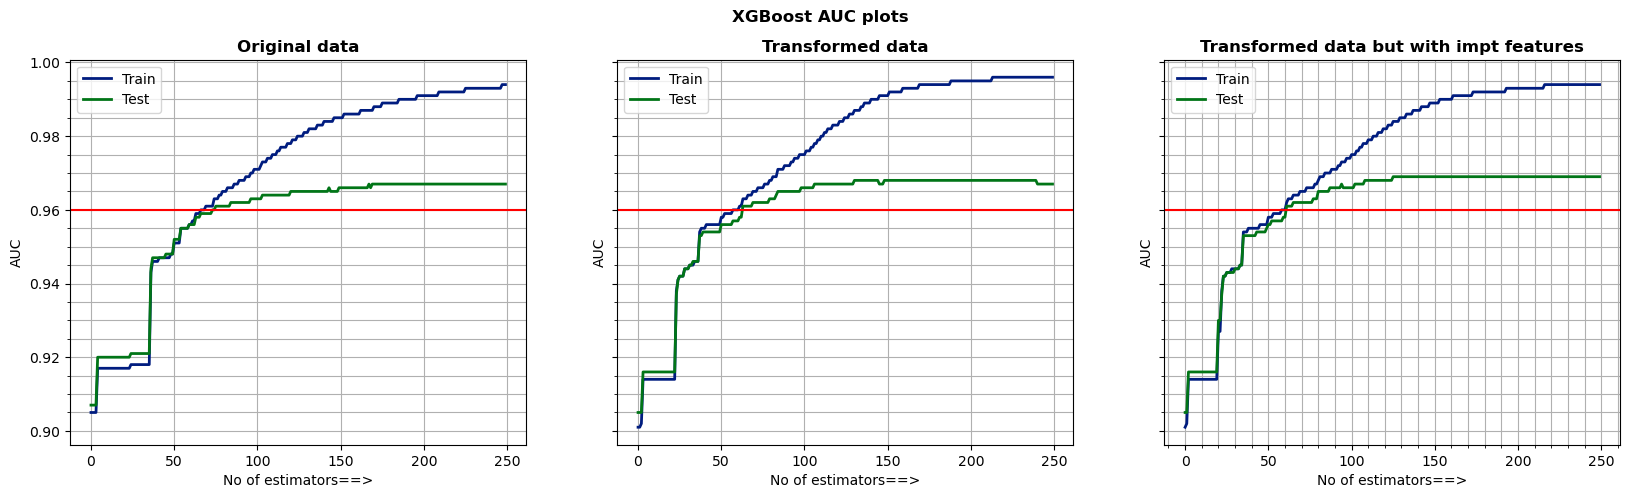

In [62]:
# 12.0 Learning curves of all the three models

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Original data", 'Transformed data', 'Transformed data but with impt features']
fig.suptitle("XGBoost AUC plots", fontweight = "bold")
for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators==>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();



## Part-I: Preparing for PCA: imputing data  

In [149]:
# 12.1 ReCheck
X_train_trans.shape  #(3750000, 193)
X_test_trans.shape   # (1250000, 193)
X_train_trans.isnull().sum().sum()  # 10032/12312/12122
X_test_trans.isnull().sum().sum()  # 3686/4028/4294

(3750000, 193)

(1250000, 193)

12122

4294

In [64]:
# 12.1.1 MAke a copy for imputation
X_train_trans_imputed = X_train_trans.copy()
X_test_trans_imputed= X_test_trans.copy()

In [65]:
# 12.2 Impute as transformed data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_imputed[:] = si.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = si.transform(X_test_trans_imputed)
end = time.time()
print("Done: ", (end-start)/60)  #  3.78m
_ = gc.collect()

Imputing....
Done:  4.0284198721249895


In [66]:
# 12.2.2 Save imputed data for later experiments.


X_train_trans_imputed.to_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans_imputed.to_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 12.2.3 Datashapes of imputed data:
X_train_trans_imputed.shape  # (3750000, 193)
X_test_trans_imputed.shape   # (1250000, 193)

(3750000, 193)

(1250000, 193)

In [67]:
# 12.2.4 Standardize features:

start = time.time()
ss =StandardScaler()
X_train_trans_imputed[:] = ss.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:]= ss.transform(X_test_trans_imputed)
end = time.time()
print("Done: ", (end-start)/60)  #  0.22m
_ = gc.collect()

Done:  0.21702227592468262


### PCA now

In [68]:
# 13 PCA with transformed train data.
#      Note that n_components = 0.95

pca = PCA(n_components= 0.95,
          whiten= True, 
          random_state = rng
         )

ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(X_train_trans_imputed))
pca_test = pca.transform(ss.transform(X_test_trans_imputed))

# 13.1 Check data shapes:
pca_train.shape  # (3750000, 35)/(3750000, 36)
pca_test.shape   # (1250000, 35)/(1250000, 36)

(3750000, 36)

(1250000, 36)

In [69]:
# 13.2 Assign column names and transform to DataFrame:

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

# 13.3 Dataframe shapes:
pca_train.shape  #(3750000, 36)
pca_test.shape   # 1250000, 36)

(3750000, 36)

(1250000, 36)

### PCA plots of pc0 and pc1

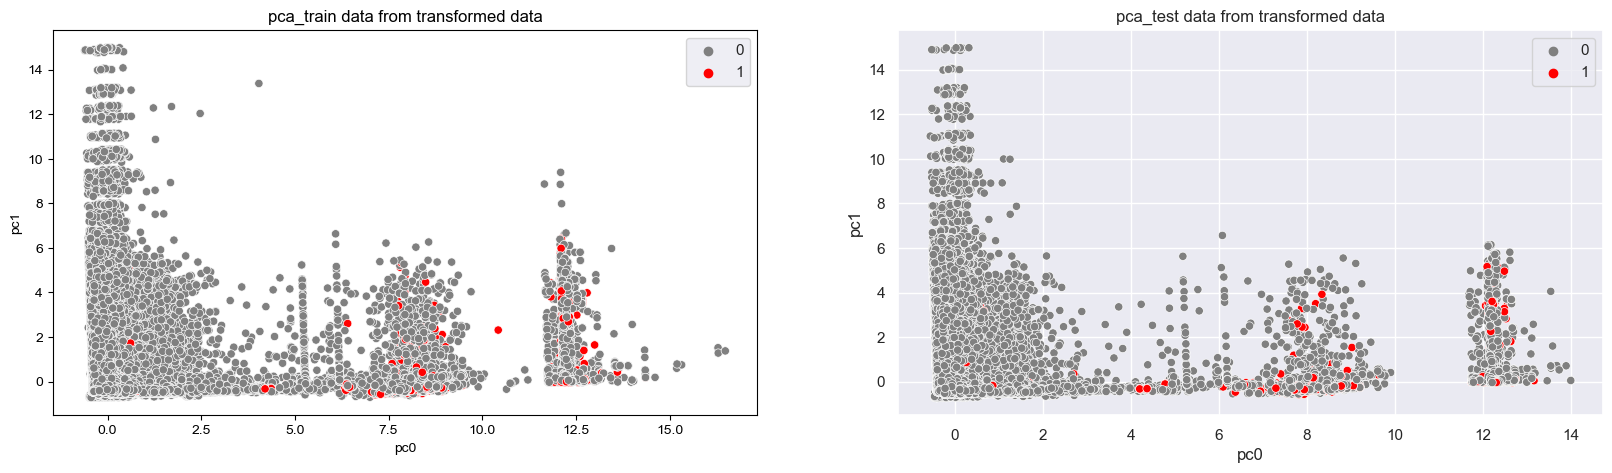

In [70]:
# 14.0 2D PCA plot from first two principal components:

fig = plt.figure(figsize = (20,5));
fig.add_subplot(1,2,1);
sns.set_theme() ; # Set default theme
plt.style.use('seaborn-v0_8-dark-palette')

# 13.5 plot pca-train data
sns.scatterplot(data = pca_train,
                x=  'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["grey", "red"]
                ).set(title='pca_train data from transformed data') ;

# 13.6 Plot pca_test data
fig.add_subplot(1,2,2);
sns.scatterplot(data = pca_test,
                x=  'pc0',
                y = 'pc1',
                hue = y_test.values,
                palette = ["grey", "red"]
                ).set(title='pca_test data from transformed data') ;

## Examining pca plot
Density of fraudulent points to the right of 4.0 (pc0 >4.0) is around 76 times more than that on the left of 4.0 (pc0 <= 4.0). The following calculations show this. 

In [71]:
# 15.0 Let us examine the above graph more closely:
#      Merge pca_train and y_train
pcatyt = pd.concat([pca_train, y_train.reset_index(drop = True)],  axis = 1)  # train
pcateyt = pd.concat([pca_test, y_test.reset_index(drop = True)],  axis = 1)   # test

# 15.0.1 Data-points when pc0 > 4.0
pcayt_rt= pcatyt.loc[pcatyt.pc0 > 4.0, :]      # train
pcayte_rt= pcateyt.loc[pcateyt.pc0 > 4.0, :]   # test

nf_rt = pcayt_rt['isattributed'].sum() # 3116
nnf_rt = pcayt_rt.shape[0]             # 27791

# 15.0.2 Ratio of fradulent to non-fraudulent
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_rt/(nnf_rt-nf_rt))  # 12.6%

# 15.0.3 Same calculations for the data on the left
#        Data-points when pc0 <= 4.0
pcayt_lt= pcatyt.loc[pcatyt.pc0 <= 4.0, :]
nf_lt = pcayt_lt['isattributed'].sum() # 3116
nnf_lt = pcayt_lt.shape[0]  # 27791

# 15.0.4 Ratio of fradulent to non-fraudulent points:
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_lt/(nnf_lt-nf_lt))  # 0.16%

Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.1265770932328363
Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.0016545808803209816


### Patterns in +ve and -ve events
Plots of +ve and -ve events below show that while -ve events do not have any specific pattern, +ve events do have specific patterns and are confined to certain narrow ranges.

#### Consider pac_train first

In [72]:
# 15.0.5 Patterns in +ve and -ve samples
# Positive samples
pca_onlypos = pcatyt.loc[pcatyt.isattributed == 1, :]

# 15.0.6 Negative samples
pca_onlyneg = pcatyt.loc[pcatyt.isattributed == 0, :]

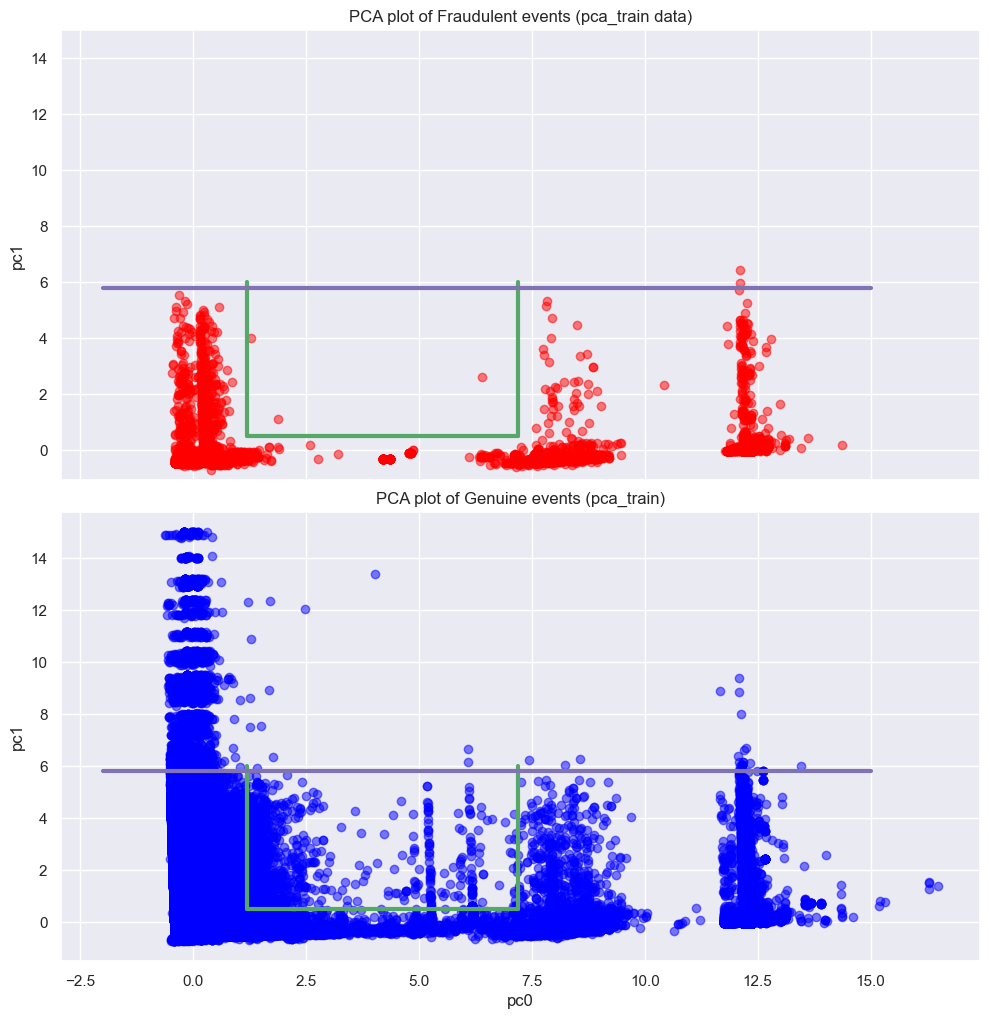

In [73]:
# 15.1 Separate scatter plots of positive and negatives: 

fig, axs = plt.subplots(nrows=2, sharex=True, figsize = (10,10));
plt.rc('grid', linestyle="-", color='black')
plt.tight_layout();

data = pca_onlypos.iloc[:,:-1]
data1 = pca_onlyneg.iloc[:,:-1]

_=axs[0].scatter(data.pc0, data.pc1, c="red", alpha=0.5);
axs[0].grid(True)
_=axs[0].set_title("PCA plot of Fraudulent events (pca_train data)");
_=axs[0].set_ylabel('pc1');

_=axs[1].scatter(data1.pc0, data1.pc1, c="blue", alpha=0.5);
_=axs[1].set_title("PCA plot of Genuine events (pca_train)");
_=axs[1].set_xlabel('pc0');
_=axs[1].set_ylabel('pc1');
_=axs[0].set_ylim(top = 15)


# 15.1.1 Bounds of fraudulent events
# https://stackoverflow.com/a/16930526/3282777
_=axs[0].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[0].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

_=axs[1].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[1].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

axs[1].grid(True)


plt.show()

Within green boundary, there are plenty of genuine clicks but very few fraud clicks. Also above magenta line very few fraud events exist.

#### Consider pac_test now

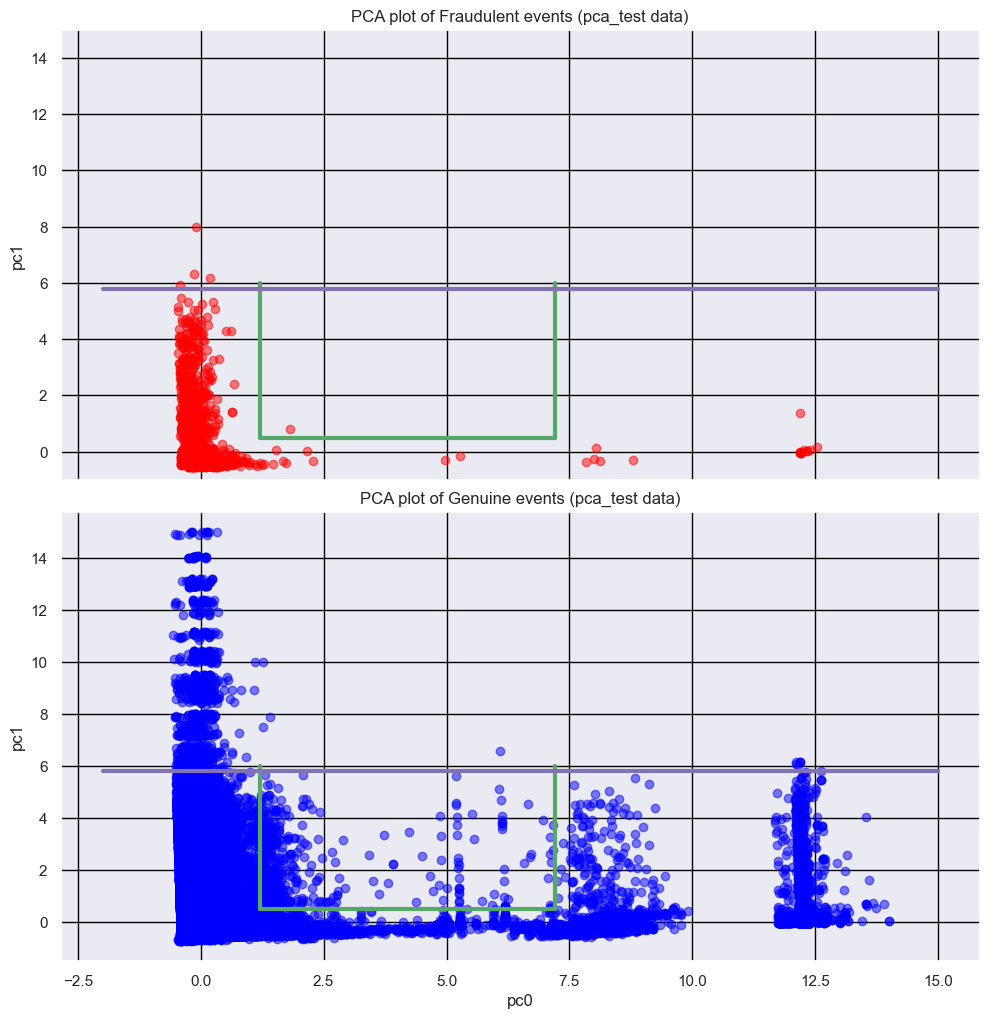

In [74]:
# 15.2.0 Patterns in +ve and -ve samples
# Positive samples
pca_onlypos = pcateyt.loc[pcatyt.isattributed == 1, :]
# 15.2.1 Negative samples
pca_onlyneg = pcateyt.loc[pcatyt.isattributed == 0, :]

# 15.2.2 Separate scatter plots of positive and negatives: 

fig, axs = plt.subplots(nrows=2, sharex=True, figsize = (10,10));
plt.rc('grid', linestyle="-", color='black')
plt.tight_layout();

data = pca_onlypos.iloc[:,:-1]
data1 = pca_onlyneg.iloc[:,:-1]

_=axs[0].scatter(data.pc0, data.pc1, c="red", alpha=0.5);
axs[0].grid(True)
_=axs[0].set_title("PCA plot of Fraudulent events (pca_test data)");
_=axs[0].set_ylabel('pc1');

_=axs[1].scatter(data1.pc0, data1.pc1, c="blue", alpha=0.5);
_=axs[1].set_title("PCA plot of Genuine events (pca_test data)");
_=axs[1].set_xlabel('pc0');
_=axs[1].set_ylabel('pc1');
_=axs[0].set_ylim(top = 15)


# 15.2.3 Bounds of fraudulent events
# https://stackoverflow.com/a/16930526/3282777
_=axs[0].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[0].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

_=axs[1].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[1].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

axs[1].grid(True)

plt.show()

Pattern for test data is almost the same as that for train data

### Save and Read pca data

In [75]:
# 16.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(dataPath / "pca_train_orig.pkl")
pca_test.to_pickle(dataPath / "pca_test_orig.pkl")

In [76]:
# 16.1 Read back saved data:

pca_train = pd.read_pickle(dataPath / "pca_train_orig.pkl")
pca_test =  pd.read_pickle(dataPath / "pca_test_orig.pkl")

# 16.1.2 Check
pca_train.head(3)
pca_test.head(3)

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.302805 -0.457370 -1.355399 -0.225970 -0.285143  1.081837 -0.496232   
1 -0.227554 -0.315118 -0.601392  0.043086  0.313276  1.108564 -0.706538   
2 -0.056447 -0.422722 -0.323160  0.520714  0.688583  0.051694  0.232866   

        pc7       pc8       pc9  ...      pc26      pc27      pc28      pc29  \
0 -0.353474  0.281660  0.447910  ...  1.455618 -0.580970  0.936849 -1.045184   
1  0.352593 -0.327918 -0.240276  ... -0.716213  0.895943  0.320931 -0.897876   
2  0.485703 -0.145724 -0.149171  ...  1.233033 -1.097779 -1.124142 -0.810785   

       pc30      pc31      pc32      pc33      pc34      pc35  
0 -0.191710 -0.049799  0.405354 -0.048591 -0.031060  0.205753  
1 -0.941333  0.244229  0.066090  0.860559 -0.616325  0.901225  
2 -0.082030 -1.232779 -1.777638 -0.883512  0.214301 -0.708377  

[3 rows x 36 columns]

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.045555 -0.423383 -0.285345  0.477955  0.540414  0.078978  0.188088   
1 -0.296700 -0.447297 -1.226863  0.075119  0.030695  1.434867 -0.536407   
2 -0.055295 -0.324284  2.617645 -1.049174  0.386715 -0.341897 -0.459352   

        pc7       pc8       pc9  ...      pc26      pc27      pc28      pc29  \
0  0.422989  0.270412  0.328913  ...  1.353080 -0.552630  1.560465 -1.384406   
1  0.081290 -0.071828  0.004307  ... -0.625269 -0.523233 -0.058379  0.410833   
2 -0.597591  0.177107  0.098287  ...  1.697022  0.481120 -0.510454 -2.012701   

       pc30      pc31      pc32      pc33      pc34      pc35  
0 -0.254298 -0.874632 -1.147411 -0.942352  0.229191 -1.326262  
1 -0.219545  0.157496  0.634610 -0.028149 -0.134785  0.727629  
2  0.195474  0.656089  0.320437  0.679413  0.084075 -0.036694  

[3 rows x 36 columns]

## PCA data for xgboost modeling
The results are as good as from original data with no transformation.

In [77]:
# 17.0 Prepare xgboost model--PCA data


model_pca_orig = xgb.XGBClassifier( n_estimators= 400,
                                   verbosity = 3,
                                   eta = 0.06,
                                   max_depth = 10,
                                   subsample = 0.8,
                                   #class_weight = class_weights,   
                                   random_state = rng,
                           )


tr_X =   pca_train 
test_X = pca_test  
ytrain = y_train     
ytest = y_test       


model_pca_orig.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[18:56:13] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:56:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90297	validation_1-auc:0.90619
[18:56:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90307	validation_1-auc:0.90626
[18:56:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 536 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90320	validation_1-auc:0.90636
[18:56:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90737	validati

[19:00:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 780 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.93848	validation_1-auc:0.93899
[19:00:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 828 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93995	validation_1-auc:0.93984
[19:00:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 780 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.94072	validation_1-auc:0.94029
[19:01:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 812 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94079	validation_1-auc:0.94035
[19:01:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.96378	validation_1-auc:0.95806
[19:05:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96400	validation_1-auc:0.95817
[19:05:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96435	validation_1-auc:0.95841
[19:05:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96484	validation_1-auc:0.95875
[19:05:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96542	validation_1-auc:0.95900
[19:05:57] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.98219	validation_1-auc:0.96204
[19:10:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.98259	validation_1-auc:0.96215
[19:10:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.98295	validation_1-auc:0.96227
[19:10:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.98332	validation_1-auc:0.96228
[19:10:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.98377	validation_1-auc:0.96270
[19:10:51] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.99209	validation_1-auc:0.96428
[19:15:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.99218	validation_1-auc:0.96430
[19:15:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.99236	validation_1-auc:0.96440
[19:15:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.99257	validation_1-auc:0.96444
[19:15:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.99268	validation_1-auc:0.96443
[19:15:49] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99567	validation_1-auc:0.96519
[19:20:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99575	validation_1-auc:0.96513
[19:20:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99585	validation_1-auc:0.96519
[19:20:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99590	validation_1-auc:0.96527
[19:20:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99594	validation_1-auc:0.96529
[19:20:47] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [78]:
# 17.0.1 Save model_pca_orig model:

gc.collect()
utils.savePythonObject(model_pca_orig, "model_pca_orig.pkl", estimatorsPath )

15916

Object saved to: D:\talkingdata\allmodels\estimators\model_pca_orig.pkl


In [79]:
# 17.0.2 Restore model_pca_orig  model:

model_pca_orig = utils.restorePythonObject("model_pca_orig.pkl", estimatorsPath )

In [80]:
# 17.1 Best Scores:

model_pca_orig.best_score     # 0.957855642047371/0.9641408029425013
model_pca_orig.best_iteration # 179/171

0.9653121492211353

167

In [81]:
# 17.2 Classification report of model with PCA data:

pred = model_pca_orig.predict(test_X)
cr_pca = classification_report(ytest, pred)
print(cr_pca)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.78      0.33      0.46      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.66      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



## Balancing the imbalanced PCA data
By using the PCA data and the data cleaning technique of `EditedNearestNeighbours` we are able to improve f1 score from 0.47 to 0.51. The AUC remains almost the same as that for the original data. `EditedNearestNeighbours` is a data cleaning technique rather than a data balancing technique. The method cleans the data by removing majority samples close to the decision boundary.

In [82]:
# 18.0 Call imblearn library:
#      We find EditedNearestNeighbours the best in this case

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN  
from imblearn.combine import SMOTEENN

In [83]:
# 18.1 Undersample pca_train data:

start = time.time()
undersample = EditedNearestNeighbours()   
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 129min

# 18.1.1 Data shape
X_res.shape  #  (3734087, 35)/(3734917, 36)
y_res.shape  #  (3734087,)/(3734917,)

0

130.19343480269114


(3734721, 36)

(3734721,)

In [84]:
# 18.1.2 Save above files:

X_res.to_pickle(dataPath / "X_res_orig.pkl")
y_res.to_pickle(dataPath / "y_res_orig.pkl")
gc.collect()

0

In [85]:
# 18.1.3 Read back:

X_res = pd.read_pickle(dataPath / "X_res_orig.pkl")
y_res = pd.read_pickle(dataPath / "y_res_orig.pkl")
y_res.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25

0    0.997526
1    0.002474
Name: isattributed, dtype: float64

0    0.997536
1    0.002464
Name: isattributed, dtype: float64

In [86]:
# 19.1 xgboost Modeling with undersampled data

model_res_orig = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_res_orig.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



0

[21:34:59] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[21:35:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 598 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90352	validation_1-auc:0.90597
[21:35:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90390	validation_1-auc:0.90629
[21:35:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90398	validation_1-auc:0.90638
[21:35:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90402	validati

[21:39:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 778 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.94023	validation_1-auc:0.94016
[21:39:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.94021	validation_1-auc:0.94015
[21:39:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 786 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.94087	validation_1-auc:0.94041
[21:39:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 716 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94198	validation_1-auc:0.94132
[21:39:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.96233	validation_1-auc:0.95553
[21:44:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 648 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96300	validation_1-auc:0.95586
[21:44:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96347	validation_1-auc:0.95611
[21:44:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 646 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96385	validation_1-auc:0.95660
[21:44:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96466	validation_1-auc:0.95709
[21:44:36] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.98221	validation_1-auc:0.96307
[21:48:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 690 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.98273	validation_1-auc:0.96311
[21:49:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.98317	validation_1-auc:0.96312
[21:49:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 596 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.98343	validation_1-auc:0.96319
[21:49:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.98372	validation_1-auc:0.96335
[21:49:27] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.99307	validation_1-auc:0.96505
[21:53:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.99326	validation_1-auc:0.96512
[21:53:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.99348	validation_1-auc:0.96516
[21:54:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.99366	validation_1-auc:0.96513
[21:54:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.99370	validation_1-auc:0.96519
[21:54:22] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99685	validation_1-auc:0.96597
[21:58:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99688	validation_1-auc:0.96594
[21:58:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99692	validation_1-auc:0.96596
[21:59:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 604 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99698	validation_1-auc:0.96589
[21:59:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99703	validation_1-auc:0.96589
[21:59:20] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99805	validation_1-auc:0.96589
[22:03:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99807	validation_1-auc:0.96583
[22:03:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99812	validation_1-auc:0.96582
[22:03:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99817	validation_1-auc:0.96582
[22:04:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99818	validation_1-auc:0.96582
[22:04:14] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [87]:
# 19.1.1 Save model:

utils.savePythonObject(model_res_orig, "model_res_orig.pkl", estimatorsPath )

44

Object saved to: D:\talkingdata\allmodels\estimators\model_res_orig.pkl


In [88]:
# 19.1.2 Restore model:

model_res_orig = utils.restorePythonObject("model_res_orig.pkl", estimatorsPath )


In [89]:
# 19.2 Best Scores:

model_res_orig.best_score     # 0.9586662564858861/0.9648543301586655/0.9659711135968656
model_res_orig.best_iteration # 184/189/183

0.9659711135968656

183

In [90]:
# 19.3 Classification report of model with PCA data:

pred = model_res_orig.predict(test_X)
cr_pca = classification_report(ytest, pred)
print(cr_pca)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.51      0.53      0.52      3079

    accuracy                           1.00   1250000
   macro avg       0.75      0.76      0.76   1250000
weighted avg       1.00      1.00      1.00   1250000



## Part-II: Treating ip as numeric and then performing PCA:  
In the Kaggle problem it has not been explained as to how `'ip'` has been transformed into numbers. Paradoxically, if we treat `'ip'` as numeric, results are about the same as those after our transformation. We treat below,`'ip'` as a numeric field.   
From the transofmed data `(X_train_trans, X_test_trans)`, we first remove all those features that have been derived from `'ip'` and then concatenate `'ip'` column as one of the numeric features. Incidentaly, in one of the Kaggle solutions, link [here](https://www.kaggle.com/code/georsara1/95-auc-score-in-train-sample-with-neural-nets), 'ip' has been treated as numeric and results are quite good.

### Columns that have not been drived from IP

In [225]:

# 20.0 Which cols have 'ip' as a part of their names:

colsWithip = [i for i in X_train_trans.columns if 'ip' in i ]

# 20.0.1 And which ones do not?
colsWithoutip = [i for i in X_train_trans.columns if 'ip' not in i ]

# 20.0.2
len(colsWithoutip)  # 100
print("\n\n====")

# 20.0.3
X_train_trans[colsWithoutip].shape  # (3750000, 100)

100



====


(3750000, 100)

In [226]:
# 20.0.4 Here is a list of created columns. All of them have 'ip':

print(colsWithip)

['deg_app_ck_channel_p_ip', 'deg_app_ck_device_p_ip', 'deg_app_ck_ip', 'deg_app_ck_os_p_ip', 'deg_channel_ck_app_p_ip', 'deg_channel_ck_device_p_ip', 'deg_channel_ck_ip', 'deg_channel_ck_os_p_ip', 'deg_device_ck_app_p_ip', 'deg_device_ck_channel_p_ip', 'deg_device_ck_ip', 'deg_device_ck_os_p_ip', 'deg_ip_ck_app', 'deg_ip_ck_app_p_channel', 'deg_ip_ck_app_p_device', 'deg_ip_ck_app_p_os', 'deg_ip_ck_channel', 'deg_ip_ck_device_p_channel', 'deg_ip_ck_device_p_os', 'deg_ip_ck_os', 'deg_ip_ck_os_p_channel', 'deg_os_ck_app_p_ip', 'deg_os_ck_channel_p_ip', 'deg_os_ck_device_p_ip', 'deg_os_ck_ip', 'eig_app_ck_app_p_ip', 'eig_app_ck_channel_p_ip', 'eig_app_ck_device_p_ip', 'eig_app_ck_ip', 'eig_app_ck_os_p_ip', 'eig_channel_ck_app_p_ip', 'eig_channel_ck_channel_p_ip', 'eig_channel_ck_device_p_ip', 'eig_channel_ck_ip', 'eig_channel_ck_os_p_ip', 'eig_device_ck_app_p_ip', 'eig_device_ck_channel_p_ip', 'eig_device_ck_device_p_ip', 'eig_device_ck_ip', 'eig_device_ck_os_p_ip', 'eig_ip_ck_app', 'eig_i

### Process the earlier fully transformed data:

In [227]:
# 21.0 Read imputed data 


X_train_trans_imputed = pd.read_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 21.1.1 Datashapes of imputed data:
X_train_trans_imputed.shape  # (3750000, 193)
X_test_trans_imputed.shape   # (1250000, 193)

(3750000, 193)

(1250000, 193)

In [228]:
# 21.1.2 Get transformed data but without 'colsWithoutip'  :

X_train_trans_withoutip = X_train_trans_imputed[colsWithoutip].copy() 
X_test_trans_withoutip = X_test_trans_imputed[colsWithoutip].copy() 

# 21.1.3 Check if it needs imputation?
#         No. Not needed.
X_train_trans_withoutip.isnull().sum().sum()  # 0
X_test_trans_withoutip.isnull().sum().sum()  # 0

0

0

In [229]:
#   No need to impute

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_withoutip[:] = si.fit_transform(X_train_trans_withoutip)
X_test_trans_withoutip[:] = si.transform(X_test_trans_withoutip)
end = time.time()
print("Done: ", (end-start)/60)  #  1.7992372711499531/0.636960029602050
_ = gc.collect()

Imputing....
Done:  0.6369600296020508


In [230]:
# 21.1.4 Save imputed data for later experiments:

X_train_trans_withoutip.to_pickle(Path(dataPath) / "X_train_trans_without.pkl")
X_test_trans_withoutip.to_pickle(Path(dataPath) / "X_test_trans_without.pkl")

# 21.1.5 Datashapes of imputed data:
X_train_trans_withoutip.shape  # (3750000, 100)
X_test_trans_withoutip.shape   # (1250000, 100)

0

(3750000, 100)

(1250000, 100)

In [231]:
# 21.1.5 Read back saved data:

X_train_trans_withoutip = pd.read_pickle(Path(dataPath) / "X_train_trans_without.pkl")
X_test_trans_withoutip = pd.read_pickle(Path(dataPath) / "X_test_trans_without.pkl")

# 21.1.6 Check
X_train_trans_withoutip.shape  # (3750000, 100)
X_test_trans_withoutip.shape   # (1250000, 100)

(3750000, 100)

(1250000, 100)

In [232]:
# 21.1.7 Concatenate 'ip' col. We now treat it as numeric:

X_train_trans_withip = pd.concat( [X_train['ip'], X_train_trans_withoutip], axis = 1)
X_test_trans_withip =  pd.concat( [X_test['ip'],  X_test_trans_withoutip], axis = 1)

# 21.1.8
X_train_trans_withip.shape # (3750000, 101)
X_test_trans_withip.shape   # (1250000, 101)                                     

(3750000, 101)

(1250000, 101)

### PCA of processed data (treating ip as numeric):

In [233]:
# 22.0 PCA with transformed train data.
#      Note that n_components = 0.95
#      ip is included as a numeric feature

pca = PCA(n_components= 0.95,
          whiten= True, 
          random_state = rng
         )

# 22.1
ss = StandardScaler()
pca_train_ipn = pca.fit_transform(ss.fit_transform(X_train_trans_withip))
pca_test_ipn = pca.transform(ss.transform(X_test_trans_withip))

# 22.2 Check data shapes:
pca_train_ipn.shape  # (3750000, 25)
pca_test_ipn.shape   # (1250000, 25)

(3750000, 25)

(1250000, 25)

In [234]:
# 22.3 Assign column names and transform to DataFrame:

colnames = ["pc" + str(i) for i in range(pca_train_ipn.shape[1])]
pca_train_ipn = pd.DataFrame(pca_train_ipn, columns = colnames)
pca_test_ipn = pd.DataFrame(pca_test_ipn, columns = colnames)

# 22.3.1 Dataframe shapes:
pca_train_ipn.shape  #(3750000, 25)
pca_test_ipn.shape   # 1250000, 25)

(3750000, 25)

(1250000, 25)

### PCA plot (ip is numeric)

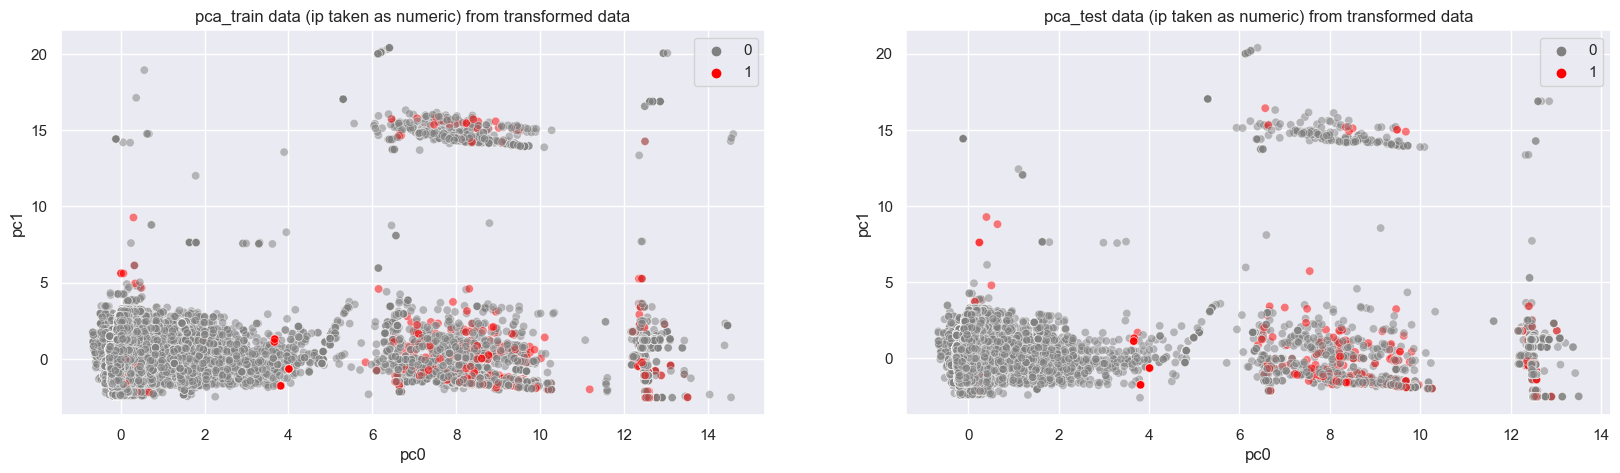

In [235]:
# 23.0 2D PCA plot from first two principal components:

fig = plt.figure(figsize = (20,5));
fig.add_subplot(1,2,1);
sns.set_theme() ; # Set default theme
plt.style.use('seaborn-v0_8-dark-palette')

# 23.1 plot pca_train_ipn data
sns.scatterplot(data = pca_train_ipn,
                x=  'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["grey", "red"], alpha = 0.5
                ).set(title='pca_train data (ip taken as numeric) from transformed data') ;

# 23.2 Plot pca_test_ipn data
fig.add_subplot(1,2,2);
sns.scatterplot(data = pca_test_ipn,
                x=  'pc0',
                y = 'pc1',
                hue = y_test.values,
                palette = ["grey", "red"], alpha = 0.5
                ).set(title='pca_test data (ip taken as numeric) from transformed data') ;

### Save/read back pca data

In [236]:
# 23.3 Save pca_train and pca_test for later experiments:

pca_train_ipn.to_pickle(dataPath / "pca_train_ipn.pkl")
pca_test_ipn.to_pickle(dataPath / "pca_test_ipn.pkl")

In [237]:
# 23.3.1 Read back saved data:

pca_train_ipn = pd.read_pickle(dataPath / "pca_train_ipn.pkl")
pca_test_ipn =  pd.read_pickle(dataPath / "pca_test_ipn.pkl")

# 23.3.2 Check
pca_train_ipn.head(3)
pca_test_ipn.head(3)

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.165427 -1.501597  0.050409  0.698396  0.113411  1.184518 -0.105176   
1 -0.131124 -0.713084  0.348218  0.438593  0.581988 -1.349949  0.082645   
2 -0.097850 -0.389360  0.504977 -0.450040  0.404408 -0.318296  0.002880   

        pc7       pc8       pc9  ...      pc15      pc16      pc17      pc18  \
0 -0.246969  0.023819  0.087172  ...  0.308998  0.287877 -0.016624  1.315433   
1  0.125397  0.018484  0.005494  ... -1.087250 -0.426422  0.382898 -0.655565   
2  0.037091 -0.009083 -0.066663  ...  0.456147  1.675867  0.863490  0.041624   

       pc19      pc20      pc21      pc22      pc23      pc24  
0  1.103277 -0.588084 -0.449971  1.247485 -0.775142  0.257142  
1 -0.684034 -0.780162 -0.048288  0.644188 -0.498953  0.097717  
2  2.574805 -2.874047 -1.571563 -1.124247  1.560967 -0.923250  

[3 rows x 25 columns]

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.082530 -0.530099  0.366600 -0.498962  0.125838  1.023460 -0.125906   
1 -0.201264 -1.361034  0.350713  0.896502  0.543174 -0.290890  0.024643   
2 -0.013015  2.845660 -0.731036 -0.063988  0.182143  0.475365 -0.038975   

        pc7       pc8       pc9  ...      pc15      pc16      pc17      pc18  \
0 -0.215096  0.014672  0.053677  ... -1.234533  0.280020  1.113351  0.987598   
1  0.001747  0.016031 -0.045222  ...  0.527809 -0.218649  0.221713 -1.122282   
2 -0.114213 -0.009368 -0.014120  ... -0.044840  1.281835 -0.384705  1.751185   

       pc19      pc20      pc21      pc22      pc23      pc24  
0  1.331840 -0.867230 -0.907171 -0.149841  1.763362  0.926944  
1  1.149755 -1.682983  0.277503  0.003463 -1.335145  0.780751  
2 -0.175426 -0.087923 -0.700535 -0.221231  0.529782  0.332603  

[3 rows x 25 columns]

### XGboost modeling of PCA data (ip is taken as numeric)


In [238]:
# 24.0 Prepare xgboost model--PCA data, ip is taken as numeric:

model_pca_ipn = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               #class_weight = class_weights,   
                               random_state = rng,
                           )


tr_X =   pca_train_ipn  
test_X = pca_test_ipn   
ytrain = y_train     
ytest = y_test       


model_pca_ipn.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[14:30:04] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[14:30:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 610 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.86508	validation_1-auc:0.86466
[14:30:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.88411	validation_1-auc:0.88615
[14:30:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 578 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.88469	validation_1-auc:0.88639
[14:30:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88475	validati

[14:33:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.91996	validation_1-auc:0.91999
[14:33:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 738 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.92004	validation_1-auc:0.92006
[14:33:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 798 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.93035	validation_1-auc:0.93052
[14:33:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 726 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.93081	validation_1-auc:0.93091
[14:33:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95872	validation_1-auc:0.95785
[14:36:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 680 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95918	validation_1-auc:0.95811
[14:36:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 736 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95929	validation_1-auc:0.95799
[14:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 680 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96028	validation_1-auc:0.95878
[14:36:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96022	validation_1-auc:0.95873
[14:37:01] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97507	validation_1-auc:0.96395
[14:40:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97547	validation_1-auc:0.96398
[14:40:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 788 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97579	validation_1-auc:0.96402
[14:40:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 952 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97616	validation_1-auc:0.96413
[14:40:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 812 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97657	validation_1-auc:0.96436
[14:40:33] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98897	validation_1-auc:0.96554
[14:43:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98913	validation_1-auc:0.96554
[14:43:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98931	validation_1-auc:0.96564
[14:44:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98962	validation_1-auc:0.96552
[14:44:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98983	validation_1-auc:0.96556
[14:44:14] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99341	validation_1-auc:0.96587
[14:47:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 532 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99351	validation_1-auc:0.96583
[14:47:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99354	validation_1-auc:0.96584
[14:47:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99355	validation_1-auc:0.96584
[14:47:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99368	validation_1-auc:0.96575
[14:47:55] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [239]:
# 24.0.1 Save model:
gc.collect()
utils.savePythonObject(model_pca_ipn, "model_pca_ipn.pkl", estimatorsPath )

167

Object saved to: D:\talkingdata\allmodels\estimators\model_pca_ipn.pkl


In [240]:
# 24.0.2 Restore model:

model_pca_ipn = utils.restorePythonObject("model_pca_ipn.pkl", estimatorsPath )

In [241]:
# 24.0.3 Best Scores:

model_pca_ipn.best_score     # 0.957044921859579/0.9659921362144639
model_pca_ipn.best_iteration # 167/166

0.9659921362144639

166

In [242]:
# 24.0.4 Classification report of model with PCA data:

pred = model_pca_ipn.predict(test_X)
cr_pca = classification_report(ytest, pred)
print(cr_pca)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.76      0.34      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.88      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



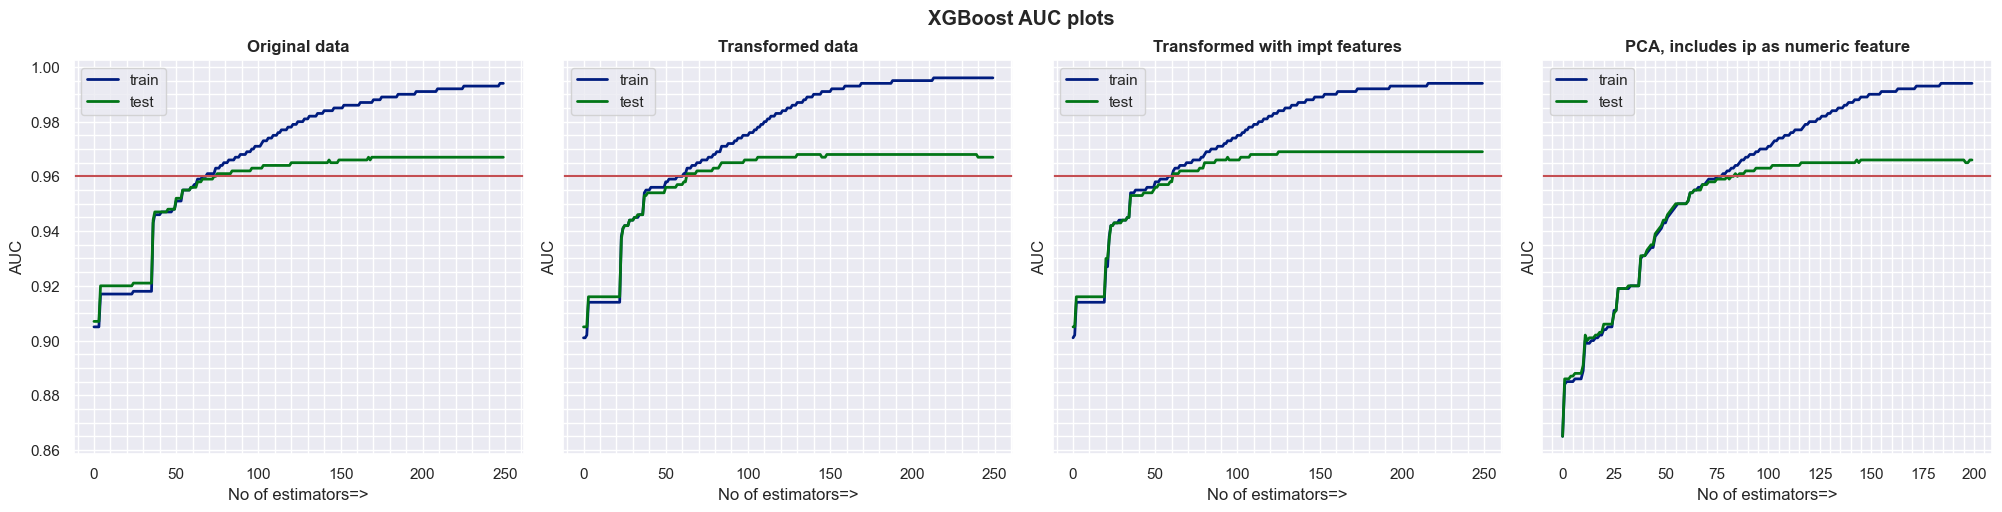

In [243]:
# 25.0
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_trans_impt.evals_result(), model_pca_ipn.evals_result() ]
title = ["Original data", 'Transformed data','Transformed with impt features', 'PCA, includes ip as numeric feature']
fig.suptitle("XGBoost AUC plots", fontweight = "bold")
plt.tight_layout()
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();

## Balancing unbalanced PCA data (ip is taken as numeric)
We get significantly imrpoved F1 scores when we use two techniques: `EditedNearestNeighbours` and `AllKNN`. Results with `AllKNN` are a shade better than those with `EditedNearestNeighbours`. However, `AllKNN` takes a lot of time. `EditedNearestNeighbours` is a decision boundary cleaning technique by removing majority features rather than an undersampling technique.

In [138]:
# 26.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN   
from imblearn.combine import SMOTEENN

In [244]:
# 26.1 Cleanup decision boundaries through undersampling 
#        of majority points in PCA train data using EditedNearestNeighbours:


start = time.time()
undersample = EditedNearestNeighbours()   
X_resenn, y_resenn = undersample.fit_resample(pca_train_ipn, y_train)
end = time.time()
print((end-start)/60)  # 114min/116m

# 26.1.1 Data shape
X_resenn.shape  #  (3735683, 24)/(3735706, 25)
y_resenn.shape  # (3735683,)/(3735706, )

16163

116.86670789718627


(3735706, 25)

(3735706,)

In [245]:
# 26.1.2 Save above files:

X_resenn.to_pickle(dataPath / "X_resenn.pkl")
y_resenn.to_pickle(dataPath / "y_resenn.pkl")
gc.collect()

0

In [246]:
# 26.1.3 Read back:

X_resenn = pd.read_pickle(dataPath / "X_resenn.pkl")
y_resenn = pd.read_pickle(dataPath / "y_resenn.pkl")
y_resenn.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25

0    0.997527
1    0.002473
Name: isattributed, dtype: float64

0    0.997536
1    0.002464
Name: isattributed, dtype: float64

In [247]:
# 26.2 xgboost Modeling with cleanedup/undersampled data

model_en = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_resenn 
test_X = pca_test_ipn
ytrain = y_resenn 
ytest =  y_test


model_en.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



[16:50:53] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[16:50:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 646 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.88064	validation_1-auc:0.88423
[16:51:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.88434	validation_1-auc:0.88707
[16:51:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 600 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.88470	validation_1-auc:0.88758
[16:51:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 582 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88468	validati

[16:54:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.92136	validation_1-auc:0.92034
[16:54:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93158	validation_1-auc:0.93185
[16:54:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.93174	validation_1-auc:0.93187
[16:54:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.93180	validation_1-auc:0.93192
[16:54:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95935	validation_1-auc:0.95729
[16:57:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95971	validation_1-auc:0.95755
[16:57:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95967	validation_1-auc:0.95753
[16:57:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 570 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95981	validation_1-auc:0.95755
[16:57:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96026	validation_1-auc:0.95794
[16:58:05] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97564	validation_1-auc:0.96474
[17:01:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 686 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97603	validation_1-auc:0.96479
[17:01:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97619	validation_1-auc:0.96482
[17:01:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97674	validation_1-auc:0.96486
[17:01:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97726	validation_1-auc:0.96494
[17:01:36] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98990	validation_1-auc:0.96574
[17:04:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.99015	validation_1-auc:0.96578
[17:05:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 532 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.99046	validation_1-auc:0.96586
[17:05:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.99059	validation_1-auc:0.96590
[17:05:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.99075	validation_1-auc:0.96585
[17:05:21] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99442	validation_1-auc:0.96624
[17:08:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99453	validation_1-auc:0.96623
[17:08:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99457	validation_1-auc:0.96625
[17:08:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99460	validation_1-auc:0.96627
[17:08:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99470	validation_1-auc:0.96622
[17:09:00] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99649	validation_1-auc:0.96596
[17:12:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99654	validation_1-auc:0.96590
[17:12:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99658	validation_1-auc:0.96596
[17:12:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99662	validation_1-auc:0.96590
[17:12:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99665	validation_1-auc:0.96590
[17:12:47] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [248]:
# 26.3 Save model:

utils.savePythonObject(model_en, "model_en.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_en.pkl


In [249]:
# 26.4 Restore model:

model_en = utils.restorePythonObject("model_en.pkl", estimatorsPath )

In [250]:
# 26.5 Best Scores:

model_en.best_score     # 0.9576643874479048/0.9664954846690678
model_en.best_iteration # 169/175

0.9664954846690678

175

In [251]:
# 26.6 Classification report of model with PCA data
#      (ip is taken as numeric)
#      Decision boundaries cleaned using EditedNearestNeighbor


pred = model_en.predict( pca_test_ipn)
cr_en = classification_report(y_test, pred)
print(cr_en)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.55      0.52      0.53      3079

    accuracy                           1.00   1250000
   macro avg       0.77      0.76      0.77   1250000
weighted avg       1.00      1.00      1.00   1250000



## Distribution of transformed features:

pagerank             0.370370
eigenvector          0.370370
degree               0.259259
clusteringcoeff      0.000000
betweenness          0.000000
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

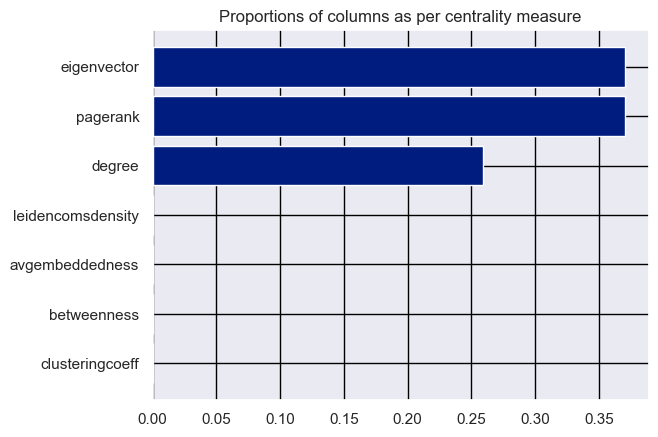

In [91]:
# 27.0 Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

# 27.0.1 Our list of columns

colList = X_train_trans.columns

# 27.0.2 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [92]:
# 27.1 Extract column importance while building model_trans:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 175'

'Columns whose impt is 0: 18'

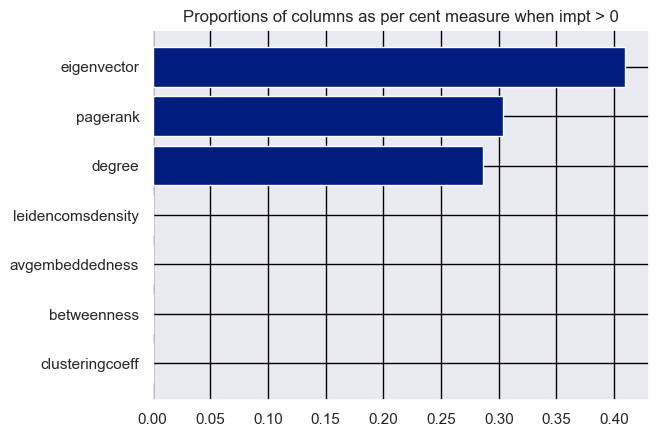

In [93]:
# 27.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:

f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")



### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


deg_app_ck_device_p_ip      0.186500
deg_app_ck_os_p_ip          0.133923
pr_channel_ck_app           0.100080
eig_app_ck_app_p_channel    0.026962
deg_channel_ck_app_p_os     0.016880
Name: imp, dtype: float32

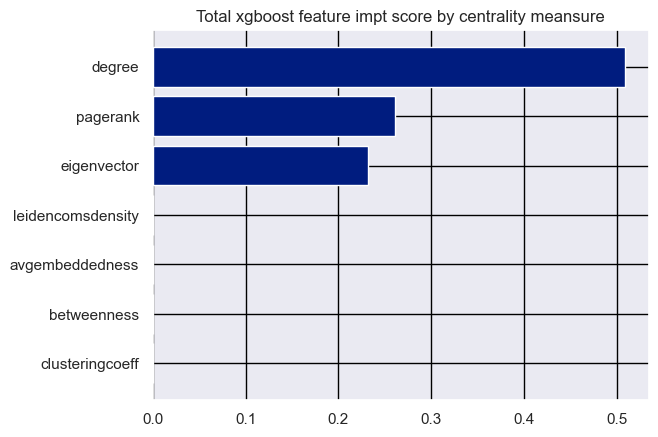

In [94]:
# 27.3 Extract xgboost feature importance:

fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 27.3.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 27.3.2 Score of top-five columns:
score[:5]

# 27.3.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Derive unitvectors per level per cat column
> In what follows in the rest of the notebook we deal only with the transformed data as it is:`X_train_trans` and `X_test_trans` taking ip as a cat feature and NOT numeric feature and its trasformeation as numeric vector is available in the transformed data.)

What is a unit vector?

>We started with a dataframe with five categorical features. These categorical features were transformed into dense vectors. We now intend to extract/separate out dense vectors for each one of these five cat features. What columns constitute dense vectors for each cat?   For a column, say `app`, dense vectors have column-names such as: `'deg_app_ck_channel', 'deg_app_ck_device', 'deg_app_ck_ip', 'deg_app_ck_os'...'pr_app_ck_device', 'pr_app_ck_ip', 'pr_app_ck_os' .....` But not `'pr_app_p_os_ck_ip',  'deg_app_p_channel_ck_os'.. ` as here we have concatenated columns (for example `'deg_app_p_channel_ck_os'` is transformation from concatenated 'app' + 'channel' column. Thus, dense vectord for `'app'` (in our small example limited to few columns) are:<br>

> `df[['deg_app_ck_channel', 'deg_app_ck_device', 'deg_app_ck_ip', 'deg_app_ck_os','pr_app_ck_device', 'pr_app_ck_ip', 'pr_app_ck_os' ]]`<br>
  
>where df is the transformed dataframe.
            
>Dense vectors are extracted for every cat-col, and for every level in the column. If a level occurs multiple times (as it normally would) then there are multiple corresponding rows of vectors. Given a cat col, we first collect in a DataFrame all related columns, as for example below for `'app'` column. Note here that here level '213' occurs twice.

 
                   Example:
                       
                      app   deg_..   pr_...   eig_...
                      213   0.10     0.20     0.11
                      214   0.45     0.18     0.22
                      ...   ...      ...      ...
                      ...   ...      ...      ...
                      213   0.101    0.20     0.10
                      ...   ...      ...      ...
                     
                  If take_mean is True, a final vector for each level
                  of 'app' (213) would be calculated by taking mean of 
                  corresponding rows.
>Once the dataframe is extracted, we apply normalization (`l2` norm) for row-wise normalization. 

>The method, `vectorsToTSV()` , returns a dictionary with keys as column names in cat_cols. For every key, in the dict (say, `'app'`)', value is a dataframe ( `l2` normalized along rows). The dataframe's first column is the cat-col itself (same as the dict key, say, 'app'). <br>   
>A level may have only one row of unit vector (if `take_mean` parameter is `True`) or multiple row vectors at difft row-positions.

### Quick recap

In [95]:
# 28.0 Our folder paths where data/model files are saved:

talkingdata = Path("D:\\talkingdata\\allmodels")
graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"  # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"

In [154]:
# 28.1 A quick readback all saved files:


# 28.2 Data 
X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")

y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")

#  28.3.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

#  28.2.1 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel', 'ip']   # 5
#  28.2.2 Remaining cols not treated as cat cols:
rem_cols =  set(X_train.columns).difference(set(cat_cols))
# 28.2.1 Columns to be considered. Ignore initial cat_cols
numcols = X_train_trans.columns[len(cat_cols):]
# 28.2.4 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], X_train_trans[numcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], X_test_trans[numcols] ], axis = 1)


#  28.2.5 Check
X_train_trans.head(2)
X_test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 28.2.6 Check
X_train_trans.shape   # (3747190, 136)
y_train.shape       # 
X_test_trans.shape    # (1249064, 136)
y_test.shape        # 

# 28.2.7 And read back saved class object:
ct = utils.restorePythonObject("ct.pkl", dataPath)

# 28.2.8 Others, on the way
X_train_trans_imputed = pd.read_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 28.2.9 Check
X_train_trans_imputed.shape  # (3750000, 193)
X_test_trans_imputed.shape   # (1250000, 193)

# 28.2.10 Finally:
X_train_trans.columns
_=gc.collect()

app  device  os  channel      ip  deg_app_ck_channel  \
0    9       1  19      134   99999            0.332528   
1    2       1  19      452  124953            0.288199   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.077216           0.694429                     0.221840   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007488   
1                0.478402  ...           0.005164          0.007488   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019282         0.005648                   0.007871   
1               0.019282         0.005648                   0.007871   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013168              0.005164     0.007802   
1              0.013168              0.005164     0.007802   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  

[2 rows x 194 columns]

app  device  os  channel     ip  deg_app_ck_channel  \
0    9       1  10      258  99999            0.332528   
1    3       1  19      489  99999            0.248232   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.064265           0.819386                     0.188302   
1                 0.093990           0.808023                     0.199141   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.483819  ...           0.005164          0.007248   
1                0.497220  ...           0.005164          0.007488   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.013233         0.005645                   0.007652   
1               0.019282         0.005648                   0.007871   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.011405              0.005164     0.007266   
1              0.013168              0.005164     0.007802   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  

[2 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
0  146824    9       1  19      134    8     8      18       2
1  124953    2       1  19      452    7    14      26      47

ip  app  device  os  channel  day  hour  minute  second
0  188249    9       1  10      258    7    12      21       2
1  249117    3       1  19      489    8     3      44      32

(3750000, 194)

(3750000,)

(1250000, 194)

(1250000,)

(3750000, 193)

(1250000, 193)

Index(['app', 'device', 'os', 'channel', 'ip', 'deg_app_ck_channel',
       'deg_app_ck_channel_p_ip', 'deg_app_ck_device',
       'deg_app_ck_device_p_channel', 'deg_app_ck_device_p_ip',
       ...
       'pr_os_ck_app_p_os', 'pr_os_ck_channel', 'pr_os_ck_channel_p_ip',
       'pr_os_ck_device', 'pr_os_ck_device_p_channel', 'pr_os_ck_device_p_ip',
       'pr_os_ck_device_p_os', 'pr_os_ck_ip', 'pr_os_ck_os_p_channel',
       'pr_os_ck_os_p_ip'],
      dtype='object', length=194)

In [97]:
# 28.3 concat cat columns to imputed data:

X_train_trans_imputed_cat = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed_cat =  pd.concat([X_test[cat_cols], X_test_trans_imputed ],  axis = 1)

In [98]:
# 28.4 Check for nulls:

X_train_trans_imputed_cat.head(2)
X_test_trans_imputed_cat.head(2)
X_train_trans_imputed_cat.isnull().sum().sum()  # 0
X_test_trans_imputed_cat.isnull().sum().sum()   # 0


app  device  os  channel      ip  hour  second  day  minute  \
0    9       1  19      134  146824   8.0     2.0  8.0    18.0   
1    2       1  19      452  124953  14.0    47.0  7.0    26.0   

   deg_app_ck_channel  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0            0.332528  ...           0.005164          0.007488   
1            0.288199  ...           0.005164          0.007488   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019282         0.005648                   0.007871   
1               0.019282         0.005648                   0.007871   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013168              0.005164     0.007802   
1              0.013168              0.005164     0.007802   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  

[2 rows x 198 columns]

app  device  os  channel      ip  hour  second  day  minute  \
0    9       1  10      258  188249  12.0     2.0  7.0    21.0   
1    3       1  19      489  249117   3.0    32.0  8.0    44.0   

   deg_app_ck_channel  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0            0.332528  ...           0.005164          0.007248   
1            0.248232  ...           0.005164          0.007488   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.013233         0.005645                   0.007652   
1               0.019282         0.005648                   0.007871   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.011405              0.005164     0.007266   
1              0.013168              0.005164     0.007802   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005164          0.005164  
1               0.005164          0.005164  

[2 rows x 198 columns]

0

0

In [99]:
# 28.5 Include target data col. Needed for generation of meta-data file below:

X_test_trans_imputed_cat['target'] = y_test.reset_index(drop = True)
X_train_trans_imputed_cat['target'] =  y_train.reset_index(drop = True)
X_train_trans_imputed_cat.columns

Index(['app', 'device', 'os', 'channel', 'ip', 'hour', 'second', 'day',
       'minute', 'deg_app_ck_channel',
       ...
       'pr_os_ck_channel', 'pr_os_ck_channel_p_ip', 'pr_os_ck_device',
       'pr_os_ck_device_p_channel', 'pr_os_ck_device_p_ip',
       'pr_os_ck_device_p_os', 'pr_os_ck_ip', 'pr_os_ck_os_p_channel',
       'pr_os_ck_os_p_ip', 'target'],
      dtype='object', length=199)

### Get unitvectors now

In [101]:
# 29.0 Create folder and a subfolder that we may use:

p = unitvecsPath  # We defined it at the top of notebook
p.mkdir(parents=True, exist_ok=True) # Superfluous code

# 29.1 Extract unit vectors from train data:
gc.collect()
vec_tr,_ = ct.vectorsToTSV(X_train_trans_imputed_cat,
                           take_mean = False,
                           filepath = unitvecsPath ,   # Folder where tsv files will be saved
                           saveVectorsToDisk = True
                           )
_= gc.collect()

0

Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for ip
Checked for channel
Checked for os
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\talkingdata\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [102]:
# 29.2 Unit vectors from test data. But not being saved to file:

vec_te,_ = ct.vectorsToTSV(X_test_trans_imputed_cat,
                           take_mean = False,
                           filepath = unitvecsPath ,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for ip
Checked for channel
Checked for os


### Save/restore unit vectors:

In [103]:
# 29.3 Save unit vecs

utils.savePythonObject(vec_tr, "vec_tr.pkl", dataPath)
utils.savePythonObject(vec_te, "vec_te.pkl",dataPath)

Object saved to: D:\talkingdata\allmodels\datafiles\vec_tr.pkl
Object saved to: D:\talkingdata\allmodels\datafiles\vec_te.pkl


In [104]:
# 29.4 Restore unit-vectors

vec_tr = utils.restorePythonObject( "vec_tr.pkl", dataPath)
vec_te = utils.restorePythonObject("vec_te.pkl",dataPath)
gc.collect()

0

### A quick look
At how the unitvectors get calculated.

In [105]:
# AA
# 30.1 Here is a quick examination of nature of vect_tr:
vec_tr.keys()  # dict_keys(['app', 'device', 'ip', 'channel', 'os'])
type(vec_tr['app'])  # pandas.core.frame.DataFrame
vec_tr['app'].head(2) # Normalized row-wise 
                      # See #28.4.2 in this cell
# BB
# 30.1.1 Following is the same as output of #DD
vec_tr['app'].sum(axis = 1) 

# CC
# 30.1.2 Here is a quick transformation:
cl = vec_tr['app'].columns
cl
# DD
from sklearn.preprocessing import normalize
normalize(X_train_trans_imputed_cat[cl]).sum(axis=1)  # Same as #BB in this cell

dict_keys(['app', 'device', 'ip', 'channel', 'os'])

pandas.core.frame.DataFrame

deg_app_ck_channel  deg_app_ck_channel_p_ip  deg_app_ck_device  \
0            0.173314                 0.033495           0.427066   
1            0.157790                 0.042276           0.380203   

   deg_app_ck_device_p_channel  deg_app_ck_device_p_ip  \
0                     0.098144                0.252168   
1                     0.121458                0.261927   

   deg_app_ck_device_p_os  deg_app_ck_ip  deg_app_ck_os  \
0                0.412612       0.518917       0.439590   
1                0.374282       0.544784       0.468223   

   deg_app_ck_os_p_channel  deg_app_ck_os_p_ip  ...  pr_app_ck_channel  \
0                 0.085604            0.222833  ...           0.003183   
1                 0.119134            0.227498  ...           0.004625   

   pr_app_ck_channel_p_ip  pr_app_ck_device  pr_app_ck_device_p_channel  \
0                0.005036          0.002803                    0.003010   
1                0.007286          0.002506                    0.005016   

   pr_app_ck_device_p_ip  pr_app_ck_device_p_os  pr_app_ck_ip  pr_app_ck_os  \
0               0.006846               0.003094      0.003222      0.003144   
1               0.007094               0.002918      0.003374      0.003443   

   pr_app_ck_os_p_channel  pr_app_ck_os_p_ip  
0                0.003158           0.008922  
1                0.006235           0.009014  

[2 rows x 38 columns]

0          3.108525
1          3.132229
2          3.096497
3          3.129069
4          3.096497
             ...   
3749995    2.901970
3749996    3.132229
3749997    3.108525
3749998    2.896704
3749999    3.132229
Length: 3750000, dtype: float64

Index(['deg_app_ck_channel', 'deg_app_ck_channel_p_ip', 'deg_app_ck_device',
       'deg_app_ck_device_p_channel', 'deg_app_ck_device_p_ip',
       'deg_app_ck_device_p_os', 'deg_app_ck_ip', 'deg_app_ck_os',
       'deg_app_ck_os_p_channel', 'deg_app_ck_os_p_ip',
       'eig_app_ck_app_p_channel', 'eig_app_ck_app_p_device',
       'eig_app_ck_app_p_ip', 'eig_app_ck_app_p_os', 'eig_app_ck_channel',
       'eig_app_ck_channel_p_ip', 'eig_app_ck_device',
       'eig_app_ck_device_p_channel', 'eig_app_ck_device_p_ip',
       'eig_app_ck_device_p_os', 'eig_app_ck_ip', 'eig_app_ck_os',
       'eig_app_ck_os_p_channel', 'eig_app_ck_os_p_ip',
       'pr_app_ck_app_p_channel', 'pr_app_ck_app_p_device',
       'pr_app_ck_app_p_ip', 'pr_app_ck_app_p_os', 'pr_app_ck_channel',
       'pr_app_ck_channel_p_ip', 'pr_app_ck_device',
       'pr_app_ck_device_p_channel', 'pr_app_ck_device_p_ip',
       'pr_app_ck_device_p_os', 'pr_app_ck_ip', 'pr_app_ck_os',
       'pr_app_ck_os_p_channel', 'pr_app_ck_os

array([3.10852506, 3.13222852, 3.0964972 , ..., 3.10852506, 2.89670413,
       3.13222852])

## PCA of unit vectors
>Given a dictionray of dataframes, `vec_tr` and `vec_te`,  the function performs PCA on each dataframe (ie each subset of unitvectors). Thus, PCA is performed separately for unitvectors of each cat-col. Output is concatenation of the PCA transformation for each cat column. This it does for both the dictionaries (train and test) and outputs two dataframes, `cctr` and `ccte`.

In [106]:
# 31.0 Our transformed dataframe:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


# 31.1

cctr.head(3)
ccte.head(3)

# 31.2

cctr.shape   #  (3750000, 20)
ccte.shape   # (1250000, 20)

# 31.3
print(list(cctr.columns[:10]))
print(list(ccte.columns[:10]))

Performing PCA for app for train data
Performing PCA for app for test data
Performing PCA for device for train data
Performing PCA for device for test data
Performing PCA for ip for train data
Performing PCA for ip for test data
Performing PCA for channel for train data
Performing PCA for channel for test data
Performing PCA for os for train data
Performing PCA for os for test data
Concatenating train data
Concatenating test data
Done......


pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -2.075771 -1.244872  2.005000 -0.349074   0.313086  -0.779986   0.011481   
1 -1.391272  0.994217 -3.027271  1.114456   0.313086  -0.779986   0.011481   
2 -2.114787 -0.797769 -0.180358  1.039550   0.313086  -0.779986   0.011481   

   pcdevice3     pcip0     pcip1     pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.015698 -2.631489 -1.218189  0.456958  1.100082   -9.393583    0.123377   
1   0.015698  0.599105 -1.150779 -0.393881 -1.829246   -4.391357    0.460826   
2   0.015698 -2.631489 -1.218189  0.456958  1.100082    0.705554    0.325365   

   pcchannel2  pcchannel3     pcos0    pcos1     pcos2     pcos3  
0    0.186461   -1.586076 -0.408361 -2.52355  0.841832 -1.082932  
1   -0.348598    0.838493 -0.408361 -2.52355  0.841832 -1.082932  
2   -0.552963   -0.389102 -0.285018  0.61412 -0.897894  0.465857

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -2.075771 -1.244872  2.005000 -0.349074   0.313086  -0.779986   0.011481   
1 -2.114787 -0.797769 -0.180358  1.039550   0.313086  -0.779986   0.011481   
2  8.096870  1.725465  0.249140 -2.352473   0.313086  -0.779986   0.011481   

   pcdevice3     pcip0     pcip1     pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.015698 -2.631489 -1.218189  0.456958  1.100082   -0.290767    0.875583   
1   0.015698 -2.631489 -1.218189  0.456958  1.100082   -8.711613    0.745294   
2   0.015698 -1.614301 -1.013870  0.155175 -0.963200    9.163103    0.268077   

   pcchannel2  pcchannel3     pcos0     pcos1     pcos2     pcos3  
0   -1.109591    0.177250 -0.390651  0.576252 -0.211071 -1.074748  
1   -0.393084    0.664177 -0.408361 -2.523550  0.841832 -1.082932  
2    0.308861   -1.396113 -0.378874 -2.170429  1.138435  1.321033

(3750000, 20)

(1250000, 20)

['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcdevice0', 'pcdevice1', 'pcdevice2', 'pcdevice3', 'pcip0', 'pcip1']
['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcdevice0', 'pcdevice1', 'pcdevice2', 'pcdevice3', 'pcip0', 'pcip1']


### Save/readback pca of unitvectors

In [107]:
# 31.4 Save for future work:

cctr.to_pickle(unitvecsPath  / "cctr.pkl")
ccte.to_pickle(unitvecsPath  / "ccte.pkl")

In [108]:
# 31.5 Read back cctr and ccte:

cctr = pd.read_pickle(unitvecsPath  / "cctr.pkl")
ccte = pd.read_pickle(unitvecsPath  / "ccte.pkl")
y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")

In [109]:
# 31.5.1 Check:

cctr.shape    # (3750000, 20)
y_train.shape
ccte.shape   # (1250000, 20)
y_test.shape
cctr.head(3)
ccte.head(3)

(3750000, 20)

(3750000,)

(1250000, 20)

(1250000,)

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -2.075771 -1.244872  2.005000 -0.349074   0.313086  -0.779986   0.011481   
1 -1.391272  0.994217 -3.027271  1.114456   0.313086  -0.779986   0.011481   
2 -2.114787 -0.797769 -0.180358  1.039550   0.313086  -0.779986   0.011481   

   pcdevice3     pcip0     pcip1     pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.015698 -2.631489 -1.218189  0.456958  1.100082   -9.393583    0.123377   
1   0.015698  0.599105 -1.150779 -0.393881 -1.829246   -4.391357    0.460826   
2   0.015698 -2.631489 -1.218189  0.456958  1.100082    0.705554    0.325365   

   pcchannel2  pcchannel3     pcos0    pcos1     pcos2     pcos3  
0    0.186461   -1.586076 -0.408361 -2.52355  0.841832 -1.082932  
1   -0.348598    0.838493 -0.408361 -2.52355  0.841832 -1.082932  
2   -0.552963   -0.389102 -0.285018  0.61412 -0.897894  0.465857

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -2.075771 -1.244872  2.005000 -0.349074   0.313086  -0.779986   0.011481   
1 -2.114787 -0.797769 -0.180358  1.039550   0.313086  -0.779986   0.011481   
2  8.096870  1.725465  0.249140 -2.352473   0.313086  -0.779986   0.011481   

   pcdevice3     pcip0     pcip1     pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.015698 -2.631489 -1.218189  0.456958  1.100082   -0.290767    0.875583   
1   0.015698 -2.631489 -1.218189  0.456958  1.100082   -8.711613    0.745294   
2   0.015698 -1.614301 -1.013870  0.155175 -0.963200    9.163103    0.268077   

   pcchannel2  pcchannel3     pcos0     pcos1     pcos2     pcos3  
0   -1.109591    0.177250 -0.390651  0.576252 -0.211071 -1.074748  
1   -0.393084    0.664177 -0.408361 -2.523550  0.841832 -1.082932  
2    0.308861   -1.396113 -0.378874 -2.170429  1.138435  1.321033

## xgboost modeling with unitvector transformed data
We perform xgboost modeling using `cctr` and `ccte`.   

In [110]:
# 32.0 Perform xgboost modeling using the above train/test data.
#      Note that cctr and ccte DO NOT have time related columns.

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[05:52:53] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:52:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90106	validation_1-auc:0.90431
[05:52:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90108	validation_1-auc:0.90432
[05:53:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90115	validation_1-auc:0.90465
[05:53:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90116	validati

[05:54:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 690 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.92911	validation_1-auc:0.93086
[05:54:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 818 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93272	validation_1-auc:0.93439
[05:54:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 710 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.93272	validation_1-auc:0.93465
[05:54:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 704 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94159	validation_1-auc:0.94273
[05:54:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.96141	validation_1-auc:0.96006
[05:56:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96153	validation_1-auc:0.96009
[05:56:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96157	validation_1-auc:0.96016
[05:56:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96150	validation_1-auc:0.96013
[05:56:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96246	validation_1-auc:0.96066
[05:56:36] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97185	validation_1-auc:0.96504
[05:58:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97237	validation_1-auc:0.96495
[05:58:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97263	validation_1-auc:0.96508
[05:58:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97289	validation_1-auc:0.96510
[05:58:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97335	validation_1-auc:0.96521
[05:58:32] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98267	validation_1-auc:0.96665
[06:00:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98286	validation_1-auc:0.96667
[06:00:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98305	validation_1-auc:0.96667
[06:00:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98316	validation_1-auc:0.96668
[06:00:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98339	validation_1-auc:0.96668
[06:00:34] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.98660	validation_1-auc:0.96678
[06:02:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.98664	validation_1-auc:0.96675
[06:02:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.98670	validation_1-auc:0.96679
[06:02:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.98674	validation_1-auc:0.96678
[06:02:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.98681	validation_1-auc:0.96681
[06:02:32] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [111]:
# 32.0.1 Save model:

utils.savePythonObject(model_vec, "model_vec.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_vec.pkl


In [112]:
# 32.0.2 Restore model:

model_vec = utils.restorePythonObject("model_vec.pkl", estimatorsPath )

In [113]:
# 32.0.3 Best scores :

model_vec.best_score   # 0.96568238049721/0.96692324
print("\n")
model_vec.best_iteration  # 199/164

0.9669232486979303

164

In [114]:
# 32.0.4 Classification report:

pred_vec = model_vec.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.80      0.33      0.46      3079

    accuracy                           1.00   1250000
   macro avg       0.90      0.66      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



## PCA of cctr
PCA plots show the existence of two clusters as before

In [115]:
# 37.0 PCA with transformed train data.
#      Note that n_components = 0.95

pca = PCA(n_components= 0.95,
          whiten= True, 
          random_state = rng
         )

# 37.0.1
pca_train_vec = pca.fit_transform(cctr)
pca_test_vec = pca.transform(ccte)

In [116]:
# 37.0.2 Assign column names and transform to DataFrame:

colnames = ["pc" + str(i) for i in range(pca_train_vec.shape[1])]
pca_train_vec = pd.DataFrame(pca_train_vec, columns = colnames)
pca_test_vec = pd.DataFrame(pca_test_vec, columns = colnames)
pca_train_vec.shape # (3750000, 14)/(3750000, 13)
pca_test_vec.shape # (1250000, 14)/(1250000, 13)

(3750000, 13)

(1250000, 13)

## PCA plot
PCA plot shows existence of two clear clusters.

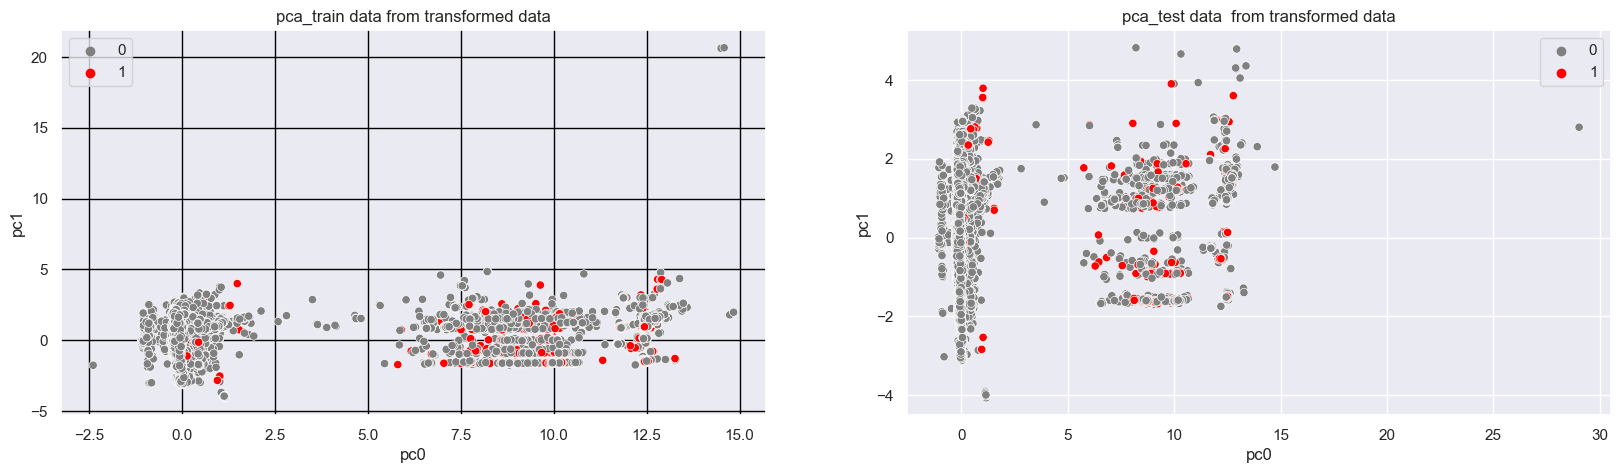

In [117]:
# 38.0 2D PCA plot from first two principal components:


fig = plt.figure(figsize = (20,5));
fig.add_subplot(1,2,1);
sns.set_theme() ; # Set default theme
plt.style.use('seaborn-v0_8-dark-palette')

# 38.0.1 plot pca_train_vec data
sns.scatterplot(data = pca_train_vec,
                x=  'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["grey", "red"]
                ).set(title='pca_train data from transformed data') ;

# 38.0.2 Plot pca_test_vec data
fig.add_subplot(1,2,2);
sns.scatterplot(data = pca_test_vec,
                x=  'pc0',
                y = 'pc1',
                hue = y_test.values,
                palette = ["grey", "red"]
                ).set(title='pca_test data  from transformed data') ;

In [140]:
# 30.1.4 Let us examine the above graph more closely:
#      Merge pca_train_vec and y_train

pcatyt = pd.concat([pca_train_vec, y_train.reset_index(drop = True)],  axis = 1)
pcateyt = pd.concat([pca_test_vec, y_test.reset_index(drop = True)],  axis = 1)

# 30.1.5 Data-points when pc0 > 4.0
pcayt_rt= pcatyt.loc[pcatyt.pc0 > 4.0, :]
pcayte_rt= pcateyt.loc[pcateyt.pc0 > 4.0, :]

nf_rt = pcayt_rt['isattributed'].sum() # 3116
nnf_rt = pcayt_rt.shape[0]  # 27791

# 30.1.6 Ratio of fradulent to non-fraudulent
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_rt/(nnf_rt-nf_rt))  # 12.6%

# 30.1.7 Same calculations for the data on the left
#        Data-points when pc0 <= 4.0
pcayt_lt= pcatyt.loc[pcatyt.pc0 <= 4.0, :]
nf_lt = pcayt_lt['isattributed'].sum() # 3116
nnf_lt = pcayt_lt.shape[0]  # 27791

# 30.1.8 Ratio of fradulent to non-fraudulent points:
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_lt/(nnf_lt-nf_lt))  # 0.0016%

Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.1277098089718824
Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.0016701990385528422


## How good are pc0s in making predictions?
From each unitvector we take the first principal component, ie ['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0'] and make predictions. These five features take us to overall <u>AUC of 0.9620</u>. Thus, effectively, we have reduced five cat columns to five numerical features with one-to-one correspondence between them. We can then evaluate which one is the most important and also perform visualization.

In [118]:
# 31.0 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.S

model_vec_pc0 = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]
test_X =  ccte[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]
ytrain =  y_train
ytest = y_test


model_vec_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[07:20:29] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[07:20:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.88918	validation_1-auc:0.88912
[07:20:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.88922	validation_1-auc:0.88914
[07:20:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.88923	validation_1-auc:0.88915
[07:20:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88924	validati

[07:21:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.91442	validation_1-auc:0.91528
[07:21:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 532 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.91802	validation_1-auc:0.91920
[07:21:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.91808	validation_1-auc:0.91923
[07:21:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.91816	validation_1-auc:0.91930
[07:21:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.94970	validation_1-auc:0.94749
[07:22:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95008	validation_1-auc:0.94788
[07:22:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95039	validation_1-auc:0.94813
[07:22:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 604 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95094	validation_1-auc:0.94874
[07:22:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 564 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95134	validation_1-auc:0.94930
[07:22:35] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.96344	validation_1-auc:0.95900
[07:23:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.96370	validation_1-auc:0.95917
[07:23:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.96401	validation_1-auc:0.95942
[07:23:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.96430	validation_1-auc:0.95968
[07:23:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.96469	validation_1-auc:0.95993
[07:23:42] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.97224	validation_1-auc:0.96214
[07:24:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.97257	validation_1-auc:0.96230
[07:24:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.97269	validation_1-auc:0.96226
[07:24:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.97298	validation_1-auc:0.96241
[07:24:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.97309	validation_1-auc:0.96245
[07:24:54] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.97682	validation_1-auc:0.96396
[07:25:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.97685	validation_1-auc:0.96392
[07:26:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.97695	validation_1-auc:0.96394
[07:26:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.97697	validation_1-auc:0.96395
[07:26:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.97719	validation_1-auc:0.96407
[07:26:06] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.97888	validation_1-auc:0.96449
[07:27:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.97900	validation_1-auc:0.96452
[07:27:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.97904	validation_1-auc:0.96450
[07:27:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.97916	validation_1-auc:0.96452
[07:27:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.97922	validation_1-auc:0.96455
[07:27:17] INFO: C:\Users\dev-admin\croo

[257]	validation_0-auc:0.98056	validation_1-auc:0.96478
[07:28:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.98061	validation_1-auc:0.96479
[07:28:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.98062	validation_1-auc:0.96479
[07:28:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[260]	validation_0-auc:0.98067	validation_1-auc:0.96479
[07:28:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=10
[261]	validation_0-auc:0.98067	validation_1-auc:0.96479
[07:28:28] INFO: C:\Users\dev-admin\croot

[294]	validation_0-auc:0.98218	validation_1-auc:0.96495
[07:29:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.98220	validation_1-auc:0.96495
[07:29:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=10
[296]	validation_0-auc:0.98223	validation_1-auc:0.96495
[07:29:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=10
[297]	validation_0-auc:0.98227	validation_1-auc:0.96496
[07:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[298]	validation_0-auc:0.98231	validation_1-auc:0.96499
[07:29:40] INFO: C:\Users\dev-admin\croo

[331]	validation_0-auc:0.98304	validation_1-auc:0.96497
[07:30:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[332]	validation_0-auc:0.98307	validation_1-auc:0.96497
[07:30:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[333]	validation_0-auc:0.98307	validation_1-auc:0.96495
[07:30:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[334]	validation_0-auc:0.98312	validation_1-auc:0.96499
[07:30:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=10
[335]	validation_0-auc:0.98318	validation_1-auc:0.96497
[07:30:52] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [119]:
# 31.0.1 Save model:

utils.savePythonObject(model_vec_pc0, "model_vec_pc0.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_vec_pc0.pkl


In [120]:
# 31.0.2 Restore model:

model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", estimatorsPath )

134

In [121]:
# 31.0.3 Best scores:

model_vec_pc0.best_score   # 0.9620497969285831/0.965014576747
print("\n")
model_vec_pc0.best_iteration  # 222/301

0.9650145767472756

301

In [122]:
# 31.1 Classification report:

pred_vec = model_vec_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.78      0.33      0.46      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.66      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



### Similarity in feature importance
>There is a good degree of similarity in feature importance from that obtained by unitvectors approach and that by using original data.

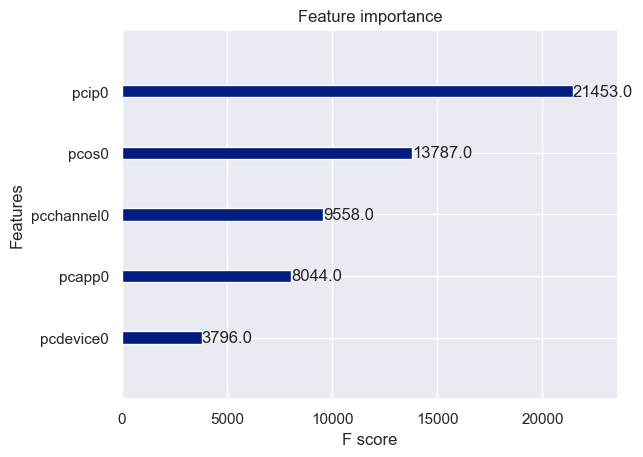

In [123]:
# 31.2 Here is the feature importance of pc0s: 
_=xgb.plot_importance(model_vec_pc0)

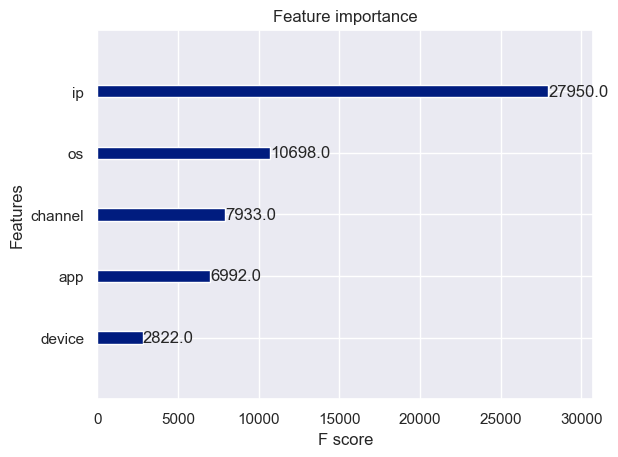

In [124]:
# 31.2.1 Feature importance of cat columns:
_=xgb.plot_importance(model_orig_wt)

### Cleaning up and undersampling pc0s data

In [125]:
# 32.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN  
from imblearn.combine import SMOTEENN

In [126]:
# 32.0.1 Our two daraframe
dtrX =  cctr[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]
dteX =  ccte[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]

In [127]:
# 32.1 Cleanup/Undersample dtrX data:
gc.collect()
start = time.time()
undersample = EditedNearestNeighbours()   
X_res_pc0, y_res_pc0 = undersample.fit_resample(dtrX, y_train.values)
end = time.time()
print((end-start)/60)  # 9min

30

10.412149262428283


In [128]:
# 32.1.1 Data shape
X_res_pc0.shape  #  (3737267, 5)
y_res_pc0.shape  #  (3737267,)

(3731196, 5)

(3731196,)

In [129]:
# 32.1.2 Save above files
X_res_pc0.to_pickle(dataPath / "X_res_pc0.pkl")
y_res_pc0 = pd.DataFrame(y_res_pc0, columns= [ 'isattributed'])
y_res_pc0.to_pickle(dataPath / "y_res_pc0.pkl")
gc.collect()

26

In [130]:
# 32.1.3 Read back
X_res_pc0 = pd.read_pickle(dataPath / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(dataPath / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25

isattributed
0               0.997524
1               0.002476
dtype: float64

0    0.997536
1    0.002464
Name: isattributed, dtype: float64

In [131]:
# 32.2 xgboost Modeling with undersampled data
gc.collect()
model_res_pc0 = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res_pc0 
test_X = dteX
ytrain = y_res_pc0 
ytest =  y_test


model_res_pc0.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )

0

[07:41:50] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[07:41:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.89035	validation_1-auc:0.88860
[07:41:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.89025	validation_1-auc:0.88850
[07:41:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.89009	validation_1-auc:0.88897
[07:41:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.89009	validati

[07:42:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.91927	validation_1-auc:0.91848
[07:42:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.91927	validation_1-auc:0.91855
[07:42:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.91934	validation_1-auc:0.91895
[07:42:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.92245	validation_1-auc:0.92277
[07:42:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95348	validation_1-auc:0.95049
[07:43:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95389	validation_1-auc:0.95087
[07:43:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95419	validation_1-auc:0.95093
[07:43:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95450	validation_1-auc:0.95124
[07:43:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95480	validation_1-auc:0.95167
[07:43:59] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.96614	validation_1-auc:0.95947
[07:45:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.96659	validation_1-auc:0.95958
[07:45:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.96689	validation_1-auc:0.95970
[07:45:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.96732	validation_1-auc:0.95991
[07:45:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.96761	validation_1-auc:0.96010
[07:45:09] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.97515	validation_1-auc:0.96260
[07:46:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.97521	validation_1-auc:0.96257
[07:46:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.97541	validation_1-auc:0.96271
[07:46:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.97549	validation_1-auc:0.96276
[07:46:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.97559	validation_1-auc:0.96284
[07:46:23] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.97936	validation_1-auc:0.96419
[07:47:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.97950	validation_1-auc:0.96428
[07:47:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.97955	validation_1-auc:0.96424
[07:47:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.97963	validation_1-auc:0.96424
[07:47:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.97971	validation_1-auc:0.96418
[07:47:36] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.98149	validation_1-auc:0.96466
[07:48:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.98153	validation_1-auc:0.96465
[07:48:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.98158	validation_1-auc:0.96466
[07:48:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.98161	validation_1-auc:0.96464
[07:48:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.98168	validation_1-auc:0.96462
[07:48:49] INFO: C:\Users\dev-admin\croo

[257]	validation_0-auc:0.98312	validation_1-auc:0.96477
[07:49:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.98316	validation_1-auc:0.96475
[07:49:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.98317	validation_1-auc:0.96476
[07:49:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[260]	validation_0-auc:0.98322	validation_1-auc:0.96477
[07:50:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[261]	validation_0-auc:0.98327	validation_1-auc:0.96478
[07:50:02] INFO: C:\Users\dev-admin\croo

[294]	validation_0-auc:0.98458	validation_1-auc:0.96470
[07:51:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.98458	validation_1-auc:0.96471
[07:51:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=10
[296]	validation_0-auc:0.98458	validation_1-auc:0.96473
[07:51:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[297]	validation_0-auc:0.98467	validation_1-auc:0.96476
[07:51:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[298]	validation_0-auc:0.98468	validation_1-auc:0.96476
[07:51:16] INFO: C:\Users\dev-admin\croo

[331]	validation_0-auc:0.98544	validation_1-auc:0.96464
[07:52:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[332]	validation_0-auc:0.98547	validation_1-auc:0.96460
[07:52:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=10
[333]	validation_0-auc:0.98550	validation_1-auc:0.96458
[07:52:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=10
[334]	validation_0-auc:0.98554	validation_1-auc:0.96460
[07:52:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[335]	validation_0-auc:0.98555	validation_1-auc:0.96459
[07:52:29] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [132]:
# 32.2.1 Save model:

utils.savePythonObject(model_res_pc0, "model_res_pc0.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_res_pc0.pkl


In [133]:
# 32.2.2 Restore model:

model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", estimatorsPath )

In [134]:
# 32.2.3 Best scores without datetime related columns:

model_res_pc0.best_score   # 0.9620497969285831/0.9648068052047499
print("\n")
model_res_pc0.best_iteration  # 222/262

0.9648068052047499

262

In [135]:
# 32.2.4 Classification report:

pred_vec = model_res_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.48      0.54      0.50      3079

    accuracy                           1.00   1250000
   macro avg       0.74      0.77      0.75   1250000
weighted avg       1.00      1.00      1.00   1250000



## Summary: A comparative picture of performance
Let us get a comparative picture of what all we have attempted. Our repeated experiments show that:
> 1. AUC of transformed data is generally or marginally better than with cat columns
> 2. Transformed data can be further processed using imblearn library. After so processing, F1 and kappa scores show marked imporvements over scores obtained from original data.
> 3. USing unitvectors approach, we can reduce transformed columns to as many columns as  the original cat columns with one-to-one relationship between the two.
> 4. These results allow us to plot numeric data in many different ways and examine interrelationships among them.   

In [161]:
# 33.0 Readback all saved files

# 33.0.1 Data 
X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")
y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")

#  33.0.2 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

#  33.0.3 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel', 'ip']   # 5
#  33.0.4 Remaining cols not treated as cat cols:
rem_cols =  set(X_train.columns).difference(set(cat_cols))
# 33.0.5 Columns to be considered. Ignore initial cat_cols
numcols = X_train_trans.columns[len(cat_cols):]
# 33.0.6 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], X_train_trans[numcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], X_test_trans[numcols] ], axis = 1)
 

# 33.0.7 And read back saved class object:
ct = utils.restorePythonObject("ct.pkl", dataPath)

# 33.0.8 Others, on the way
X_train_trans_imputed = pd.read_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 33.0.9 Check
X_train_trans_imputed.shape  # (3750000, 193)
X_test_trans_imputed.shape   # (1250000, 193)

# 33.0.10 Finally:
pc0cols = ['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']
_=gc.collect()

(3750000, 193)

(1250000, 193)

In [162]:
## Our models
#34.1 Model with original data minus time features
model_orig_wt= utils.restorePythonObject("model_orig_wt.pkl", estimatorsPath )
#34.2 Model with original data including time features
model_orig= utils.restorePythonObject("model_orig.pkl", estimatorsPath )
#34.3 Model only with transformed cat cols + time cols
model_trans = utils.restorePythonObject("model_trans.pkl", estimatorsPath )
#34.4 Model with impt features
model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", estimatorsPath )
#34.5 Model after PCA was performed of transformed features (includes time features)
model_pca_orig = utils.restorePythonObject("model_pca_orig.pkl", estimatorsPath )
#34.6 Model after PCA data was cleaned using EditedNearestNeighbours
model_res_orig = utils.restorePythonObject("model_res_orig.pkl", estimatorsPath )
#34.7 Model created using unitvectors
model_vec = utils.restorePythonObject("model_vec.pkl", estimatorsPath )
#34.8 Model created using PC0s of unitvectors
model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", estimatorsPath )
#9 Model created after PC0s of unitvectors were cleaned using EditedNearestNeighbours
model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", estimatorsPath )

In [180]:
# 35.0 An all inclusive comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
re7 = []
re8 = []
re9 = []
cols = ['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']
table = [re1,re2,re3,re4,re5,re6,re7,re8,re9]

# 35.1 Predictions
p1 = model_orig_wt.predict(X_test.iloc[:,:5])
p2=  model_orig.predict(X_test)
p3 = model_trans.predict(X_test_trans)
p4 = model_trans_impt.predict(X_test_trans[fe_1[:150]])
p5 = model_pca_orig.predict(pca_test)
p6 = model_res_orig.predict(pca_test)
p7 = model_vec.predict(ccte)
p8 = model_vec_pc0.predict(ccte[pc0cols])
p9 = model_res_pc0.predict(ccte[pc0cols])

# 35.2 Dataframe Index
str1 = "Original data minus time features"
str2 = "Original data with cat + time features"
str3 = "Modeling Transformed data"
str4 = "Modeling Transformed data with impt features"
str5 = "Modeling with PCAs of transformed data"
str6 = "PCA data cleaned up with EditedNearestNeighbours"
str7 = "Modeling with unitvectors data"
str8 = "Modeling with unitvectors data--Only pc0s"
str9 = "EditedNearestNeighbours transformed unitvectors data--Only pc0s"

# 35.3
re1.append(str1)
re2.append(str2)
re3.append(str3)
re4.append(str4)
re5.append(str5)
re6.append(str6)
re7.append(str7)
re8.append(str8 )
re9.append(str9)


# 35.4 AUC first
s1 = model_orig_wt.best_score
s2=  model_orig.best_score
s3 = model_trans.best_score
s4 = model_trans_impt.best_score
s5 = model_pca_orig.best_score
s6 = model_res_orig.best_score
s7 = model_vec.best_score
s8 = model_vec_pc0.best_score
s9 = model_res_pc0.best_score

# 35.5
re1.append(s1)
re2.append(s2 )
re3.append(s3)
re4.append(s4)
re5.append(s5)
re6.append(s6)
re7.append(s7) 
re8.append(s8)
re9.append(s9)

# 35.6
f1 = f1_score(y_test.values, p1)
f2 = f1_score(y_test.values, p2) 
f3 = f1_score(y_test.values, p3)
f4 = f1_score(y_test.values, p4)
f5 = f1_score(y_test.values, p5)
f6 = f1_score(y_test.values, p6)
f7 = f1_score(y_test.values, p7)
f8 = f1_score(y_test.values, p8)
f9 = f1_score(y_test.values, p9)

# 35.7
re1.append(f1)
re2.append(f2)
re3.append(f3)
re4.append(f4)
re5.append(f5)
re6.append(f6)
re7.append(f7)
re8.append(f8)
re9.append(f9)

# 35.8 kappa score
k1 = cohen_kappa_score(y_test.values,p1)
k2 = cohen_kappa_score(y_test.values,p2) 
k3 = cohen_kappa_score(y_test.values,p3)
k4 = cohen_kappa_score(y_test.values,p4)
k5 = cohen_kappa_score(y_test.values,p5)
k6 = cohen_kappa_score(y_test.values,p6)
k7 = cohen_kappa_score(y_test.values,p7)
k8 = cohen_kappa_score(y_test.values,p8)
k9 = cohen_kappa_score(y_test.values,p9)

# 35.9
re1.append(k1)
re2.append(k2)
re3.append(k3)
re4.append(k4)
re5.append(k5)
re6.append(k6)
re7.append(k7)
re8.append(k8)
re9.append(k9)


# 35.10 Accuracy score
a1 = accuracy_score(y_test.values,p1)
a2 = accuracy_score(y_test.values,p2) 
a3 = accuracy_score(y_test.values,p3)
a4 = accuracy_score(y_test.values,p4)
a5 = accuracy_score(y_test.values,p5)
a6 = accuracy_score(y_test.values,p6)
a7 = accuracy_score(y_test.values,p7)
a8 = accuracy_score(y_test.values,p8)
a9 = accuracy_score(y_test.values,p9)

# 35.11
re1.append(a1)
re2.append(a2)
re3.append(a3)
re4.append(a4)
re5.append(a5)
re6.append(a6)
re7.append(a7)
re8.append(a8)
re9.append(a9)

In [223]:
# 36.0 Print table now
out = pd.DataFrame({"AUC score": [s1,s2,s3,s4,s5,s6,s7,s8,s9] ,
                   "f1 score" : [f1,f2,f3,f4,f5,f6,f7,f8,f9],
                   "kappa score" : [k1,k2,k3,k4,k5,k6,k7,k8,k9],
                   "accuracy" : [a1,a2,a3,a4,a5,a6,a7,a8,a9]},
                    index = [str1,str2,str3,str4,str5,str6,str7,str8,str9])

print(f"\n               lightorange is min of column and lightgreen is max of a columns")
out.style.\
highlight_min(color = 'orange', axis = 0).\
highlight_max(color = 'lightgreen', axis = 0)


               lightorange is min of column and lightgreen is max of a columns


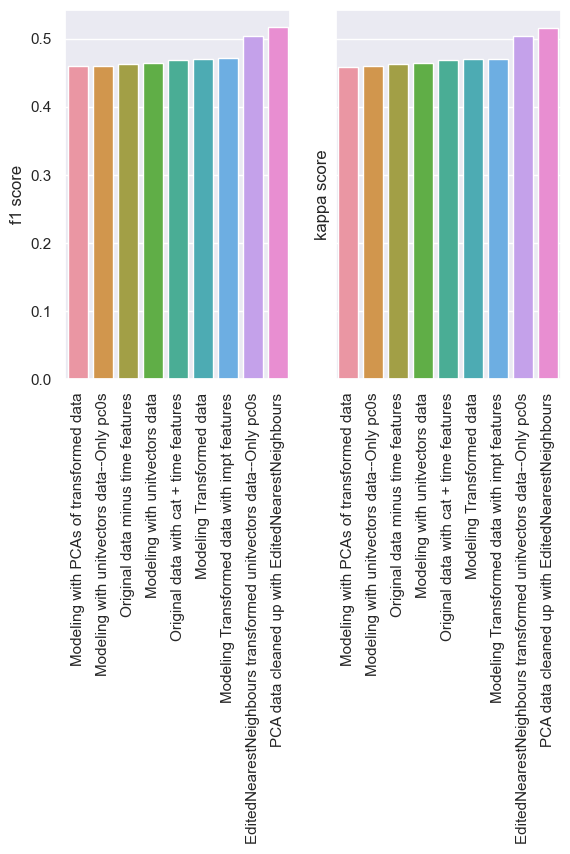

In [222]:
# 37.0 f1 score and kappa score plots
fig,ax = plt.subplots(1,2, sharey = True)
fa = out.sort_values('f1 score')
_=sns.barplot(x = fa.index, y="f1 score", data=fa, ax = ax[0])
_=ax[0].set_xticklabels(fa.index, rotation=90)

# 37.0.1
ka = out.sort_values('kappa score')
_=sns.barplot(x = ka.index, y="kappa score", data=ka, ax = ax[1])
_=ax[1].set_xticklabels(ka.index, rotation=90)


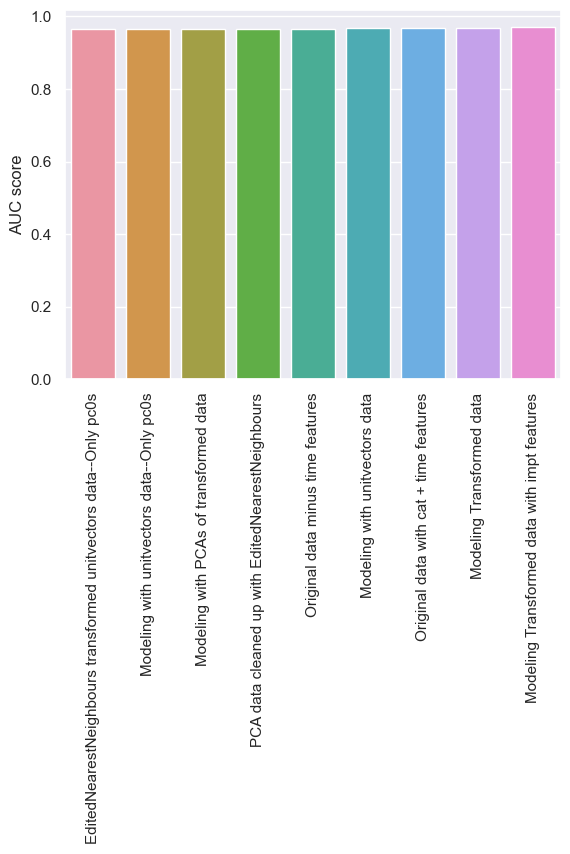

In [220]:
# 37.0.2 And here is a quick comparison of AUC scores
#        Differences here are not much:

out = out.sort_values('AUC score')
_=sns.barplot(x = out.index, y="AUC score", data=out)
_=plt.xticks(rotation=90)

### Density plots of features
>Considering that these five features hold lot of information about the data, let us look at their conditional density plots. As the data is highly unbalanced, we will plot density of each of the two levels independently `(In seaborn: common_norm = False)` (see below). Looking at the density plot of `'pcip0'`, it does not appear that it has that good discrimanating power between frauds and genuine events. Yet, in combination with other features, its predictive powers increases and that is what is reflected in xgboost feature importance diagrams above. 

In [153]:
# 38.0
cctr['target']= y_train.reset_index(drop = True)

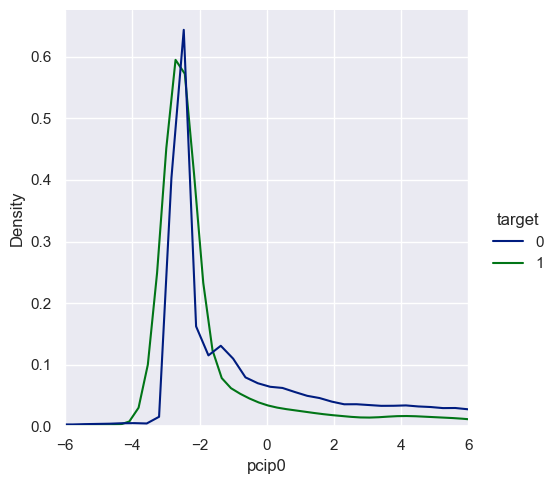

In [154]:
# 38.1 Density plot of 'pcip0':

#_=plt.clf()
_=sns.displot(cctr, x="pcip0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-6, 6)

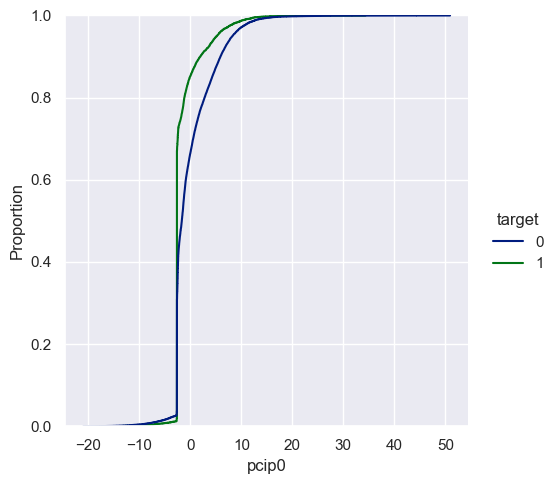

In [155]:
# 38.1.1 ecdf plot of 'pcip0':

#_=plt.clf()
_=sns.displot(cctr, x="pcip0", hue="target", kind = "ecdf")

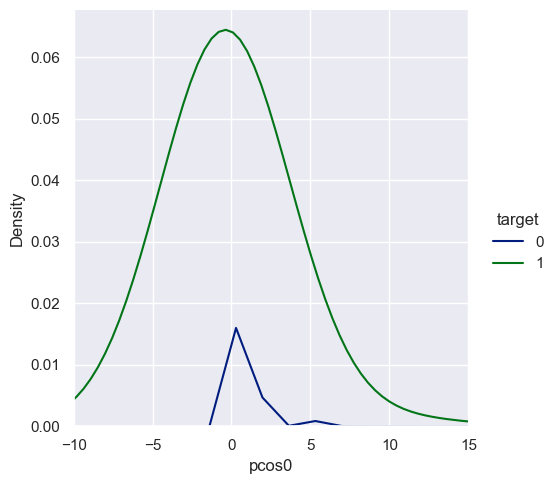

In [156]:
# 38.2 Density plot of 'pcos0':

#_=plt.clf()
_=sns.displot(cctr, x="pcos0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 15)

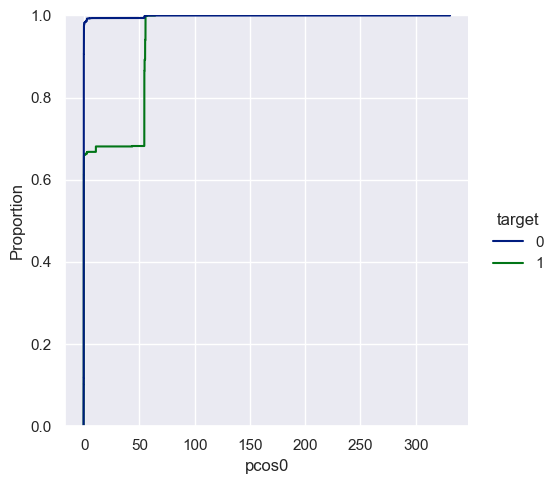

In [157]:
# 38.2.1 ecdf plot of 'pcos0':

#_=plt.clf()
_=sns.displot(cctr, x="pcos0", hue="target", kind = "ecdf")

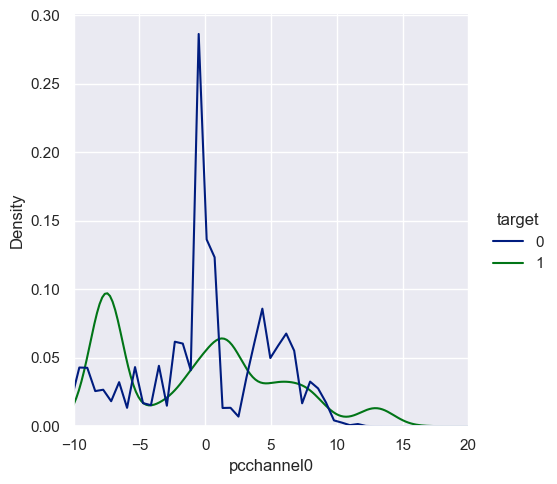

In [158]:
# 38.3 Density plot of 'pcchannel0'
#_=plt.clf()
_=sns.displot(cctr, x="pcchannel0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 20)

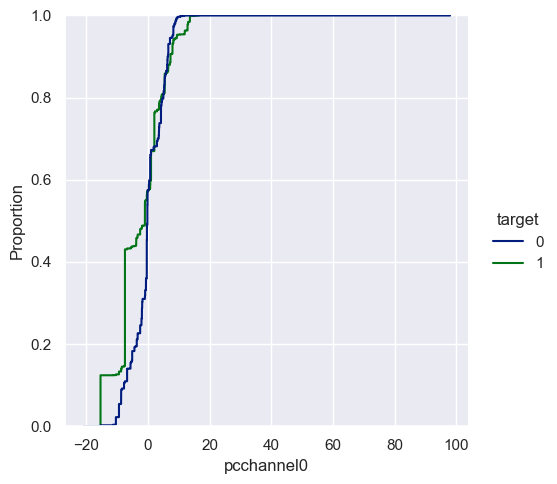

In [159]:
# 38.3.1 ecdf plot of 'pcchannel0':

#_=plt.clf()
_=sns.displot(cctr, x="pcchannel0", hue="target", kind = "ecdf")
#_=plt.xlim(-6, 6)

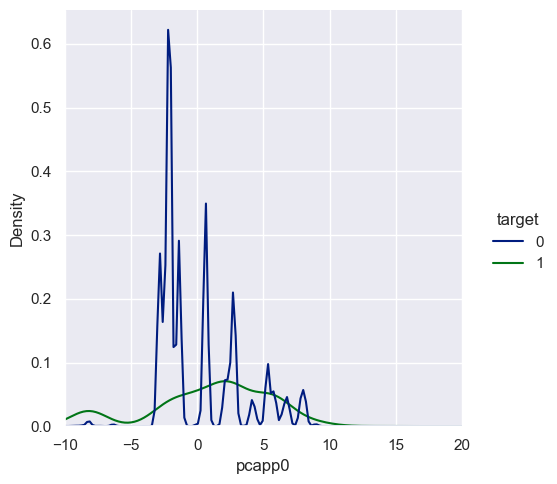

In [160]:
# 38.4 Density plot of pcapp0
#_=plt.clf()
_=sns.displot(cctr, x="pcapp0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 20)

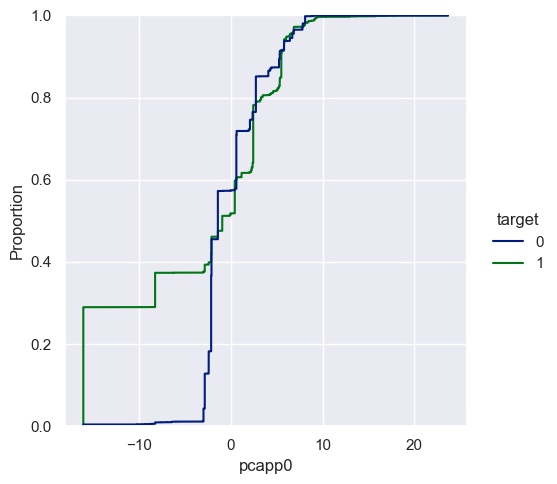

In [161]:
# 38.4.1 ecdf plot of 'pcapp0':

#_=plt.clf()
_=sns.displot(cctr, x="pcapp0", hue="target", kind = "ecdf")
#_=plt.xlim(-6, 6)

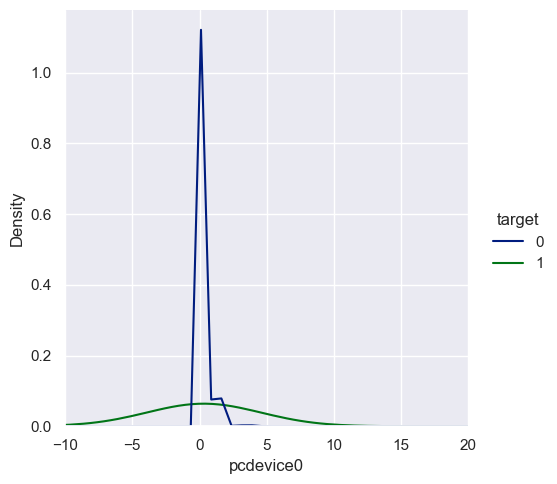

In [162]:
# 38.5 Density plot of pcdevice0:
#_=plt.clf()
_=sns.displot(cctr, x="pcdevice0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 20)

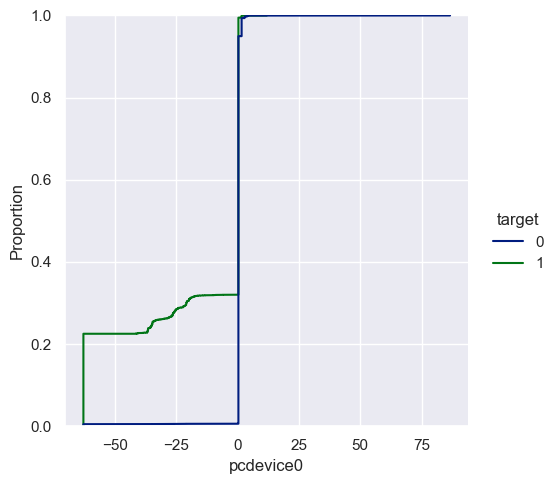

In [163]:
# 38.5.1 ecdf plot of 'pcdevice0':

#_=plt.clf()
_=sns.displot(cctr, x="pcdevice0", hue="target", kind = "ecdf")
#_=plt.xlim(-50, 10)

In [164]:
# 38.5.1.1
_= cctr.pop('target')

## Which levels are impt
>Within features, can we discover levels that do not contribute or contribute very less to fraudulent events. We can use unitvectors to extract this information. For each cat feature, we take the corresponding unitvectors, pc0 and pc1; and make a conditional scatter plot. We then look at regions where no fraudulent activity occurs.

>Given, pc0 and pc1 for a feature, we draw two scatter plots, one for those observations where only genuine events are present and another for fraudulent observations. This way we are able to discover limits or boundaries of fraudulent space.

In [178]:
# 39.0 Scatter plot of pc0 vs pc1 for each set of unitvectors
#      Two scatter plots are drawn
def plotposneg(df,        # It has only two columns pc0 and pc1 (eg for ip pcip0 and pcip1)
               ytrain, 
               ylim0 = None, ylim1 = None, # Upper limits for pc0 and pc1 axis
               x0= None,y0 = None,  # For drawing a line between (x0,y0) to (x1,y1)
               x1=None, y1 = None,
               x00 = None, y00 = None, # For drawing a line between (x00,y00) to (x10,y10)
               x10 =  None,y10=None,
               tx0= None, ty0 = None, # Coord of text to be written: "Genuine trans region"
               linecolor = None,
               titletext = None,  # Graph title text
               vlinepos = None,  # Vertical line pos 
               hlinepos = None   # Horizontal line pos
              ):
    
       
    if ylim0 is None:
        ylim0 = 15
        
    if linecolor is None:
        linecolor = "g"
        
    
    
    
    # 39.0.1 Let us examine the above graph more closely:
    #        Concat df and y_train
    pcatyt = pd.concat([df, ytrain.reset_index(drop = True)],  axis = 1)
    
    # 39.0.2 Patterns in +ve and -ve samples
    # Positive samples
    pca_onlypos = pcatyt.loc[pcatyt.isattributed == 1, :]
    # 39.0.3 Negative samples
    pca_onlyneg = pcatyt.loc[pcatyt.isattributed == 0, :]
    
    # 39.0.4 Separate scatter plots of positive and negatives: 
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize = (10,10));
    plt.style.use('default')
    plt.rc('grid', linestyle="-")
    plt.tight_layout();

    data = pca_onlypos.iloc[:,:-1]
    data1 = pca_onlyneg.iloc[:,:-1]

    _=axs[0].scatter(data.pc0, data.pc1, c="red", alpha=0.5);
    axs[0].grid(True)
    _=axs[0].set_title("Fraudulent events pattern--" + titletext);
    _=axs[0].set_ylabel('pc1');
    _=axs[0].set_facecolor("khaki")

    _=axs[1].scatter(data1.pc0, data1.pc1, c="blue", alpha=0.5);
    _=axs[1].set_title("Genuine events pattern--"+titletext);
    _=axs[1].set_xlabel('pc0');
    _=axs[1].set_ylabel('pc1');
    _=axs[1].set_facecolor("khaki")
   
    # 39.0.5 Draw bounds of fraudulent events
    # https://stackoverflow.com/a/16930526/3282777
    if x0 is not None:
        _=axs[0].plot((x0, x1), (y0, y1),  linewidth = 4, color = linecolor)
        _=axs[1].plot((x0, x1), (y0, y1),  linewidth = 4, color = linecolor)
    if x00 is not None:
       _=axs[0].plot((x00, x10), (y00, y10), 'g-', linewidth = 4)
       _=axs[1].plot((x00, x10), (y00, y10), 'g-', linewidth = 4)

    _=axs[0].set_ylim(top = ylim0)
    _=axs[1].set_ylim(top = ylim1)
     
    if tx0 is not None:
        axs[0].text(tx0,ty0, "Genuine trans region", fontsize = 15)
        axs[1].text(tx0,ty0, "Genuine trans region", fontsize = 15)
        
    if vlinepos is not None:
        axs[0].axvline(x = vlinepos,color = "red")
        axs[1].axvline(x = vlinepos,color = "red")
    if hlinepos is not None:
        axs[0].axhline(y = hlinepos,color = "red")
        axs[1].axhline(y = hlinepos,color = "red")    
        
    axs[1].grid(True)
    plt.show()

In [179]:
# 39.1 Our transformed data with y_train concatenated:

xt = pd.concat([X_train, y_train.reset_index(drop = True)],  axis = 1)
xte = pd.concat([X_test, y_test.reset_index(drop = True)],  axis = 1)
xt.shape  # (3750000, 10)
xt.head()

(3750000, 10)

ip  app  device  os  channel  day  hour  minute  second  isattributed
0    4127    7       1  19      101    7    10      30      55             0
1  331339   12       1  19      245    9     5       0      35             0
2  187444    3       1  13      280    8    17       0      32             0
3    8334   12       1  19      245    7    14      58      27             0
4   59064    3       1   8      409    9     4      49      30             0

In [180]:
# 39.2 This is our complete original data

train_full = pd.read_pickle(dataPath / "train_full.pkl")
train_full.shape  #  (176903891, 8)
train_full['is_attributed'].value_counts(normalize = True)
gc.collect()

(176903891, 8)

0    0.997529
1    0.002471
Name: is_attributed, dtype: float64

0

### Using unitvectors of 'ip'

In [181]:
# 40.0 For our complete train_full data, ratio of frauds to total data is:
train_full.is_attributed.sum()/train_full.shape[0]  # 0.0024

0.0024711723271253544

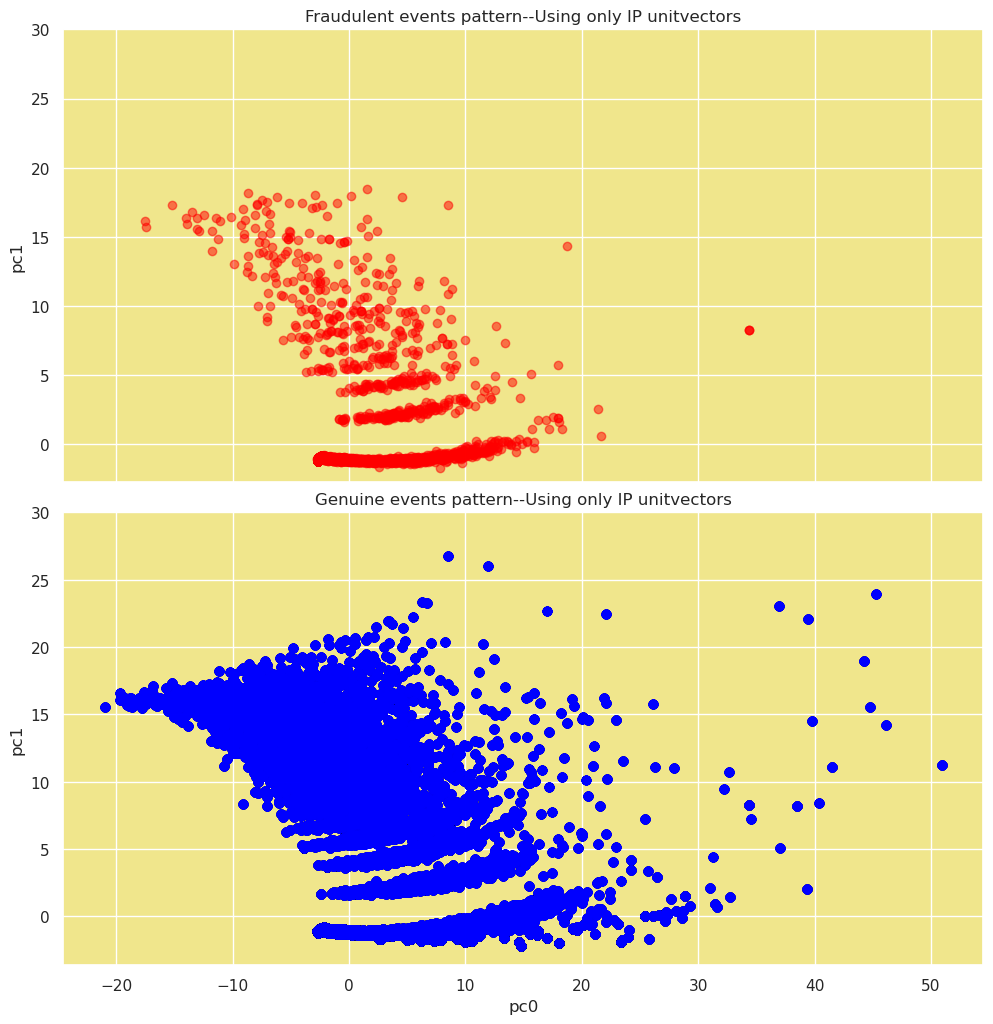

In [182]:
# 40.1 Create a dataframe using pcip0 and pcip1
#      (Two PCs of unitvectors of ip)

df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcip0
df.pc1 = cctr.pcip1

# 40.1.1 Scatter plots to see patterns of genuine/fraud events:

plotposneg(df, y_train, ylim0 = 30, ylim1 = 30, titletext = "Using only IP unitvectors")

In [183]:
# 40.1.2 The area enclosed by following boundaries has very less fraud events
#        but a good amount of genuine clicks.
row_index = cctr.loc[(cctr.pcip0 > 6)   | (cctr.pcip1 > 5),   :].index

# 40.1.3 Extract corresponding rows from xt to check which IPs
#        occur here.
dfx = xt.iloc[row_index]
dfx.shape  # (607765, 10)

# 40.1.4 Extract from train_full rows having those IPs with minimal frauds:
bt = train_full.loc[train_full['ip'].isin(dfx.ip.values)]

# 40.1.5 For such rows what is the ratio of frauds to toal:
print("Ratio of frauds to total data is:" ,  bt.is_attributed.sum()/bt.shape[0])  # 0.0011268221698019828

# 40.1.6 Number of unique IPs to total unique IPs is:
print("Ratio of unique IPs in the less fraud subset to toal unique IPs in the complete data: ", len(dfx['ip'].unique())/len(train_full['ip'].unique()))  # 0.029426272913901038

(620508, 10)

Ratio of frauds to total data is: 0.001111189052923945
Ratio of unique IPs in the less fraud subset to toal unique IPs in the complete data:  0.029885457824025193


In [184]:
# 34.2.1 This is another area of less fraud:
row_index = cctr.loc[(cctr.pcip0 < 6)   | (cctr.pcip1 < 5),   :].index
dfx = xt.iloc[row_index]
dfx.shape
bt = train_full.loc[train_full['ip'].isin(dfx.ip.values)]
print("Ratio of frauds to total data is:" ,  bt.is_attributed.sum()/bt.shape[0])      # 0.0015435745436651448
print("Ratio of unique IPs in the less fraud subset to toal unique IPs in the complete data: ", len(dfx['ip'].unique())/len(train_full['ip'].unique()))  # 0.029426272913901038len(dfx['ip'].unique())/len(train_full['ip'].unique())  # 0.42031729450936867

(3716426, 10)

Ratio of frauds to total data is: 0.001545370638311043
Ratio of unique IPs in the less fraud subset to toal unique IPs in the complete data:  0.4212010057361793


### Using unitvectors of channel

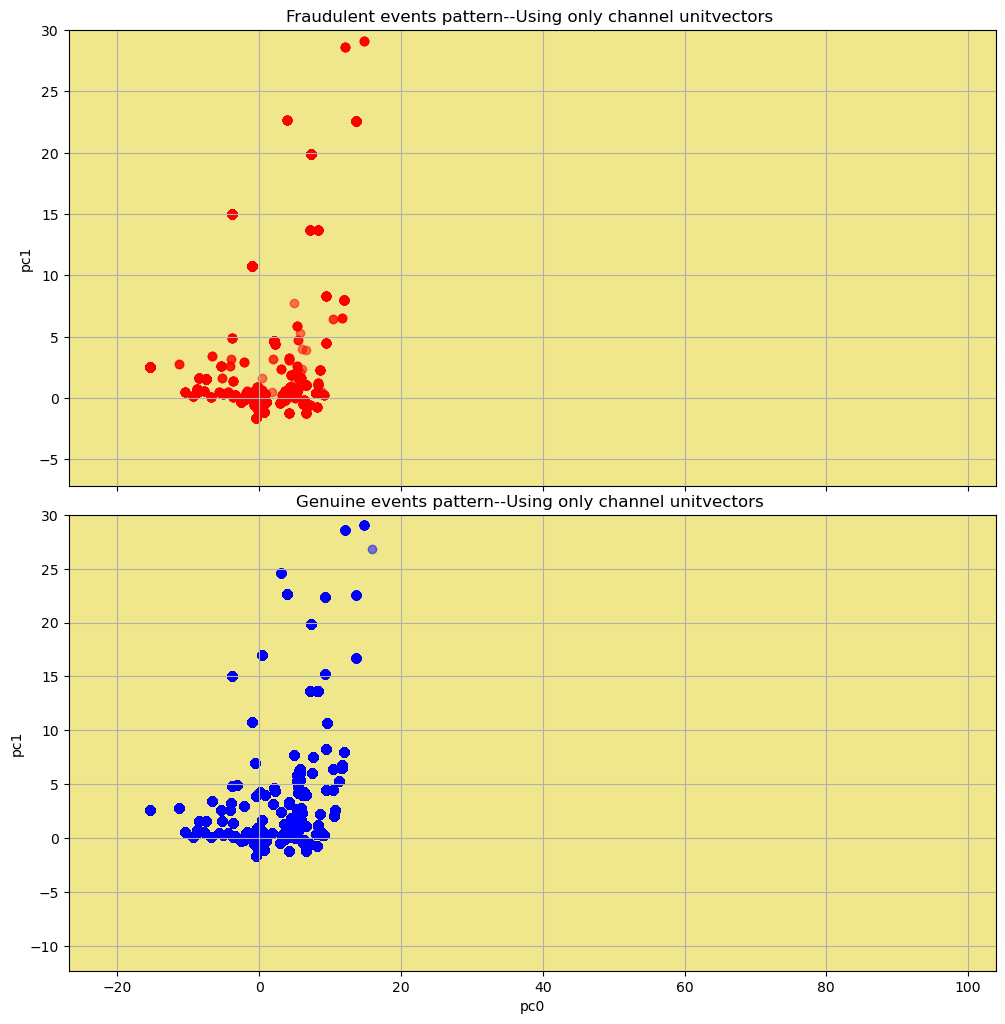

In [185]:
# 41.0 
df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcchannel0
df.pc1 = cctr.pcchannel1

# 41.1  Scatter plots to see patterns of genuine/fraud events:
plotposneg(df, y_train, ylim0 = 30, ylim1 = 30, titletext = "Using only channel unitvectors ")

In the above two patterns, we could not determine regions of no-frauds or less frauds

### Using unitvectors of os

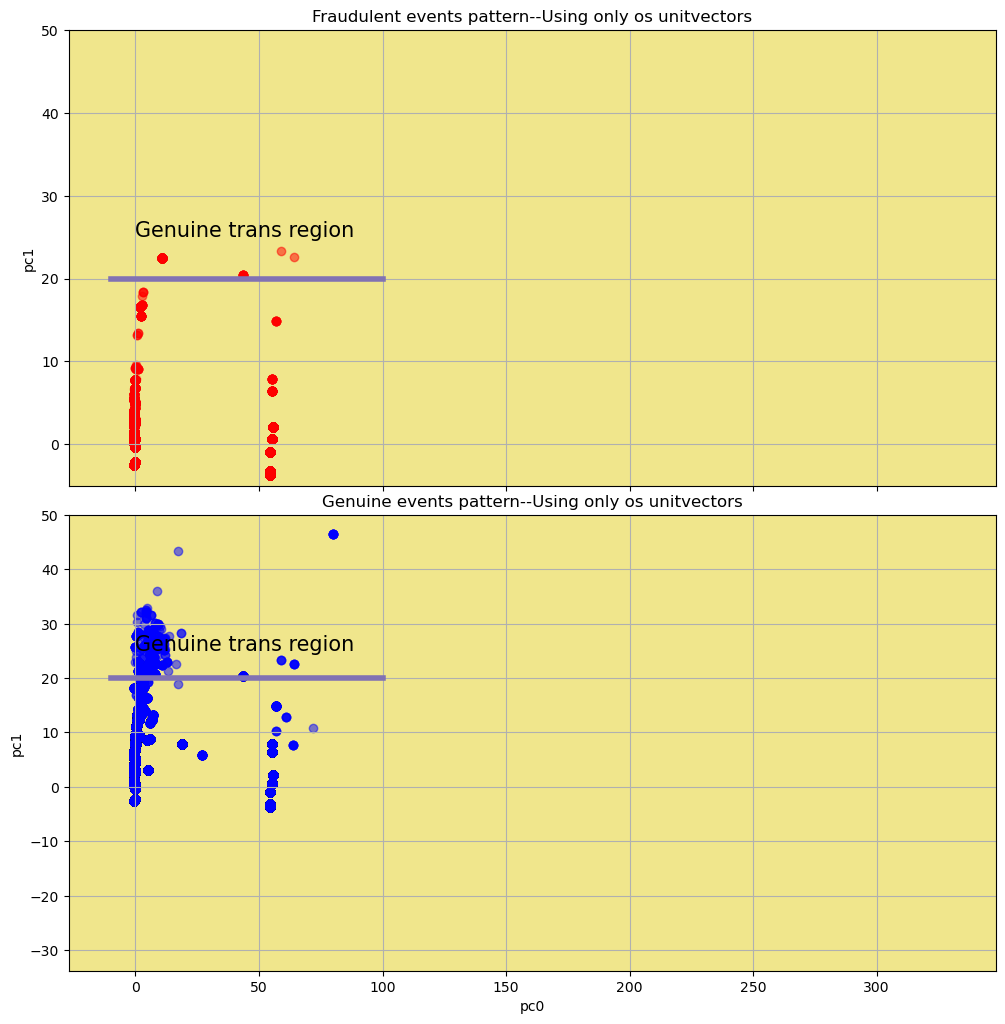

In [186]:
# 42.0
df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcos0
df.pc1 = cctr.pcos1

# 42.0.1 Scatter plots to see patterns of genuine/fraud events:
plotposneg(df, y_train, ylim0 = 50, ylim1 = 50, x0 = -10, y0 = 20, x1 = 100,y1 = 20, tx0 =0, ty0=25, 
           linecolor = "m", titletext = "Using only os unitvectors" )

In [187]:
# 42.1 
row_index = cctr.loc[(cctr.pcos1 >= 20)  & (cctr.pcos0 < 65) , :].index
dfx = xt.iloc[row_index]
dfx.shape
dfx.head()
bt = train_full.loc[train_full['os'].isin(dfx.os.values)]
print("Ratio of frauds to total data is:" , bt.is_attributed.sum()/bt.shape[0]  ) # 0.0008028136707699365
print("Ratio of unique OSs in the less fraud subset to toal unique IOS in the complete data: ", len(dfx['os'].unique())/len(train_full['os'].unique()))  # 0.10466582597730138

(1089, 10)

ip  app  device   os  channel  day  hour  minute  second  \
1867   198612    5       1   61      113    7     3      47       7   
4208    30614   18       1  172      107    7    14      52      23   
9417     5314    2       1  142      477    8    16      53      42   
16190  187410   18       1  198      379    9     5       8      24   
16964  161855   78       0   67      224    7     9      52       1   

       isattributed  
1867              1  
4208              0  
9417              0  
16190             0  
16964             0

Ratio of frauds to total data is: 0.11781037707984642
Ratio of unique OSs in the less fraud subset to toal unique IOS in the complete data:  0.12878787878787878


### USing unitvectors of device

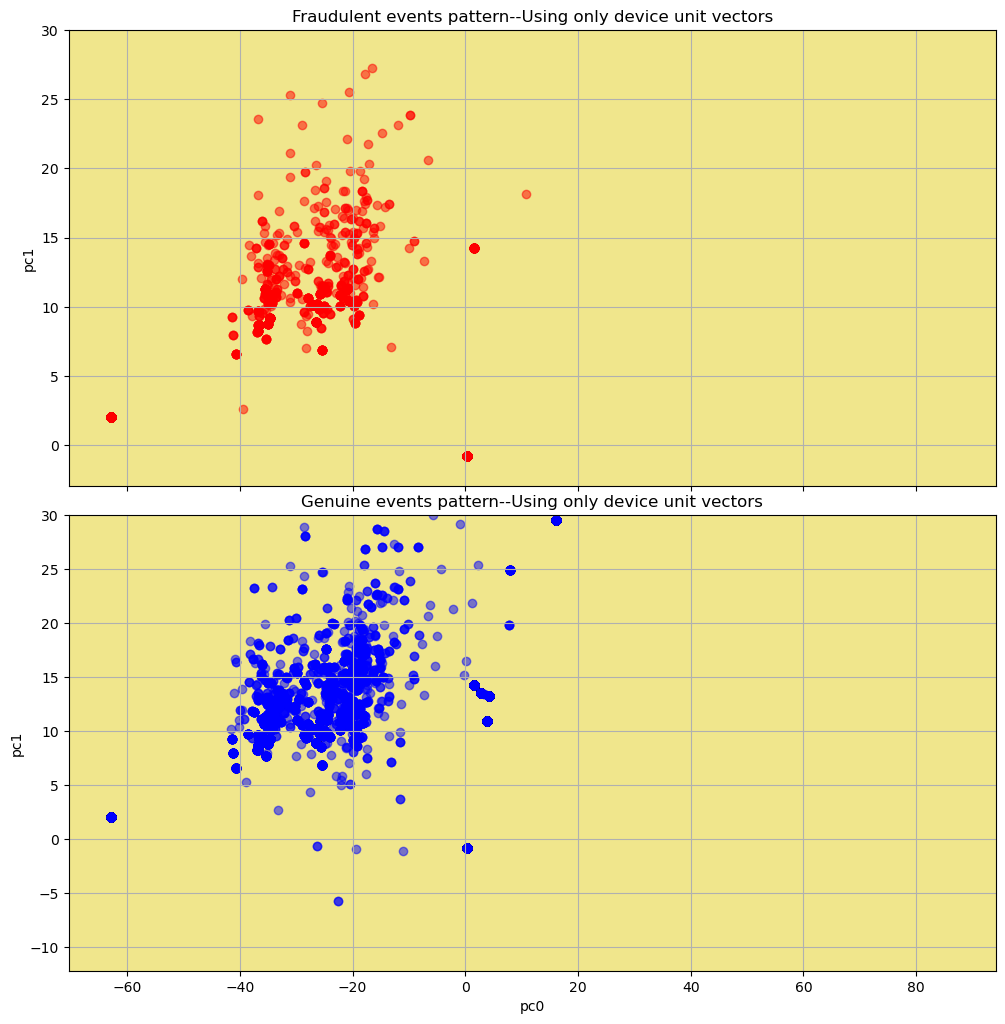

In [188]:
# 43.0
df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcdevice0
df.pc1 = cctr.pcdevice1
plotposneg(df, y_train, ylim0 = 30, ylim1 = 30, titletext = "Using only device unit vectors")

Here also it is difficult to determine regions of non-fraudlent events.

### Using unitvectors of app and channel together
We take all the unitvectors of `app` and `channel` and then take a PCA of them. From the resulting transformation, we pick up pc0 and pc1 for plotting patterns of fraudulent and genuine events.

In [191]:
# 43.1.1 Extract columns of unitvectors pertaining to app and channel:
df = cctr
colList = []
c0 = 'app'
c1 = 'channel'
coCols = [df.columns[i] for i in range(df.shape[1]) if c0 in df.columns[i] ]  
c1Cols = [df.columns[i] for i in range(df.shape[1]) if c1 in df.columns[i] ]  
colList.extend(coCols)
colList.extend(c1Cols)
print(colList)

['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcchannel0', 'pcchannel1', 'pcchannel2', 'pcchannel3']


In [192]:
# 43.1.2 Define a function that takes PCAs of unitvectors of two features, say app and os
colList = []
def twoFields(df,c0,c1):
    """
    df: Dataframe of unitvectors (cctr)
    c0: Cat feature name
    c1: Cat feature name
    """
    coCols = [df.columns[i] for i in range(df.shape[1]) if c0 in df.columns[i] ]  
    c1Cols = [df.columns[i] for i in range(df.shape[1]) if c1 in df.columns[i] ]  
    colList.extend(coCols)
    colList.extend(c1Cols)
    pca = PCA(n_components= 0.95,
          #whiten= True, 
          random_state = rng
         )
    ss = StandardScaler()
    re = pca.fit_transform(ss.fit_transform(cctr[colList]))
    colnames = ["pc" + str(i) for i in range(re.shape[1])]
    re = pd.DataFrame(re, columns = colnames)
    return re
    

In [193]:
# 43.1.3 Apply above function to 'app' and 'os' unitvectors
result = twoFields(cctr,'app','os')
result.head()

pc0       pc1       pc2       pc3       pc4       pc5       pc6
0 -0.237555 -0.096727  1.965638  0.203903  1.074330 -0.559275  0.024836
1 -0.483109  0.487263  1.118065  0.364091  0.914142  0.288299 -0.559154
2 -0.148160 -0.010509  1.087470 -0.360946 -1.248537  0.288784 -0.016876
3 -0.483109  0.487263  1.118065  0.364091  0.914142  0.288299 -0.559154
4 -0.156556 -0.204615  0.064709  0.193719 -0.693872 -0.733977 -0.210983

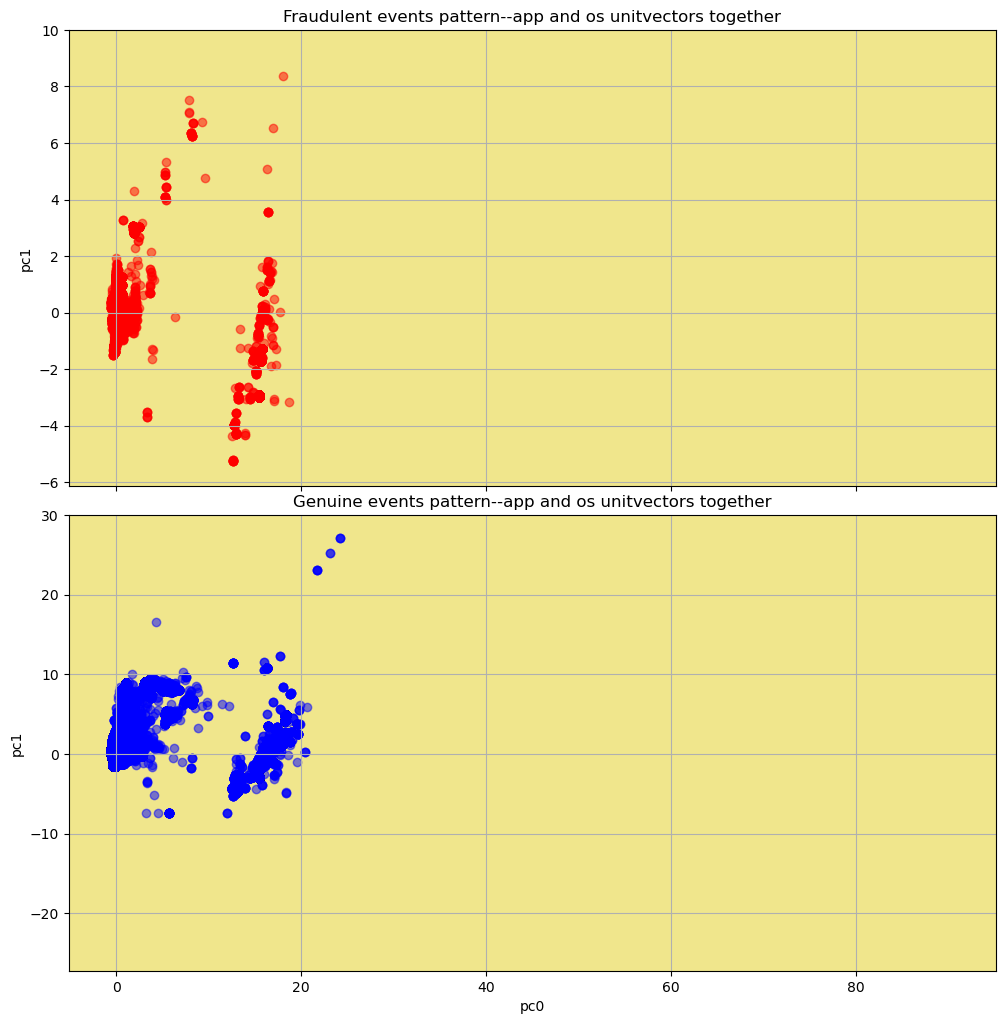

In [194]:
# 43.1.4 See how the scatter plots of genuine and fraudlent events appear:
plotposneg(result, y_train, ylim0 = 10, ylim1 = 30,titletext = "app and os unitvectors together")

In [195]:
# 43.1.5 Extract from train_full data, dataframe of only two features:

bt = train_full[['app','os', 'is_attributed']]
bt.shape # (176903891, 3)

# 39.4.1 How many unique combinations of app and os exist?
denom = bt[['app','os']].drop_duplicates().shape[0]

(176903891, 3)

In [196]:
# 43.1.6 Region of no-frauds as seen from the above graphs
# row_index = cctr.loc[(result.pc1 > 2)    , :].index
#row_index = cctr.loc[((result.pc1 > 5.0) & (result.pc0 <11.0)) | ((result.pc0 > 3.0)  &   (result.pc0 <12) &   (result.pc1 < 0)   )    , :].index
# row_index = cctr.loc[((result.pc1 > 5.0) & (result.pc0 <12.0))    , :].index
row_index = cctr.loc[((result.pc1 > 5.0) & (result.pc0 <12.0))| (result.pc0 >20)    , :].index

In [197]:
# 43.1.7 Filtering a dataframe based upon column values of another dataframe
# We now need to filter bt, based upon columns dfx.app and dfx.os
# Ref https://stackoverflow.com/a/33282617/3282777
# Here is our dataset of no-frauds
dfx = xt.iloc[row_index]
# From dfx get only two columns 'app' and 'os'
dfx = dfx[['app', 'os']]
# Drop duplicate pairs
dfx = dfx.drop_duplicates()
# Now filter bt based upon dfx
keys = list(dfx.columns.values)
i2 = dfx.set_index(keys).index
i1 = bt.set_index(keys).index
sk = bt[i1.isin(i2)]
print("Ratio of frauds to total data is:" , sk.is_attributed.sum()/sk.shape[0]  ) # 0.0011580836506145343
print("Ratio of unique app+os combinations in the less fraud subset to toal unique app+os in the complete data: ", len(dfx)/denom)  # 0.04605793912724606

Ratio of frauds to total data is: 0.0012427618287100674
Ratio of unique app+os combinations in the less fraud subset to toal unique app+os in the complete data:  0.04494712103407755


### Using unitvectors of app and device together
We take all the unitvectors of `app` and `device` and then take a PCA of them. From the resulting transformation, we pick up pc0 and pc1 for plotting patterns of fraudulent and genuine events.

In [198]:
# 44.0 We repeat the same steps as before
result = twoFields(cctr,'app','device')
result.head()

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.338799 -0.113514  1.094924  2.437328 -0.255044  1.078244 -0.285465   
1 -0.698032  0.989998  0.593725  0.770451 -0.492590  1.023538 -0.276079   
2 -0.216340 -0.033702 -0.811934  0.884004 -0.193833  0.253322  1.470107   
3 -0.698032  0.989998  0.593725  0.770451 -0.492590  1.023538 -0.276079   
4 -0.214823 -0.085550 -0.810025  0.863859 -0.319274 -0.354155  0.051843   

        pc7       pc8       pc9  
0  0.009404  0.737143  0.034600  
1  0.115871  0.785594 -0.095232  
2 -0.006688  0.079211  0.091118  
3  0.115871  0.785594 -0.095232  
4 -0.023107 -0.523331 -0.045103

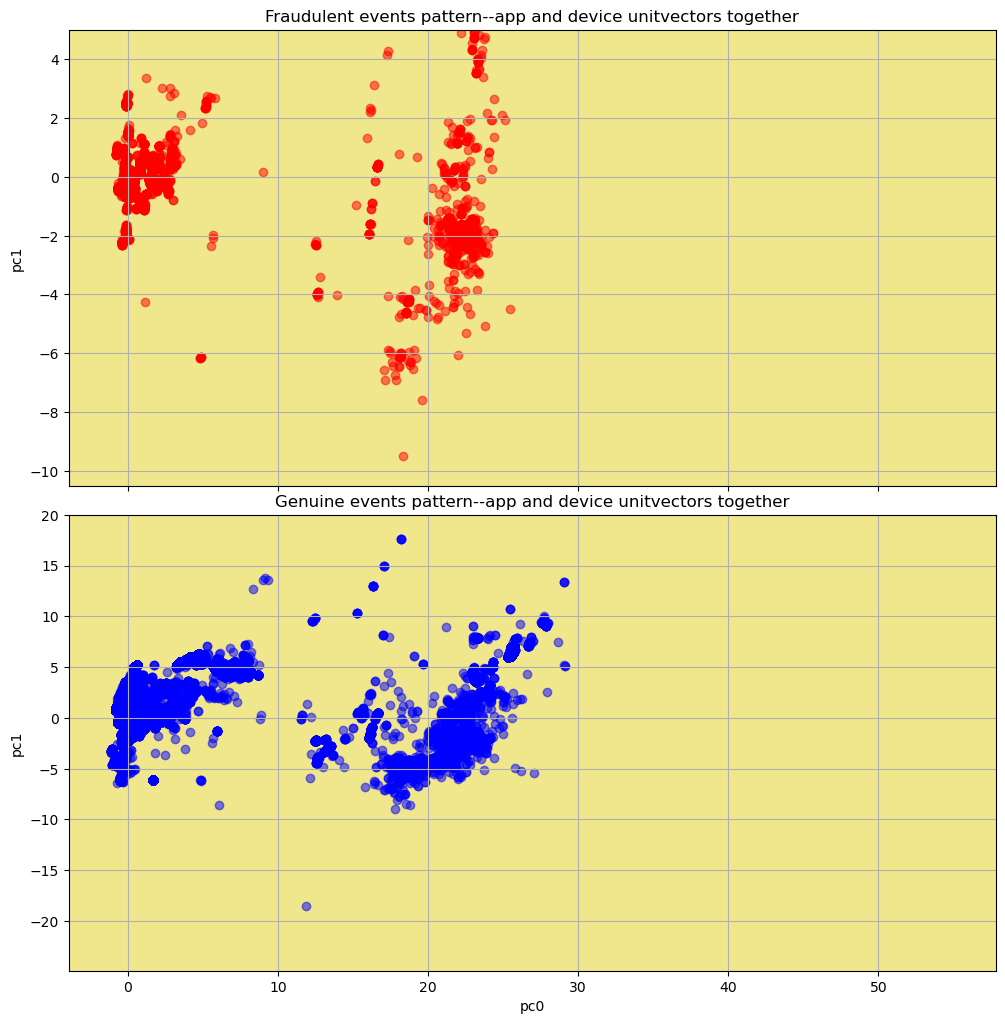

In [199]:
# 44.1
plotposneg(result, y_train, ylim0 = 5, ylim1 = 20, titletext = "app and device unitvectors together")

In [200]:
# 44.2 Some tested filters
row_index = cctr.loc[((result.pc1 > 2.5)  & (result.pc0 < 9)) | (result.pc1 > 1.0 ) | (result.pc0 > 12.2 ) | (result.pc1 < -2 )  , :].index
row_index = cctr.loc[((result.pc1 > 2.0)  & (result.pc0 < 20))   , :].index
row_index = cctr.loc[((result.pc1 > 2.0)  & (result.pc0 < 20)) | ((result.pc1 <-5.0))   , :].index

In [201]:
# 44.3 Same steps as before here:
row_index = cctr.loc[((result.pc1 > 2.0)  & (result.pc0 < 20)) | ((result.pc1 <-5.0))   , :].index
dfx = xt.iloc[row_index]
dfx = dfx[['app', 'device']]
dfx = dfx.drop_duplicates()
dfx.shape  # (679, 2)
bt = train_full[['app','device', 'is_attributed']]
gc.collect()
denom = bt[['app','device']].drop_duplicates().shape[0]

(638, 2)

7174

In [202]:
# 44.4
# https://stackoverflow.com/a/33282617/3282777
keys = list(dfx.columns.values)
i2 = dfx.set_index(keys).index
i1 = bt.set_index(keys).index
sk = bt[i1.isin(i2)]
print("Ratio of frauds to total data is:" , sk.is_attributed.sum()/sk.shape[0]  ) # 0.0008535792276681444
print("Ratio of unique app+device combinations in the less fraud subset to toal unique app+device in the complete data: ", len(dfx)/denom)  # 0.05670146137787056

Ratio of frauds to total data is: 0.0010092039772528947
Ratio of unique app+device combinations in the less fraud subset to toal unique app+device in the complete data:  0.05339805825242718


## Tuning with optuna

### Readback earlier data
Read libraries and folder locations. Then, directly come here.

In [6]:
# 45.0 Readback all saved files

# 45.0.1 Data 
X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")

#  45.0.2 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

#  45.0.3 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel', 'ip']   # 5
#  45.0.4 Remaining cols not treated as cat cols:
rem_cols =  set(X_train.columns).difference(set(cat_cols))
# 45.0.5 Columns to be considered. Ignore initial cat_cols
numcols = X_train_trans.columns[len(cat_cols):]
# 45.0.6 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], X_train_trans[numcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], X_test_trans[numcols] ], axis = 1)
 

# 45.0.7 And read back saved class object:
ct = utils.restorePythonObject("ct.pkl", dataPath)

# 45.0.8 Others, on the way
X_train_trans_imputed = pd.read_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 45.0.9 Check
X_train_trans_imputed.shape  # (3750000, 193)
X_test_trans_imputed.shape   # (1250000, 193)

# 45.0.10 Finally:
pc0cols = ['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']
_=gc.collect()

(3750000, 193)

(1250000, 193)

In [8]:
# 45.1.0 Read back
X_res_pc0 = pd.read_pickle(dataPath / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(dataPath / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 99.75 : 0.25

isattributed
0               0.997524
1               0.002476
dtype: float64

0    0.997536
1    0.002464
Name: isattributed, dtype: float64

In [10]:
# 45.2 Read back cctr and ccte:

cctr = pd.read_pickle(unitvecsPath  / "cctr.pkl")
ccte = pd.read_pickle(unitvecsPath  / "ccte.pkl")
y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")

In [ ]:
# 45.3 Read back:

X_res = pd.read_pickle(dataPath / "X_res_orig.pkl")
y_res = pd.read_pickle(dataPath / "y_res_orig.pkl")
y_res.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25

# 45.4 Read back saved data:

#pca_train = pd.read_pickle(dataPath / "pca_train_orig.pkl")
pca_test =  pd.read_pickle(dataPath / "pca_test_orig.pkl")

# 45.5 Check
#pca_train.head(3)
pca_test.head(3)

### Tuning xgboost hyperparameters for unitvectors of pc0s columns

In [ ]:
# 46.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.


# 46.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_res_pc0 , y_res_pc0)
    # Make predictions
    y_pred = optuna_model.predict(ccte[pc0cols])

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 46.2 Create optuna study
study = optuna.create_study(direction='maximize')

# 46.3 Begin optimization
study.optimize(objective, n_trials=300)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)

[I 2023-12-29 17:50:19,619] A new study created in memory with name: no-name-027e693a-ec01-4451-9be7-1013abd29395
[I 2023-12-29 17:51:31,288] Trial 0 finished with value: 0.24001663893510813 and parameters: {'max_depth': 1, 'learning_rate': 0.5645811687372794, 'n_estimators': 340, 'min_child_weight': 8, 'gamma': 4.183518637163981e-08, 'subsample': 0.996056982388248, 'colsample_bytree': 0.018063771120279883, 'reg_alpha': 0.0004953666422920955, 'reg_lambda': 0.48062068253627166}. Best is trial 0 with value: 0.24001663893510813.
[I 2023-12-29 17:57:51,290] Trial 1 finished with value: 0.46367405804939604 and parameters: {'max_depth': 12, 'learning_rate': 0.054635669077175965, 'n_estimators': 481, 'min_child_weight': 6, 'gamma': 0.0007595892972884657, 'subsample': 0.08934809982542534, 'colsample_bytree': 0.030796272242367327, 'reg_alpha': 2.2652834144791234e-08, 'reg_lambda': 0.000486472304444706}. Best is trial 1 with value: 0.46367405804939604.
[I 2023-12-29 18:03:52,673] Trial 2 finishe

[I 2023-12-29 19:18:55,573] Trial 19 finished with value: 0.48220064724919093 and parameters: {'max_depth': 7, 'learning_rate': 0.10774617124653196, 'n_estimators': 55, 'min_child_weight': 10, 'gamma': 1.843664012724804e-05, 'subsample': 0.5072733129205891, 'colsample_bytree': 0.9498191279829342, 'reg_alpha': 0.00011376519051876387, 'reg_lambda': 0.00011833987862666462}. Best is trial 16 with value: 0.50669952256276.
[I 2023-12-29 19:21:24,442] Trial 20 finished with value: 0.20627557980900407 and parameters: {'max_depth': 10, 'learning_rate': 0.035854561085410415, 'n_estimators': 190, 'min_child_weight': 4, 'gamma': 7.418085267356592e-05, 'subsample': 0.9862662589624366, 'colsample_bytree': 0.16011656786767442, 'reg_alpha': 0.00010897923663636201, 'reg_lambda': 2.10635415510842e-06}. Best is trial 16 with value: 0.50669952256276.
[I 2023-12-29 19:25:33,046] Trial 21 finished with value: 0.5047241694605303 and parameters: {'max_depth': 13, 'learning_rate': 0.07324799063198295, 'n_estim

[I 2023-12-29 20:28:20,308] Trial 38 finished with value: 0.5004703668861713 and parameters: {'max_depth': 10, 'learning_rate': 0.03604971880246759, 'n_estimators': 298, 'min_child_weight': 3, 'gamma': 5.143174078238143e-08, 'subsample': 0.17483969086593965, 'colsample_bytree': 0.7427496516391006, 'reg_alpha': 0.00170338895190611, 'reg_lambda': 0.0004352583817645186}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-29 20:32:11,368] Trial 39 finished with value: 0.5076997892689253 and parameters: {'max_depth': 11, 'learning_rate': 0.0480557475411997, 'n_estimators': 220, 'min_child_weight': 1, 'gamma': 3.991506637213804e-07, 'subsample': 0.20675066793123498, 'colsample_bytree': 0.573213913104107, 'reg_alpha': 0.005790517589389355, 'reg_lambda': 0.003020803639301668}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-29 20:37:23,915] Trial 40 finished with value: 0.5030540328895851 and parameters: {'max_depth': 9, 'learning_rate': 0.028101454929845008, 'n_estimators

[I 2023-12-29 22:32:19,158] Trial 57 finished with value: 0.4977578475336323 and parameters: {'max_depth': 12, 'learning_rate': 0.0704900155398256, 'n_estimators': 495, 'min_child_weight': 1, 'gamma': 1.0157535338204683e-08, 'subsample': 0.34962417111679756, 'colsample_bytree': 0.8410272121831784, 'reg_alpha': 5.3618116520919636e-05, 'reg_lambda': 1.7010349513873987e-05}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-29 22:37:39,513] Trial 58 finished with value: 0.44923807639026325 and parameters: {'max_depth': 9, 'learning_rate': 0.0328205265096901, 'n_estimators': 416, 'min_child_weight': 3, 'gamma': 5.905039085905265e-07, 'subsample': 0.622439636815248, 'colsample_bytree': 0.3151701407527511, 'reg_alpha': 0.00016715956646926446, 'reg_lambda': 4.879289388183053e-06}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-29 22:47:28,647] Trial 59 finished with value: 0.5073529411764706 and parameters: {'max_depth': 13, 'learning_rate': 0.043275025873021226, 'n_est

[I 2023-12-30 00:49:03,432] Trial 76 finished with value: 0.5084539223153085 and parameters: {'max_depth': 12, 'learning_rate': 0.04679801213292363, 'n_estimators': 371, 'min_child_weight': 2, 'gamma': 1.7884224588267692e-08, 'subsample': 0.5296320608232847, 'colsample_bytree': 0.6951459626100197, 'reg_alpha': 0.003889905569592499, 'reg_lambda': 2.858903457318293e-05}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-30 00:57:17,028] Trial 77 finished with value: 0.5043504808426195 and parameters: {'max_depth': 13, 'learning_rate': 0.08737737694934672, 'n_estimators': 347, 'min_child_weight': 2, 'gamma': 1.0278398423100988e-07, 'subsample': 0.4449119510770449, 'colsample_bytree': 0.5433210919132166, 'reg_alpha': 0.0008537779844754622, 'reg_lambda': 5.810944069025667e-05}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-30 01:02:39,538] Trial 78 finished with value: 0.44776714513556615 and parameters: {'max_depth': 14, 'learning_rate': 0.04016606365300118, 'n_esti

[I 2023-12-30 03:04:09,462] Trial 95 finished with value: 0.508556667742977 and parameters: {'max_depth': 12, 'learning_rate': 0.03830095857773062, 'n_estimators': 282, 'min_child_weight': 1, 'gamma': 4.5845562767735786e-07, 'subsample': 0.36128375476531266, 'colsample_bytree': 0.5008640904129903, 'reg_alpha': 0.0004887713531686661, 'reg_lambda': 2.9053207647763013e-05}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-30 03:09:13,065] Trial 96 finished with value: 0.510395175368989 and parameters: {'max_depth': 11, 'learning_rate': 0.06978850847184666, 'n_estimators': 270, 'min_child_weight': 1, 'gamma': 2.0461303306187265e-07, 'subsample': 0.33474894906805197, 'colsample_bytree': 0.5880923828214747, 'reg_alpha': 0.0013645772569227282, 'reg_lambda': 1.1981073373322297e-06}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-30 03:15:06,058] Trial 97 finished with value: 0.5087525626872733 and parameters: {'max_depth': 11, 'learning_rate': 0.07076954768703594, 'n_es

[I 2023-12-30 05:09:54,650] Trial 114 finished with value: 0.508058082016914 and parameters: {'max_depth': 14, 'learning_rate': 0.037122888413515534, 'n_estimators': 337, 'min_child_weight': 1, 'gamma': 1.2995360043098764e-06, 'subsample': 0.3372821573782739, 'colsample_bytree': 0.4727412435654849, 'reg_alpha': 0.0005868853767456479, 'reg_lambda': 6.858082482941101e-06}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-30 05:15:49,271] Trial 115 finished with value: 0.422959406372763 and parameters: {'max_depth': 13, 'learning_rate': 0.029949491870236333, 'n_estimators': 353, 'min_child_weight': 1, 'gamma': 5.8868182804361e-07, 'subsample': 0.38605169446156945, 'colsample_bytree': 0.35767135421533963, 'reg_alpha': 0.0010154754506006614, 'reg_lambda': 4.630526301481271e-06}. Best is trial 33 with value: 0.5110429447852761.
[I 2023-12-30 05:24:26,645] Trial 116 finished with value: 0.510722533817222 and parameters: {'max_depth': 14, 'learning_rate': 0.026602196732024765, 'n_es

[I 2023-12-30 07:57:15,707] Trial 133 finished with value: 0.5085209981740718 and parameters: {'max_depth': 14, 'learning_rate': 0.023606449648021936, 'n_estimators': 439, 'min_child_weight': 1, 'gamma': 1.3754004707818292e-05, 'subsample': 0.6652732922664132, 'colsample_bytree': 0.6091208811501555, 'reg_alpha': 0.00013684251858071011, 'reg_lambda': 5.699047037200578e-07}. Best is trial 118 with value: 0.5117168818747011.
[I 2023-12-30 08:07:02,799] Trial 134 finished with value: 0.5109971886886059 and parameters: {'max_depth': 14, 'learning_rate': 0.02064807528673541, 'n_estimators': 419, 'min_child_weight': 1, 'gamma': 8.063794303254317e-06, 'subsample': 0.7618508225152486, 'colsample_bytree': 0.5589182712612708, 'reg_alpha': 0.00019034742878637113, 'reg_lambda': 8.880590261558107e-07}. Best is trial 118 with value: 0.5117168818747011.
[I 2023-12-30 08:17:36,021] Trial 135 finished with value: 0.5117878192534381 and parameters: {'max_depth': 14, 'learning_rate': 0.02058551675105982, 

[I 2023-12-30 11:11:15,088] Trial 152 finished with value: 0.5111555111555113 and parameters: {'max_depth': 13, 'learning_rate': 0.021027293703855806, 'n_estimators': 408, 'min_child_weight': 1, 'gamma': 3.1021584923749602e-06, 'subsample': 0.655855960300115, 'colsample_bytree': 0.4914008382000259, 'reg_alpha': 2.1482920573987766e-05, 'reg_lambda': 2.2917965524768037e-06}. Best is trial 138 with value: 0.5122151172323333.
[I 2023-12-30 11:20:55,436] Trial 153 finished with value: 0.5115511551155115 and parameters: {'max_depth': 14, 'learning_rate': 0.021027929626781267, 'n_estimators': 423, 'min_child_weight': 1, 'gamma': 3.044231157351749e-06, 'subsample': 0.627982183689809, 'colsample_bytree': 0.5631719335549633, 'reg_alpha': 2.4023333126129292e-05, 'reg_lambda': 4.946673681736631e-07}. Best is trial 138 with value: 0.5122151172323333.
[I 2023-12-30 11:29:56,243] Trial 154 finished with value: 0.5108282360720781 and parameters: {'max_depth': 14, 'learning_rate': 0.02142437924357243, 

 Terminated prematurely:  
 Results:  <br>
 
> 1. Trial 138 finished with value: 0.5122151172323333 and parameters: {'max_depth': 14, 'learning_rate': 0.021062272631236622, 'n_estimators': 439, 'min_child_weight': 1, 'gamma': 7.02110632175883e-06, 'subsample': 0.8456766974304677, 'colsample_bytree': 0.5743007214919201, 'reg_alpha': 7.801336841445003e-05, 'reg_lambda': 9.335171281749697e-07}. Best is trial 138 with value: 0.5122151172323333.

>2. Trial 157 finished with value: 0.5127028356007212 and parameters: {'max_depth': 14, 'learning_rate': 0.022676980482831795, 'n_estimators': 422, 'min_child_weight': 1, 'gamma': 2.5839532775476745e-06, 'subsample': 0.7309691252222392, 'colsample_bytree': 0.5413037876580042, 'reg_alpha': 1.2656711767378713e-05, 'reg_lambda': 2.9929682136591473e-07}. Best is trial 157 with value: 0.5127028356007212.

In [ ]:
 # 47.0 BEst params:
params_pc0 = {'max_depth': 14,
       'learning_rate': 0.022676980482831795,
       'n_estimators': 422,
       'min_child_weight': 1, 
       'gamma: 2.5839532775476745e-06,
       'subsample': 0.7309691252222392,
       'colsample_bytree': 0.5413037876580042,
       'reg_alpha': 1.2656711767378713e-05,
       'reg_lambda': 2.9929682136591473e-07
      }

In [ ]:
# 47.1 fir on data:
s
model_optuna_pc0 = xgb.XGBClassifier(**params_pc0)
model_optuna_pc0.fit(X_res_pc0 , y_res_pc0)


In [ ]:
# 47.2 Classification report:

pred_pc0 = model_optuna_pc0.predict(ccte[pc0cols])
uvec_cl=classification_report(ytest,pred_pc0)
print(uvec_cl)

### Tuning xgboost hyperparameters for original data

In [8]:
# 48.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.


# 48.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train , y_train)
    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 48.2 Create optuna study
study = optuna.create_study(direction='maximize')

# 48.3 Begin optimization
study.optimize(objective, n_trials=200)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)

[I 2023-12-30 15:57:35,908] A new study created in memory with name: no-name-1d375d0b-8ff4-45b6-b590-2084729fbf16
[I 2023-12-30 16:00:06,707] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 13, 'learning_rate': 0.017553497592138357, 'n_estimators': 174, 'min_child_weight': 3, 'gamma': 1.1454872038736955e-08, 'subsample': 0.18009691315854845, 'colsample_bytree': 0.10427548434856022, 'reg_alpha': 0.0018107319451967526, 'reg_lambda': 0.00035992249060647514}. Best is trial 0 with value: 0.0.
[I 2023-12-30 16:02:02,619] Trial 1 finished with value: 0.23624595469255663 and parameters: {'max_depth': 1, 'learning_rate': 0.37897361314488304, 'n_estimators': 416, 'min_child_weight': 8, 'gamma': 7.531194481989502e-05, 'subsample': 0.7709262696540105, 'colsample_bytree': 0.339756296642857, 'reg_alpha': 0.9160937375600103, 'reg_lambda': 1.687549382592048e-08}. Best is trial 1 with value: 0.23624595469255663.
[I 2023-12-30 16:05:18,175] Trial 2 finished with value: 0.10488245931283906

[I 2023-12-30 17:02:56,810] Trial 19 finished with value: 0.4640638864241349 and parameters: {'max_depth': 10, 'learning_rate': 0.36968002319180165, 'n_estimators': 139, 'min_child_weight': 5, 'gamma': 0.0005916055221623337, 'subsample': 0.9646221563896311, 'colsample_bytree': 0.28885165697393383, 'reg_alpha': 2.2934373324230738e-07, 'reg_lambda': 0.9937916200680214}. Best is trial 14 with value: 0.4678998911860719.
[I 2023-12-30 17:06:59,493] Trial 20 finished with value: 0.42550911039657024 and parameters: {'max_depth': 7, 'learning_rate': 0.9764658066778574, 'n_estimators': 279, 'min_child_weight': 7, 'gamma': 0.010830002806226369, 'subsample': 0.3980192221688502, 'colsample_bytree': 0.4647454673843252, 'reg_alpha': 3.8106884811757e-05, 'reg_lambda': 0.002270914798480344}. Best is trial 14 with value: 0.4678998911860719.
[I 2023-12-30 17:09:06,512] Trial 21 finished with value: 0.45595396193005755 and parameters: {'max_depth': 10, 'learning_rate': 0.3612232436727081, 'n_estimators':

[I 2023-12-30 18:28:16,889] Trial 38 finished with value: 0.4702574086091283 and parameters: {'max_depth': 11, 'learning_rate': 0.141409261341488, 'n_estimators': 321, 'min_child_weight': 8, 'gamma': 0.03989200244126286, 'subsample': 0.5313507377961073, 'colsample_bytree': 0.7384247314082314, 'reg_alpha': 1.1704111954402548e-08, 'reg_lambda': 0.0023566879529728305}. Best is trial 33 with value: 0.47449635662237466.
[I 2023-12-30 18:35:04,363] Trial 39 finished with value: 0.45794804051078825 and parameters: {'max_depth': 9, 'learning_rate': 0.08387504591018327, 'n_estimators': 367, 'min_child_weight': 9, 'gamma': 0.21092336467013326, 'subsample': 0.14221483907710536, 'colsample_bytree': 0.7696996257148959, 'reg_alpha': 1.0510914594460282e-07, 'reg_lambda': 0.0006262104587665855}. Best is trial 33 with value: 0.47449635662237466.
[I 2023-12-30 18:41:03,628] Trial 40 finished with value: 0.45687331536388137 and parameters: {'max_depth': 12, 'learning_rate': 0.10346055026852582, 'n_estima

[I 2023-12-30 20:55:30,316] Trial 57 finished with value: 0.4683684794672586 and parameters: {'max_depth': 7, 'learning_rate': 0.12131990604603005, 'n_estimators': 277, 'min_child_weight': 7, 'gamma': 0.013363225687061206, 'subsample': 0.3696479332147095, 'colsample_bytree': 0.8536451048015781, 'reg_alpha': 6.360403094375624e-08, 'reg_lambda': 0.007764600520578646}. Best is trial 33 with value: 0.47449635662237466.
[I 2023-12-30 21:00:40,382] Trial 58 finished with value: 0.46298367255647505 and parameters: {'max_depth': 10, 'learning_rate': 0.08876198689409676, 'n_estimators': 246, 'min_child_weight': 2, 'gamma': 0.10020622585743436, 'subsample': 0.8604234308080086, 'colsample_bytree': 0.5786898769201307, 'reg_alpha': 4.177002751022422e-08, 'reg_lambda': 0.08194719789441647}. Best is trial 33 with value: 0.47449635662237466.
[I 2023-12-30 21:06:42,811] Trial 59 finished with value: 0.468823655453182 and parameters: {'max_depth': 9, 'learning_rate': 0.20774639446146584, 'n_estimators':

[I 2023-12-30 23:00:25,774] Trial 76 finished with value: 0.4644097222222222 and parameters: {'max_depth': 12, 'learning_rate': 0.131684773682681, 'n_estimators': 340, 'min_child_weight': 7, 'gamma': 0.014391649386173558, 'subsample': 0.7777390235740141, 'colsample_bytree': 0.4910717597631268, 'reg_alpha': 1.4024241336246118e-07, 'reg_lambda': 0.12167199069893816}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-30 23:03:57,769] Trial 77 finished with value: 0.4562043795620438 and parameters: {'max_depth': 10, 'learning_rate': 0.0791202040499232, 'n_estimators': 194, 'min_child_weight': 8, 'gamma': 0.001639250258947456, 'subsample': 0.887253099868341, 'colsample_bytree': 0.40012174700177283, 'reg_alpha': 7.389119041422059e-08, 'reg_lambda': 0.02515177614310652}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-30 23:12:18,907] Trial 78 finished with value: 0.4618976862661855 and parameters: {'max_depth': 13, 'learning_rate': 0.1772370809763031, 'n_estimators': 

[I 2023-12-31 00:38:35,651] Trial 95 finished with value: 0.4682884448305821 and parameters: {'max_depth': 10, 'learning_rate': 0.1580348517563846, 'n_estimators': 252, 'min_child_weight': 10, 'gamma': 0.04447964186377485, 'subsample': 0.6929949892699239, 'colsample_bytree': 0.7784490897785723, 'reg_alpha': 2.525569188893367e-07, 'reg_lambda': 0.0058414941483299985}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 00:44:30,106] Trial 96 finished with value: 0.46410537870472 and parameters: {'max_depth': 10, 'learning_rate': 0.1291718095671651, 'n_estimators': 236, 'min_child_weight': 9, 'gamma': 0.007256201197691274, 'subsample': 0.574334705171165, 'colsample_bytree': 0.9462800593996168, 'reg_alpha': 6.60376266419671e-07, 'reg_lambda': 0.025797616129321577}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 00:50:54,724] Trial 97 finished with value: 0.47142549061893463 and parameters: {'max_depth': 10, 'learning_rate': 0.1923642850574999, 'n_estimators': 

[I 2023-12-31 02:37:35,274] Trial 114 finished with value: 0.46812116077102306 and parameters: {'max_depth': 12, 'learning_rate': 0.22171680311632025, 'n_estimators': 313, 'min_child_weight': 8, 'gamma': 0.018144071415464553, 'subsample': 0.7908542100273167, 'colsample_bytree': 0.6055436079605035, 'reg_alpha': 6.679874876014251e-07, 'reg_lambda': 0.1323489068610431}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 02:44:21,254] Trial 115 finished with value: 0.4637175855306167 and parameters: {'max_depth': 11, 'learning_rate': 0.14901259316674736, 'n_estimators': 297, 'min_child_weight': 4, 'gamma': 0.008591046851419556, 'subsample': 0.8102300192847445, 'colsample_bytree': 0.6528688189909857, 'reg_alpha': 1.2908887909455812e-06, 'reg_lambda': 0.350101415301521}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 02:50:56,251] Trial 116 finished with value: 0.47097053726169846 and parameters: {'max_depth': 12, 'learning_rate': 0.16920755158392733, 'n_estimat

[I 2023-12-31 04:36:22,123] Trial 133 finished with value: 0.4634307050296507 and parameters: {'max_depth': 11, 'learning_rate': 0.13237351153860924, 'n_estimators': 369, 'min_child_weight': 8, 'gamma': 0.009818213795779145, 'subsample': 0.9104101686216736, 'colsample_bytree': 0.5107420056506318, 'reg_alpha': 1.8110570487488412e-07, 'reg_lambda': 0.015039458944620119}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 04:42:15,055] Trial 134 finished with value: 0.45721694036300775 and parameters: {'max_depth': 10, 'learning_rate': 0.18693865976551027, 'n_estimators': 260, 'min_child_weight': 9, 'gamma': 0.0028614357106201494, 'subsample': 0.6806979176323704, 'colsample_bytree': 0.6699322607514178, 'reg_alpha': 1.1188480323865354e-07, 'reg_lambda': 0.07533423125611352}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 04:43:53,046] Trial 135 finished with value: 0.3562672004003002 and parameters: {'max_depth': 2, 'learning_rate': 0.10565610820264275, 'n_est

[I 2023-12-31 06:31:29,317] Trial 152 finished with value: 0.47195013357079246 and parameters: {'max_depth': 11, 'learning_rate': 0.0997264522487585, 'n_estimators': 278, 'min_child_weight': 9, 'gamma': 0.00043908403258888007, 'subsample': 0.9959119177015021, 'colsample_bytree': 0.6870623941089568, 'reg_alpha': 1.2889570898669896e-08, 'reg_lambda': 0.5349514284623481}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 06:38:02,272] Trial 153 finished with value: 0.4699115044247787 and parameters: {'max_depth': 11, 'learning_rate': 0.09740819858586079, 'n_estimators': 272, 'min_child_weight': 10, 'gamma': 0.0005653492496138961, 'subsample': 0.7741494871267793, 'colsample_bytree': 0.6985682569888692, 'reg_alpha': 1.076236336916552e-08, 'reg_lambda': 0.5209298330808716}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 06:45:04,358] Trial 154 finished with value: 0.4719150818222025 and parameters: {'max_depth': 11, 'learning_rate': 0.08318688079416128, 'n_esti

[I 2023-12-31 08:40:04,532] Trial 171 finished with value: 0.33074131674442714 and parameters: {'max_depth': 11, 'learning_rate': 0.06802312932271516, 'n_estimators': 239, 'min_child_weight': 8, 'gamma': 0.0006743496062547062, 'subsample': 0.8265789220165921, 'colsample_bytree': 0.09925998667723712, 'reg_alpha': 0.00032744126424678237, 'reg_lambda': 0.4485771271096499}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 08:45:36,251] Trial 172 finished with value: 0.460576278758097 and parameters: {'max_depth': 11, 'learning_rate': 0.0766968563113713, 'n_estimators': 261, 'min_child_weight': 8, 'gamma': 0.0008842853209308412, 'subsample': 0.23689014305103337, 'colsample_bytree': 0.6229584717472618, 'reg_alpha': 3.064909541716517e-06, 'reg_lambda': 0.5433047607182769}. Best is trial 61 with value: 0.47677364864864863.
[I 2023-12-31 08:50:22,380] Trial 173 finished with value: 0.46586345381526106 and parameters: {'max_depth': 11, 'learning_rate': 0.08662062234117496, 'n_esti

[I 2023-12-31 10:53:08,055] Trial 190 finished with value: 0.46449307726663686 and parameters: {'max_depth': 12, 'learning_rate': 0.07388122951065053, 'n_estimators': 308, 'min_child_weight': 10, 'gamma': 5.580130740865013e-05, 'subsample': 0.7796096559100938, 'colsample_bytree': 0.6626113469451933, 'reg_alpha': 1.5551123272472e-07, 'reg_lambda': 0.003843321462096832}. Best is trial 186 with value: 0.4773735581188997.
[I 2023-12-31 10:59:08,497] Trial 191 finished with value: 0.4666666666666667 and parameters: {'max_depth': 11, 'learning_rate': 0.06756683905110396, 'n_estimators': 290, 'min_child_weight': 9, 'gamma': 0.0042196253636772405, 'subsample': 0.9249088205597003, 'colsample_bytree': 0.5225968880949282, 'reg_alpha': 7.55776944210389e-07, 'reg_lambda': 0.6631704921812688}. Best is trial 186 with value: 0.4773735581188997.
[I 2023-12-31 11:04:56,620] Trial 192 finished with value: 0.4697747044389917 and parameters: {'max_depth': 11, 'learning_rate': 0.08803407272120758, 'n_estima

Terminated prematurely  <br>
Results  <br>

Trial 186 finished with value: 0.4773735581188997 and parameters: {'max_depth': 12, 'learning_rate': 0.07633796781465818, 'n_estimators': 317, 'min_child_weight': 10, 'gamma': 0.007375161120383889, 'subsample': 0.9105539931412577, 'colsample_bytree': 0.6526984364552133, 'reg_alpha': 5.136572332442896e-07, 'reg_lambda': 0.3703096576156581}. Best is trial 186 with value: 0.4773735581188997.

In [ ]:
# 49 Best parameters:
params_orig = {'max_depth': 12,
          'learning_rate': 0.07633796781465818,
          'n_estimators': 317,
          'min_child_weight': 10,
          'gamma': 0.007375161120383889,
          'subsample': 0.9105539931412577,
          'colsample_bytree': 0.6526984364552133,
          'reg_alpha': 5.136572332442896e-07,
          'reg_lambda': 0.3703096576156581}


In [ ]:
# 49.1 Fit on data:
model_optuna_orig = xgb.XGBClassifier(**params)
model_optuna_orig.fit(X_train , y_train)

In [ ]:
# 49.2 MAke predictions:
pred_orig = model_optuna_pc0.predict(X_test)
uvec_cl=classification_report(ytest,pred_orig)
print(uvec_cl)

### Tuning xgboost hyperparameters for cleaned up pca data
pca data cleaned up using EditedNearestNeighbours approach

In [ ]:
# 50.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.


# 50.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_res , y_res)
    # Make predictions
    y_pred = optuna_model.predict(pca_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 50.2 Create optuna study
study = optuna.create_study(direction='maximize')

# 50.3 Begin optimization
study.optimize(objective, n_trials=200)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)

[I 2023-12-31 12:09:19,446] A new study created in memory with name: no-name-f5e4e715-6c7c-47c7-8355-046126af8e1b
[I 2023-12-31 12:14:08,326] Trial 0 finished with value: 0.5036867114533836 and parameters: {'max_depth': 4, 'learning_rate': 0.12190600528751186, 'n_estimators': 380, 'min_child_weight': 7, 'gamma': 0.2465124111320065, 'subsample': 0.18765296757900438, 'colsample_bytree': 0.22176059433492912, 'reg_alpha': 0.24138417069635756, 'reg_lambda': 2.870514999545052e-07}. Best is trial 0 with value: 0.5036867114533836.
[I 2023-12-31 12:33:01,946] Trial 1 finished with value: 0.5140232901426931 and parameters: {'max_depth': 14, 'learning_rate': 0.015911879610298347, 'n_estimators': 385, 'min_child_weight': 5, 'gamma': 0.0037444862098173965, 'subsample': 0.3860472408797927, 'colsample_bytree': 0.27114711528699353, 'reg_alpha': 7.980260480567591e-06, 'reg_lambda': 0.02868402176255273}. Best is trial 1 with value: 0.5140232901426931.
[I 2023-12-31 12:48:49,916] Trial 2 finished with va

[I 2023-12-31 16:40:47,781] Trial 19 finished with value: 0.5102853351028533 and parameters: {'max_depth': 6, 'learning_rate': 0.03294367420297439, 'n_estimators': 224, 'min_child_weight': 6, 'gamma': 0.6275020470753451, 'subsample': 0.5829704531925679, 'colsample_bytree': 0.5616001715813691, 'reg_alpha': 1.2444835525348996e-06, 'reg_lambda': 0.9407047707980932}. Best is trial 11 with value: 0.5148737739186364.
[I 2023-12-31 16:59:36,543] Trial 20 finished with value: 0.5123994087699129 and parameters: {'max_depth': 10, 'learning_rate': 0.012951003383695876, 'n_estimators': 420, 'min_child_weight': 4, 'gamma': 1.591087898368833e-06, 'subsample': 0.6980516011728403, 'colsample_bytree': 0.3390808428328985, 'reg_alpha': 7.777784080559595e-08, 'reg_lambda': 0.0022345141915586994}. Best is trial 11 with value: 0.5148737739186364.
[I 2023-12-31 17:18:48,314] Trial 21 finished with value: 0.5150270980456562 and parameters: {'max_depth': 14, 'learning_rate': 0.015945830774635135, 'n_estimators

[I 2024-01-01 00:39:39,479] Trial 38 finished with value: 0.5163577759871072 and parameters: {'max_depth': 11, 'learning_rate': 0.013602180746831812, 'n_estimators': 429, 'min_child_weight': 8, 'gamma': 0.05708970201034507, 'subsample': 0.5114019142700006, 'colsample_bytree': 0.8542300861311339, 'reg_alpha': 5.347552591968169e-08, 'reg_lambda': 0.00019571008704398927}. Best is trial 38 with value: 0.5163577759871072.
[I 2024-01-01 01:19:02,420] Trial 39 finished with value: 0.5122069523039612 and parameters: {'max_depth': 9, 'learning_rate': 0.012429205184700884, 'n_estimators': 442, 'min_child_weight': 8, 'gamma': 0.060992053841294705, 'subsample': 0.5040627054848146, 'colsample_bytree': 0.9698037001982984, 'reg_alpha': 3.474712871944074e-08, 'reg_lambda': 0.0001968479306333112}. Best is trial 38 with value: 0.5163577759871072.
[I 2024-01-01 01:32:10,166] Trial 40 finished with value: 0.5061334229541253 and parameters: {'max_depth': 8, 'learning_rate': 0.013201206301201494, 'n_estimat

[I 2024-01-01 09:51:29,263] Trial 57 finished with value: 0.5140935297885969 and parameters: {'max_depth': 13, 'learning_rate': 0.03915078479050913, 'n_estimators': 428, 'min_child_weight': 6, 'gamma': 0.2514121922863169, 'subsample': 0.8016076991383145, 'colsample_bytree': 0.3640863050747198, 'reg_alpha': 4.715171003194503e-07, 'reg_lambda': 0.005179792734669287}. Best is trial 51 with value: 0.5164605749156899.
[I 2024-01-01 10:08:31,578] Trial 58 finished with value: 0.5112313494015412 and parameters: {'max_depth': 10, 'learning_rate': 0.014370123149906391, 'n_estimators': 403, 'min_child_weight': 7, 'gamma': 0.047258685974843125, 'subsample': 0.3854927849207205, 'colsample_bytree': 0.4342497908805171, 'reg_alpha': 6.185824488387549e-08, 'reg_lambda': 0.0017040910515445365}. Best is trial 51 with value: 0.5164605749156899.
[I 2024-01-01 10:32:37,449] Trial 59 finished with value: 0.5137495956001293 and parameters: {'max_depth': 11, 'learning_rate': 0.02652095229645635, 'n_estimators

Terminated prematurely:   
Results   <br>

>1. Trial 51 finished with value: 0.5164605749156899 and parameters: {'max_depth': 13, 'learning_rate': 0.018751782294887095, 'n_estimators': 429, 'min_child_weight': 6, 'gamma': 0.2543870779425533, 'subsample': 0.38473249554013034, 'colsample_bytree': 0.6435350398787767, 'reg_alpha': 2.5652465700379932e-08, 'reg_lambda': 0.0006988639330224303}. Best is trial 51 with value: 0.5164605749156899.   <br><br>  

> 2. Trial 65 finished with value: 0.5171078114912847 and parameters: {'max_depth': 7, 'learning_rate': 0.030689450148025075, 'n_estimators': 475, 'min_child_weight': 8, 'gamma': 0.9533620804391095, 'subsample': 0.6802684463476397, 'colsample_bytree': 0.6620017109437362, 'reg_alpha': 4.756391888451014e-08, 'reg_lambda': 0.0015272459190703034}. Best is trial 65 with value: 0.5171078114912847

In [ ]:
# 51.0 BEst parameters
params_pca = {'max_depth': 7,
           'learning_rate': 0.030689450148025075,
           'n_estimators': 475,
           'min_child_weight': 8,
           'gamma': 0.9533620804391095,
           'subsample': 0.6802684463476397,
           'colsample_bytree': 0.6620017109437362,
           'reg_alpha': 4.756391888451014e-08, 
           'reg_lambda': 0.0015272459190703034
          }

In [ ]:
# 51.1 Fit on data
model_optuna_en = xgb.XGBClassifier(**params_pca)
model_optuna_en.fit(X_train , y_train)

In [ ]:
# 51.2 Classification report
pred_pca = model_optuna_pc0.predict(pca_test)
uvec_cl=classification_report(ytest,pred_pca)
print(uvec_cl)

## Analysing Graphs


In [167]:
# Transfer all*.gml files to graphsPath

for file in modelsPath.glob("*.gml"):
    folder_name = graphsPath 
    file.rename( folder_name / file.name)

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_os_p_ip.gml')

In [168]:
# 21.0 Path where .gml files are placed:


filelist = sorted(list(graphsPath .iterdir()))
filelist[5:10]   


[WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_channel_p_ip.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_channel.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_ip.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_os.gml')]

### Readback data files

In [169]:
# 21.1
talkingdata = Path("D:\\talkingdata\\allmodels")
graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"  # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"

In [170]:
# 21.2 A quick readback all saved files:


# 21.2.4 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel', 'ip']   # 5

# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = {'minute', 'day', 'hour', 'second'} # 4 cols

X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")

y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check
X_train_trans.head(2)
X_test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
X_train_trans.shape   # (3747190, 136)
y_train.shape       # 
X_test_trans.shape    # (1249064, 136)
y_test.shape        # 

# 9.2.4 And read back saved class object:
st = utils.restorePythonObject("ct.pkl", dataPath)

# Finally:

_=gc.collect()

    
# 21.6 Check
X_train_trans.shape  # 
X_test_trans.shape   # 

app  device  os  channel     ip  deg_app_ck_channel  \
0    3       1  19      489  99999            0.236257   
1   18       1  13      107  99999            0.287249   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.093158           0.815969                     0.192915   
1                 0.061707           0.817518                     0.202716   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.493658  ...           0.005024          0.007401   
1                0.619069  ...           0.005024          0.007319   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019993         0.005507                   0.007733   
1               0.018935         0.005507                   0.007684   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013290              0.005024     0.007747   
1              0.013481              0.005024     0.007735   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

app  device  os  channel    ip  deg_app_ck_channel  \
0    6       1  17      459  5314            0.183588   
1   12       1  18      328  4670            0.124342   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.036591           0.546827                     0.131508   
1                 0.046935           0.817518                     0.100874   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.420799  ...           0.005024          0.007232   
1                0.495761  ...           0.005024          0.007186   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.014917         0.005507                   0.007647   
1               0.014810         0.005507                   0.007601   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.012101              0.005024     0.007487   
1              0.011890              0.005024     0.007424   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
0  52924    3       1  19      489    9     1      31      26
1  16087   18       1  13      107    9     6       3       8

ip  app  device  os  channel  day  hour  minute  second
0  5314    6       1  17      459    9     2      42      56
1  4670   12       1  18      328    8    15      28      25

(3750000, 194)

(3750000,)

(1250000, 194)

(1250000,)

(3750000, 194)

(1250000, 194)

In [284]:
# 22.0 Get sample list of projected and bigraph files:

projected = [str(i).split("\\")[-1] for i in filelist if 'app_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'app_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['app_bigraph_ip.gml',
 'app_bigraph_os.gml',
 'app_bigraph_device.gml',
 'app_bigraph_channel.gml',
 'app_bigraph_app_p_os.gml',
 'app_bigraph_device_p_os.gml',
 'app_bigraph_app_p_device.gml',
 'app_bigraph_os_p_channel.gml']



====



['app_projected_ip.gml',
 'app_projected_os.gml',
 'app_projected_device.gml',
 'app_projected_channel.gml',
 'app_projected_app_p_os.gml',
 'app_projected_device_p_os.gml',
 'app_projected_app_p_device.gml',
 'app_projected_os_p_channel.gml']

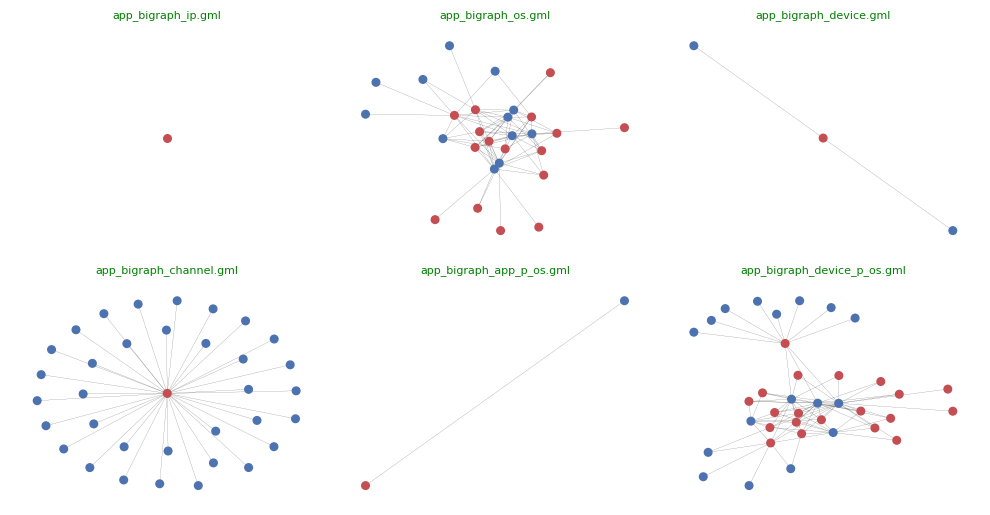

In [286]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 graphsPath,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

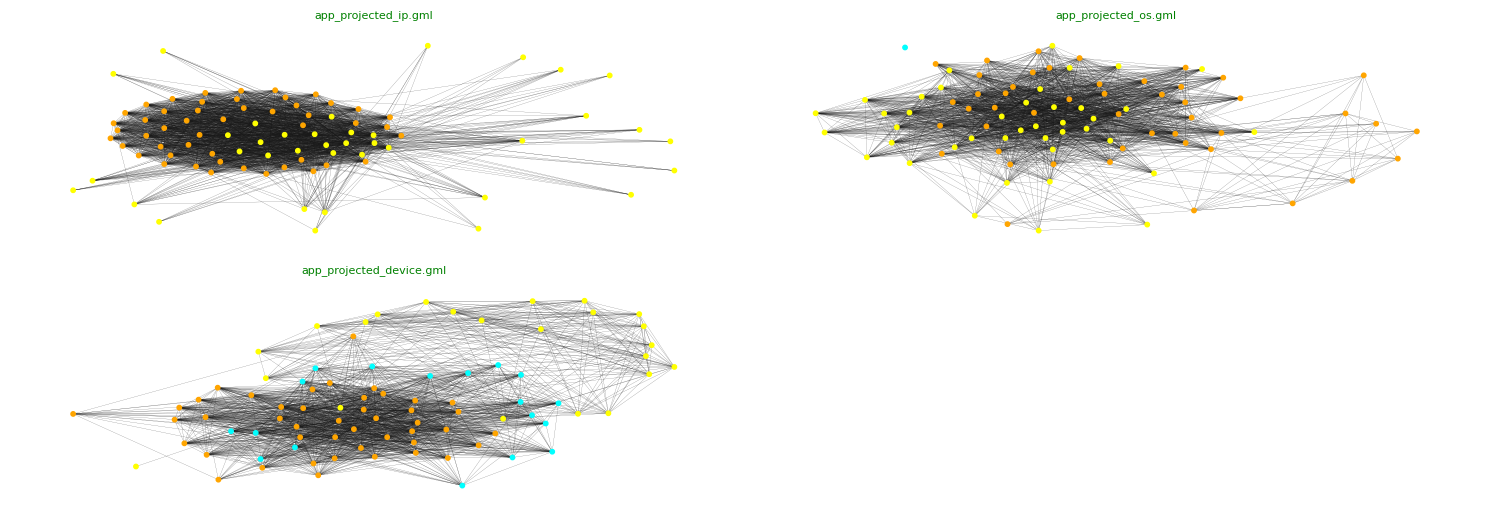

In [287]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   graphsPath,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [79]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (3000806, 12)/(3002043, 12)/(3001476, 12)/(2998791, 12)/(2998791, 12)
print("\n--\n")
fg_te[0].shape   # (1000269, 12)/(1000682, 12)/(1000493, 12)/(999597, 12)/(999597, 12)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(2998791, 12)


--



(999597, 12)


--



app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                         0                     1                          0   
1                         0                     1                          1   

   device_projected_app.gml  device_projected_os.gml  \
0                         2                        0   
1                         2                        0   

   device_projected_channel.gml  os_projected_app.gml  \
0                             0                     1   
1                             0                     1   

   os_projected_device.gml  os_projected_channel.gml  \
0                        0                         1   
1                        0                         1   

   channel_projected_app.gml  channel_projected_device.gml  \
0                          1                             1   
1                          1                             1   

   channel_projected_os.gml  
0                         2  
1                         1

app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                       0.0                   1.0                        0.0   
1                       0.0                   1.0                        0.0   

   device_projected_app.gml  device_projected_os.gml  \
0                       2.0                      0.0   
1                       2.0                      0.0   

   device_projected_channel.gml  os_projected_app.gml  \
0                           0.0                   1.0   
1                           0.0                   1.0   

   os_projected_device.gml  os_projected_channel.gml  \
0                      0.0                       0.0   
1                      0.0                       1.0   

   channel_projected_app.gml  channel_projected_device.gml  \
0                        2.0                           0.0   
1                        2.0                           1.0   

   channel_projected_os.gml  
0                       0.0  
1                       1.0

In [ ]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#graphFolder= Path("D:\\talkingdata\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,graphsPath,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,graphsPath,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)

In [213]:
# 24.1 Remove constant columns, if any, from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (3747190, 12)
Datashape after processing: (3747190, 12)


In [214]:
# 24.2 Save the list:

utils.savePythonObject(fg_tr, "fg_tr.pkl", talkingdatadata)
utils.savePythonObject(fg_te, "fg_te.pkl", talkingdatadata)

Object saved to: D:\talkingdata\allmodels\datafiles\fg_tr.pkl
Object saved to: D:\talkingdata\allmodels\datafiles\fg_te.pkl


In [215]:
# 24.3 Retrieve back:

tr_comm = utils.restorePythonObject( "fg_tr.pkl", talkingdatadata )
te_comm = utils.restorePythonObject( "fg_te.pkl", talkingdatadata )
tr_comm[0].shape  # (2249729, 12)/(3002043, 12)/(2998791, 12)/(3747190, 12)
te_comm[0].shape  # (749910, 12)/(1000682, 12)/(999597, 12)/(1249064, 12)

(3747190, 12)

(1249064, 12)

In [216]:
# 24.4 Check restoration:

tr_comm[0].head(2)
te_comm[0].head(2)

app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                         0                     0                          0   
1                         0                     0                          0   

   device_projected_app.gml  device_projected_os.gml  \
0                         2                        1   
1                         2                        1   

   device_projected_channel.gml  os_projected_app.gml  \
0                             1                     1   
1                             1                     1   

   os_projected_device.gml  os_projected_channel.gml  \
0                        0                         1   
1                        0                         1   

   channel_projected_app.gml  channel_projected_device.gml  \
0                          2                             0   
1                          0                             0   

   channel_projected_os.gml  
0                         0  
1                         0

app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                       0.0                   0.0                        0.0   
1                       0.0                   0.0                        0.0   

   device_projected_app.gml  device_projected_os.gml  \
0                       2.0                      1.0   
1                       2.0                      1.0   

   device_projected_channel.gml  os_projected_app.gml  \
0                           1.0                   1.0   
1                           1.0                   1.0   

   os_projected_device.gml  os_projected_channel.gml  \
0                      0.0                       1.0   
1                      0.0                       1.0   

   channel_projected_app.gml  channel_projected_device.gml  \
0                          2                             1   
1                          1                             0   

   channel_projected_os.gml  
0                         1  
1                         0

In [217]:
# 24.5 Merge rem cols in it:

tr_comm[0] = pd.concat([X_train[rem_cols], tr_comm[0] ],  axis = 1)
te_comm[0] = pd.concat([X_test[rem_cols], te_comm[0] ], axis = 1)

# 24.6 Shapes?
tr_comm[0].shape  # (3002043, 17)/(3001476, 17)/(2998791, 17)/(3747190, 17)
te_comm[0].shape  # (1000682, 17)/(1000493, 17)/(999597, 17)/(1249064, 17)

(3747190, 17)

(1249064, 17)

## xgboost modeling with data transformed through community classes

In [218]:
# 25.0 Modeling with transformed train/test data with community indicators:


# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 500,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 15,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   tr_comm[0]
test_X = te_comm[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[18:34:59] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:35:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.85978	validation_1-auc:0.85466
[18:35:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 738 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.86015	validation_1-auc:0.85513
[18:35:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 952 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.86045	validation_1-auc:0.85530
[18:35:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 788 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.86103	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve

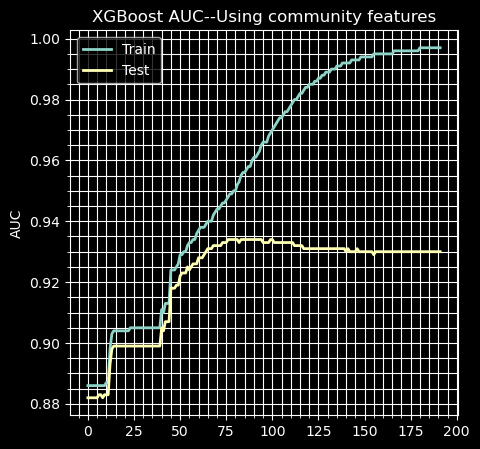

In [86]:
# 25.1 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid(visible = True, which = 'both')
plt.minorticks_on()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features");


In [220]:
# 25.2 Save model object
utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_trans_commu.pkl


In [221]:
# 25.3 Recall model object
model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", talkingdataestimators)

#### Classification report

In [222]:
# 25.4 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")





Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.56      0.08      0.14      3101

    accuracy                           1.00   1249064
   macro avg       0.78      0.54      0.57   1249064
weighted avg       1.00      1.00      1.00   1249064



In [ ]:
"""
Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    997845
           1       0.67      0.05      0.10      2424

    accuracy                           1.00   1000269
   macro avg       0.83      0.53      0.55   1000269
weighted avg       1.00      1.00      1.00   1000269


Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998259
           1       0.38      0.06      0.10      2423

    accuracy                           1.00   1000682
   macro avg       0.69      0.53      0.55   1000682
weighted avg       1.00      1.00      1.00   1000682

Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998061
           1       0.41      0.03      0.05      2432

    accuracy                           1.00   1000493
   macro avg       0.70      0.51      0.52   1000493
weighted avg       1.00      1.00      1.00   1000493

Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    997124
           1       0.63      0.18      0.28      2473

    accuracy                           1.00    999597
   macro avg       0.81      0.59      0.64    999597
weighted avg       1.00      1.00      1.00    999597



"""

### Horizontally concatenate to pca data rem cols

In [64]:
# 31 Now horizontally concatenate:

cctr_rem = pd.concat([X_train[rem_cols], cctr],  axis = 1)
ccte_rem = pd.concat([X_test[rem_cols], ccte], axis = 1)
                           
# 31.1 Check
cctr_rem.shape  # (3750000, 24)
ccte_rem.shape   # (1250000, 24)

(3750000, 24)

(1250000, 24)

In [67]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler

In [68]:
start = time.time()
renn = RepeatedEditedNearestNeighbours(max_iter = 3)
X_res, y_res = renn.fit_resample(cctr_rem, y_train)
end = time.time()
print((end-start)/60)  # 338 min

338.439654203256


In [70]:
## xgboost modeling of above concatenated data

# 31.2 Perform xgboost modeling using the above pca_train_trans/pca_test_trans data:

model_vec_imb_full = xgb.XGBClassifier( n_estimators= 250,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )


tr_X =    X_res
test_X =  ccte_rem
ytrain =  y_res
ytest = y_test


model_vec_imb_full.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )




[11:55:52] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[11:55:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.88818	validation_1-auc:0.89214
[11:55:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.88837	validation_1-auc:0.89185
[11:56:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.88838	validation_1-auc:0.89188
[11:56:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88870	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [71]:
# 31.3 Save model object:

utils.savePythonObject(model_vec_imb_full, "model_vec_imb_full.pkl", estimatorsPath)

Object saved to: D:\talkingdata\allmodels\estimators\model_vec_imb_full.pkl


In [72]:
# 31.4 Rstore model object:

model_vec_imb_full = utils.restorePythonObject("model_vec_imb_full.pkl", estimatorsPath)

In [73]:
# 31.5 Best scores with 'ip' and datetime related columns:

model_vec_imb_full.best_score   # 0.9658114/0.96369714/0.961902744/0.957092431030187
print("\n")
model_vec_imb_full.best_iteration  # 141/180/105/100/117

0.9669686227318209

198

In [74]:
# 31.6 Classification report with 'ip' and datetime related columns::

pred_vec_imb_full = model_vec_imb_full.predict(test_X)
uvec_cl_ip=classification_report(ytest,pred_vec_imb_full)
print(uvec_cl_ip)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.49      0.46      0.47      3133

    accuracy                           1.00   1250000
   macro avg       0.74      0.73      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



In [76]:
X_res.to_pickle(dataPath / "X_res.pkl")
y_res.to_pickle(dataPath / "y_res.pkl")

In [77]:
X_res = pd.read_pickle(dataPath / "X_res.pkl")
y_res = pd.read_pickle(dataPath / "y_res.pkl")

In [78]:
X_res.shape
y_res.shape

(3728994, 24)

(3728994,)

In [82]:
# 14.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.


# 14.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_res, y_res)
    # Make predictions
    y_pred = optuna_model.predict(ccte_rem)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 14.2 Create optuna study
study = optuna.create_study(direction='maximize')

# 14.3 Begin optimization
study.optimize(objective, n_trials=300)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)

[I 2023-08-26 12:53:25,909] A new study created in memory with name: no-name-91b5d6f4-75f2-4168-8473-59016fa9ae1f
[I 2023-08-26 12:54:11,018] Trial 0 finished with value: 0.2976164913034142 and parameters: {'max_depth': 2, 'learning_rate': 0.08240929501478278, 'n_estimators': 131, 'min_child_weight': 7, 'gamma': 1.0314078692423046e-06, 'subsample': 0.45606996025388985, 'colsample_bytree': 0.10707162810718072, 'reg_alpha': 0.0005609859570170992, 'reg_lambda': 0.2425426520387884}. Best is trial 0 with value: 0.2976164913034142.
[I 2023-08-26 12:57:50,961] Trial 1 finished with value: 0.37489516354486996 and parameters: {'max_depth': 3, 'learning_rate': 0.9500786665423141, 'n_estimators': 491, 'min_child_weight': 10, 'gamma': 2.3693327097140806e-08, 'subsample': 0.02495845255678369, 'colsample_bytree': 0.32027307386421133, 'reg_alpha': 0.0005148654629821815, 'reg_lambda': 0.001975480593164202}. Best is trial 1 with value: 0.37489516354486996.
[I 2023-08-26 13:05:18,481] Trial 2 finished w

In [83]:
# 14.4 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 14.4.1 Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 300


0.4838020062489722

    max_depth: 8
    learning_rate: 0.16887655923160663
    n_estimators: 179
    min_child_weight: 10
    gamma: 3.721967985245748e-06
    subsample: 0.87810990366264
    colsample_bytree: 0.36237609250493363
    reg_alpha: 0.3550481666158073
    reg_lambda: 3.1526354826366224e-08


In [87]:
# 15.0 Use these parameters in our estimator:
best_params = trial.params

model_vec_hyp = xgb.XGBClassifier(**best_params)
model_vec_hyp.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.36237609250493363, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.721967985245748e-06, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16887655923160663, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=179, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [97]:
best_params

{'max_depth': 8,
 'learning_rate': 0.16887655923160663,
 'n_estimators': 179,
 'min_child_weight': 10,
 'gamma': 3.721967985245748e-06,
 'subsample': 0.87810990366264,
 'colsample_bytree': 0.36237609250493363,
 'reg_alpha': 0.3550481666158073,
 'reg_lambda': 3.1526354826366224e-08}

In [88]:
# 15.1 Make predictions and assessments:

y_pred_hyp = model_vec_hyp.predict(ccte_rem)

print(classification_report(y_test, y_pred_hyp))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.50      0.47      0.48      3133

    accuracy                           1.00   1250000
   macro avg       0.75      0.73      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



In [134]:
gc.collect()

1449

In [135]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
params={
         'min_child_weight': Integer(0, 5),  # min no of instances needed to be in each node before split
         'max_depth': Integer(5, 10),         # Maximum depth of a tree.
         'subsample': Real (0.5, 1.0, 'uniform'),  # Subsample ratio of the training instances.
                                                   # Setting it to 0.5 means that XGBoost would
                                                   # randomly sample half of the training data prior
                                                   # to growing trees. and this will prevent overfitting.
         'colsample_bytree': Real(0.5, 1.0, 'uniform'), # subsample ratio of cols when constructing each tree
         'colsample_bylevel': Real(0.01, 1.0, 'uniform'), 
         'reg_lambda':Real(1e-7,100,prior = 'log-uniform'), # L2 reg term on weights. Increasing this value will make model more conservative
         'reg_alpha': Real(1e-7,100,prior= 'log-uniform'),  # L1 reg
         'gamma': Real(1e-9, 0.5, 'log-uniform'),   # Min loss reduction required to make a further partition
                                                    # on a leaf node of the tree. The larger gamma is, the
                                                    # more conservative the algorithm will be leading to simpler models.
         'learning_rate': Real(0.01,0.2,prior='log-uniform'), # How much weight should shrink after each step
                                                              # to make boosting process (NOT model) more conservative
         'scale_pos_weight': Real(1e-6, 5, 'log-uniform'),  # Control the balance of pos and neg weights, useful for unbalanced classes
         'n_estimators': Integer(100, 200)   # Max number of trees
        }




bayes_tuner=BayesSearchCV(
                            xgb.XGBClassifier(
                                            n_jobs = -1,
                                            objective = 'binary:logistic',
                                            eval_metric = 'auc',
                                            silent=1,
                                            tree_method='approx'
                                            ),
                            params,
                            n_iter=100,              # No of parameter settings that are tried
                            scoring='roc_auc',     # The criteria for best model. Maximise
                            optimizer_kwargs={     # Dict of arguments passed to Optimizer.
                                               'n_initial_points' : 5,  # Initial random pts before intelligence sets in
                                                                        #  default: 10
                                               'initial_point_generator':'random' # Random serach for init pts
                                              },
                            cv = StratifiedKFold(
                                                  n_splits=3,
                                                  shuffle=True,
                                                  random_state=42
                                                ),
                            refit = True, # Refit the best estimator
                                          #   so as to make predictions
                            verbose = 1,
                            return_train_score= True
                    )


In [127]:
# 10.2 This function is called after each parameter
#      fitting to print current status:

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # 10.2.1 Get all the models tested so far in DataFrame format
    # cv_results_: A dict with keys as column headers and
    #              values as columns
    #        model_results dataframe is not being printed
    #model_results = pd.DataFrame(bayes_tuner.cv_results_)

    # 10.2.2 Get current parameters and the best parameters
    # best_params_: A dict of parameter settings that
    #               give the best results on the hold out data.
    #best_params = pd.Series(bayes_tuner.best_params_)
    #best_score = pd.Series(bayes_tuner.best_score_)

    print(bayes_tuner.optimizer_results_),  # Score of best_estimator on the left out data.
   


In [136]:
start = time.time()
res=bayes_tuner.fit(
                      X_res,
                      y_res,
                      #callback=status_print
                    )

end = time.time()

f"{(end - start)/60} minutes "    # 3 minutes on Colab

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[13:20:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:21:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:22:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[13:23:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:24:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:25:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Fitting 3 folds for each of 1 candidates, 

'434.6909828146299 minutes '

In [138]:
res.best_score_
res.best_params_


0.9644859140745381

OrderedDict([('colsample_bylevel', 1.0),
             ('colsample_bytree', 0.5),
             ('gamma', 0.022491709004137623),
             ('learning_rate', 0.08180649119681357),
             ('max_depth', 10),
             ('min_child_weight', 5),
             ('n_estimators', 158),
             ('reg_alpha', 1e-07),
             ('reg_lambda', 1e-07),
             ('scale_pos_weight', 0.5426159562647138),
             ('subsample', 1.0)])

In [139]:
# 15.1 Make predictions and assessments:

y_pred_bayes = res.predict(ccte_rem)

print(classification_report(y_test, y_pred_bayes))
roc_score = roc_auc_score(y_test, y_pred_bayes)
print(roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.61      0.37      0.46      3133

    accuracy                           1.00   1250000
   macro avg       0.80      0.68      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000

0.684828130468466


In [106]:
# 14.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise roc_score.


# 14.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 10, 13),
               'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 2, 5),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
              'n_estimators': trial.suggest_int('n_estimators', 120, 250),
              'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
              'gamma': trial.suggest_loguniform('gamma', 0.01, 0.05),
              'subsample': trial.suggest_loguniform('subsample', 0.6, 0.9),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.6, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 0.0005),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1e-6),
              'eval_metric': 'auc',
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_res, y_res)
    # Make predictions
    y_pred = optuna_model.predict(ccte_rem)

    # Evaluate predictions
    roc_score = roc_auc_score(y_test, y_pred)
    # Maximise roc_score
    return roc_score



# 14.2 Create optuna study
study1 = optuna.create_study(direction='maximize')

# 14.3 Begin optimization
study1.optimize(objective, n_trials=500)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)

[I 2023-08-28 09:39:17,687] A new study created in memory with name: no-name-8aa9df82-5e6c-4842-bb73-4880c1bb2e63
[I 2023-08-28 09:48:08,203] Trial 0 finished with value: 0.8151136380391064 and parameters: {'max_depth': 12, 'scale_pos_weight': 5, 'learning_rate': 0.09621274932274435, 'n_estimators': 165, 'min_child_weight': 3, 'gamma': 0.02886651338157224, 'subsample': 0.6203329907966985, 'colsample_bytree': 0.9702218632346636, 'reg_alpha': 0.00037783920798787154, 'reg_lambda': 7.424566109366558e-07}. Best is trial 0 with value: 0.8151136380391064.
[I 2023-08-28 09:56:39,607] Trial 1 finished with value: 0.7809554716969104 and parameters: {'max_depth': 13, 'scale_pos_weight': 3, 'learning_rate': 0.05765226790079576, 'n_estimators': 169, 'min_child_weight': 0, 'gamma': 0.014313998203931005, 'subsample': 0.7278363320268239, 'colsample_bytree': 0.8110003930409877, 'reg_alpha': 0.00015725750716912135, 'reg_lambda': 2.3594802341317454e-07}. Best is trial 0 with value: 0.8151136380391064.
[I

KeyboardInterrupt: 

In [102]:
Best_Params = {'colsample_bylevel': 0.955923206446829,
               'colsample_bytree': 0.7036152301751524,
               'gamma': 0.03823613443879595,
               'learning_rate': 0.06786442521779147,
               'max_delta_step': 8,
               'max_depth': 11,
               'min_child_weight': 0,
               'n_estimators': 169,
               'reg_alpha': 0.00022356829889037284,
               'reg_lambda': 1.2908532337409298e-07,
               'scale_pos_weight': 4.73588486119117,
               'subsample': 0.4499578015509351}



model_kaggle = xgb.XGBClassifier(**Best_Params,verbose = 3)
model_kaggle.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.955923206446829, colsample_bynode=None,
              colsample_bytree=0.7036152301751524, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.03823613443879595, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06786442521779147, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=8,
              max_depth=11, max_leaves=None, min_child_weight=0, missing=nan,
              monotone_constraints=None, n_estimators=169, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [103]:
# 15.1 Make predictions and assessments:

y_pred_kaggle = model_kaggle.predict(ccte_rem)

print(classification_report(y_test, y_pred_kaggle))
roc_score = roc_auc_score(y_test, y_pred_kaggle)
print(roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.37      0.63      0.47      3133

    accuracy                           1.00   1250000
   macro avg       0.69      0.81      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000

0.8145053476364472


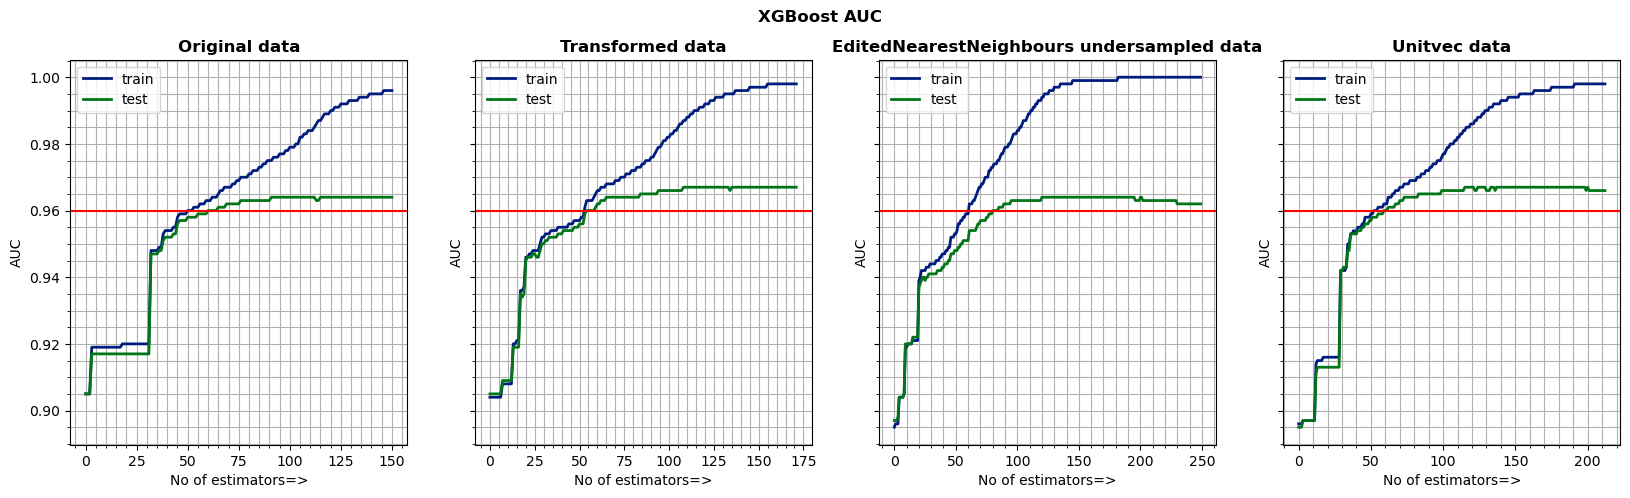

In [26]:
# 30.3 Learning curve

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);

results = [model_orig.evals_result(),model_trans.evals_result(), model_en.evals_result(), model_vec_full.evals_result() ]
title = ["Original data", 'Transformed data', 'EditedNearestNeighbours undersampled data', 'Unitvec data']
fig.suptitle("XGBoost AUC", fontweight = "bold")

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();




In [ ]:
##*****************************
## Embedding Projector

##*****************************

In [260]:
# 33
# 33.1 Get target data col. Needed for generation of meta-data file:


train_trans['target'] =  y_train

vec_tr_mean,_ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = talkingdataunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avged"     
                           )



Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for os
Checked for channel
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\talkingdata\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


## Feature Engineering through clustering

In [261]:
# 34.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 12,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12


In [262]:
# 34.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0  3.671103 -0.865406 -3.050680  0.368654  -0.398636   0.787238  -0.200491   
1 -0.507002  5.354653  1.565948 -1.754986  -0.407465   0.640545   0.203725   
2 -1.717272  0.717173 -0.062780  2.593551  -0.407952   0.641808   0.018090   

   pcdevice3     pcos0     pcos1     pcos2     pcos3  pcchannel0  pcchannel1  \
0   0.136411 -1.280446  0.294047 -1.937024  0.671268   -0.435268   -4.143646   
1  -0.024267 -1.244083  0.230523 -1.406424  0.218394    4.800220   -3.767235   
2  -0.353882 -1.279417  0.218141 -1.871620  0.501109   -0.497745   -0.122144   

   pcchannel2  pcchannel3  clu0  clu1  clu2  clu3  
0    0.843768    1.534261     5     0     1     5  
1   -0.564055    1.484366     6     0     1     9  
2   -1.385875    0.130813     8     0     1     2

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -0.808483 -1.538319 -0.429401 -0.367411   0.147834 -11.889017   2.163232   
1 -1.543873 -3.447913  1.313072  2.381807  -0.407763   0.641912  -0.019017   
2 -3.865766 -0.401923  1.810693 -2.645520  -0.407763   0.641912  -0.019017   

   pcdevice3     pcos0     pcos1     pcos2     pcos3  pcchannel0  pcchannel1  \
0   0.132562 -1.244024  0.229337 -1.415404  0.202054   -2.829218    1.087118   
1  -0.014087 -1.244024  0.229337 -1.415404  0.202054   -0.588555   -1.348168   
2  -0.014087  0.438189 -0.555378  1.507220 -0.226979   -3.164828    0.564920   

   pcchannel2  pcchannel3  clu0  clu1  clu2  clu3  
0    0.843500   -1.472553    10     2     1     3  
1   -0.291152   -0.288995     4     0     1     2  
2   -1.335926   -1.086098     3     0     0     0

In [263]:
# 34.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()

clu0  clu1  clu2  clu3
0     5     0     1     5
1     6     0     1     9
2     8     0     1     2
3    11     2    10     2
4     2     0     1    10

clu0  clu1  clu2  clu3
0    10     2     1     3
1     4     0     1     2
2     3     0     0     0
3    11     0     9     0
4     2     0     7     2

In [264]:
# 34.3
model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[09:33:23] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:33:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.77322	validation_1-auc:0.77211
[09:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.77322	validation_1-auc:0.77212
[09:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.77326	validation_1-auc:0.77214
[09:33:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.77327	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [268]:
# 34.4 Save model object:

utils.savePythonObject(model_fe, "model_fe.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_fe.pkl


In [269]:
# 34.5 Restore model object:

model_fe = utils.restorePythonObject("model_fe.pkl", talkingdataestimators)

In [270]:
# 34.6


model_fe.best_score  # 0.938681430882942

0.9386814308829429

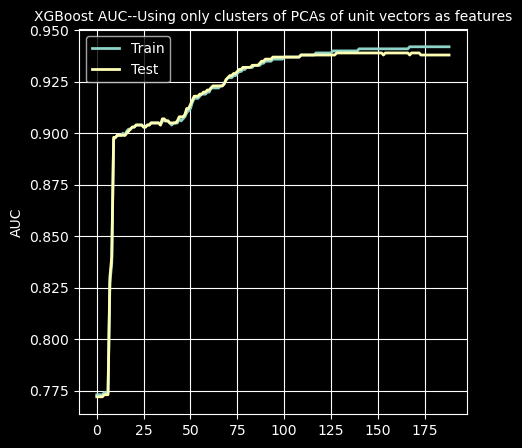

In [266]:
# 34.7 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

     

In [ ]:
###################Done##################

In [ ]:
#### ROUGH WORK ##########
#### ROUGH WORK ##########

In [267]:
gc.collect()

4284

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [66]:
r1= cctr.astype(np.float16)
pca_train_unit, _, y_train_unit, _ = train_test_split(r1,y_train, train_size = 30000, stratify = y_train)

In [67]:
pca_train_unit.shape  # (20000, 16)
y_train_unit.shape   # (20000, )
y_train_unit.sum()   # 49
pca_train_unit.dtypes

(30000, 16)

(30000,)

73

pcapp0        float16
pcapp1        float16
pcapp2        float16
pcapp3        float16
pcdevice0     float16
pcdevice1     float16
pcdevice2     float16
pcdevice3     float16
pcos0         float16
pcos1         float16
pcos2         float16
pcos3         float16
pcchannel0    float16
pcchannel1    float16
pcchannel2    float16
pcchannel3    float16
dtype: object

In [68]:
ex1 = pca_train_unit.iloc[:, 0:4]
ex2 = pca_train_unit.iloc[:,4:8]
ex3 = pca_train_unit.iloc[:,8:12]
ex4 = pca_train_unit.iloc[:,12:16]
gc.collect()

72

In [69]:
gc.collect()

0

In [70]:
x1 = cosine_similarity(ex1)
x2 = cosine_similarity(ex2)
x3 = cosine_similarity(ex3)
x4 = cosine_similarity(ex4)

In [71]:
x1.shape
x2.shape
x3.shape
x4.shape

(30000, 30000)

(30000, 30000)

(30000, 30000)

(30000, 30000)

In [72]:
kmeans1 = KMeans(n_clusters = 20)
kmeans2 = KMeans(n_clusters = 20)
kmeans3 = KMeans(n_clusters = 20)
kmeans4 = KMeans(n_clusters = 20)


In [73]:
kx1 = kmeans1.fit_transform(x1)
print("d1")
gc.collect()
kx2 = kmeans2.fit_transform(x2)
print("d2")
kx3 = kmeans3.fit_transform(x3)
print("d3")
kx4 = kmeans4.fit_transform(x4)
print("d4")
gc.collect()

d1


183

d2
d3
d4


150

In [74]:
gc.collect()

0

In [11]:
# 26.1 A quick readback all saved files

train_trans = pd.read_pickle(Path(talkingdatadata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(talkingdatadata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(talkingdatadata) / "X_train.pkl")
X_test = pd.read_pickle(Path(talkingdatadata) / "X_test.pkl")
y_train = pd.read_pickle(Path(talkingdatadata) / "y_train.pkl")
y_test = pd.read_pickle(Path(talkingdatadata) / "y_test.pkl")


# 26.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 26.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 26.2.3
train_trans.shape   # (3000806, 136)/(3002043, 136)/(3001476, 136)
y_train.shape       # (3000806, )/(3002043, )/(3001476, )
test_trans.shape    # (1000269, 136)/(1000682, 136)/(1000493, 136)
y_test.shape        # (1000269, )/(1000682, )/(1000493, )


# 26.2.4 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel']  # 4cols

# 26.2.5 Remaining cols not treated as cat cols:
rem_cols = {'ip', 'minute', 'day', 'hour', 'second'} # 5 cols


# 26.3 Concat rem_cols with transformed data:

# 26.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 26.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 26.6 Check
X_train_trans.shape  # (3000806, 137)/(3002043, 137)/(3001476, 137)
X_test_trans.shape   # (3000806, )/(1000682, 137)/(1000493, 137)



app  device  os  channel  deg_app_ck_device  eig_app_ck_device  \
0   13       1  13      477           0.809917           0.076224   
1   22       1  19      116           0.779614           0.074330   

   pr_app_ck_device  clu_app_ck_device  bet_app_ck_device  deg_app_ck_os  ...  \
0          0.003801           0.697174           0.002960       0.834711  ...   
1          0.003666           0.717791           0.002223       0.834711  ...   

   deg_channel_ck_device_p_os  eig_channel_ck_device_p_os  \
0                    0.971591                    0.077525   
1                    0.960227                    0.077257   

   pr_channel_ck_device_p_os  clu_channel_ck_device_p_os  \
0                   0.005920                    0.970210   
1                   0.005838                    0.986616   

   bet_channel_ck_device_p_os  deg_channel_ck_app_p_os  \
0                    0.000757                 0.164773   
1                    0.000093                 0.005682   

   eig_channel_ck_app_p_os  pr_channel_ck_app_p_os  clu_channel_ck_app_p_os  \
0             3.902822e-02                0.004952                 0.633005   
1             2.230271e-17                0.004544                 0.000000   

   bet_channel_ck_app_p_os  
0                 0.004242  
1                 0.000000  

[2 rows x 136 columns]

app  device  os  channel  deg_app_ck_device  eig_app_ck_device  \
0    3       2  19      280           0.809917           0.076224   
1   15       1  19      245           0.768595           0.073619   

   pr_app_ck_device  clu_app_ck_device  bet_app_ck_device  deg_app_ck_os  ...  \
0          0.003801           0.697174           0.002960       0.837466  ...   
1          0.003617           0.724014           0.002355       0.834711  ...   

   deg_channel_ck_device_p_os  eig_channel_ck_device_p_os  \
0                    0.977273                    0.077637   
1                    0.965909                    0.077355   

   pr_channel_ck_device_p_os  clu_channel_ck_device_p_os  \
0                   0.005963                    0.961648   
1                   0.005884                    0.977445   

   bet_channel_ck_device_p_os  deg_channel_ck_app_p_os  \
0                    0.000865                 0.397727   
1                    0.000694                 0.289773   

   eig_channel_ck_app_p_os  pr_channel_ck_app_p_os  clu_channel_ck_app_p_os  \
0                 0.121408                0.009006                 0.604141   
1                 0.074779                0.006935                 0.657255   

   bet_channel_ck_app_p_os  
0                 0.008494  
1                 0.003071  

[2 rows x 136 columns]

ip  app  device  os  channel  day  hour  minute  second
0  128686   13       1  13      477    7     4       8      30
1   55146   22       1  19      116    9    12      30       0

ip  app  device  os  channel  day  hour  minute  second
0  44961    3       2  19      280    7     1      42       4
1  62900   15       1  19      245    8    20      18      33

(3747190, 136)

(3747190,)

(1249064, 136)

(1249064,)

(3747190, 137)

(1249064, 137)

In [76]:
 kmeans1.labels_

array([ 5,  6, 14, ..., 13,  4,  0])

In [77]:
pca_train_unit["k1"] = kmeans1.labels_
pca_train_unit["k2"] = kmeans2.labels_
pca_train_unit["k3"] = kmeans3.labels_
pca_train_unit["k4"] = kmeans4.labels_


In [78]:
pca_train_unit.shape

(30000, 20)

In [110]:
tr, te, ytr,yte = train_test_split(pca_train_unit,y_train_unit, test_size = 0.25, stratify = y_train_unit)

In [113]:
## xgboost modeling of above concatenated data

# 31.2 Perform xgboost modeling using the above pca_train_trans/pca_test_trans data:
del mkm
mkm = xgb.XGBClassifier( n_estimators= 100,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 11,
                              #subsample = 0.8,
                              random_state = rng,
                             
                           )

## NOTE THIS IS WITH 'ip' and other numeric columns
tr_X =    tr.iloc[:,-4:]
test_X =  te.iloc[:,-4:]
ytrain =  ytr
ytest = yte


mkm.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )




[13:21:54] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.56304	validation_1-auc:0.4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [112]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_te = mkm.predict(test_X)
stp=classification_report(yte,pred_te)
print(stp)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7482
           1       0.00      0.00      0.00        18

    accuracy                           1.00      7500
   macro avg       0.50      0.50      0.50      7500
weighted avg       1.00      1.00      1.00      7500



In [105]:
## Rough
gc.collect()

22244

In [41]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler, NearMiss,OneSidedSelection

In [13]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler
start = time.time()
renn = RepeatedEditedNearestNeighbours(max_iter = 3)
X_res, y_res = renn.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 348 min


347.540420905749


In [14]:
X_res.shape  # (3734643, 25)

(3734643, 25)

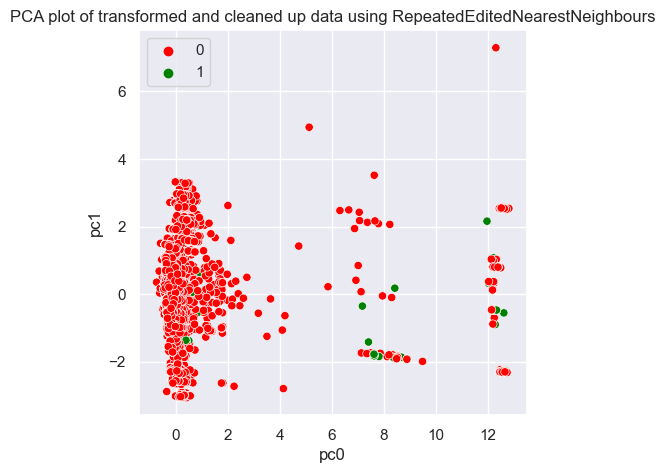

In [17]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 50000, stratify = y_res)
#pca_tr= X_res # (50000, 26)
#pca_y= y_res   # (5000,)

pca_tr.shape


fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using RepeatedEditedNearestNeighbours') ;

In [16]:
gc.collect()

301

In [18]:
# 19.0 Modeling with smoteenn data (without ip and rem features)

model_ren = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 12,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_ren.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 50,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[15:23:56] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:24:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.89171	validation_1-auc:0.88313
[15:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 852 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.89457	validation_1-auc:0.88615
[15:24:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 868 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.89564	validation_1-auc:0.88692
[15:24:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 862 extra nodes, 0 pruned nodes, max_depth=12
[3]	validation_0-auc:0.89602	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [20]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_ren = model_ren.predict(test_X)
stp=classification_report(y_test,pred_ren)
print(stp)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1247914
           1       0.48      0.59      0.53      3116

    accuracy                           1.00   1251030
   macro avg       0.74      0.79      0.76   1251030
weighted avg       1.00      1.00      1.00   1251030



In [42]:
rus = OneSidedSelection()

X_res, y_res = rus.fit_resample(pca_train, y_train)

In [43]:
X_res.shape  # (3740358, 25)

(3740358, 25)

In [44]:
# 19.0 Modeling with smoteenn data (without ip and rem features)

model_rus = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 12,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_rus.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 50,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[05:28:01] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:28:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1190 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.89133	validation_1-auc:0.88401
[05:28:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1080 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.89186	validation_1-auc:0.88459
[05:28:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1120 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.89220	validation_1-auc:0.88460
[05:28:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1126 extra nodes, 0 pruned nodes, max_depth=12
[3]	validation_0-auc:0.89498	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [45]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_rus = model_rus.predict(test_X)
cl_rus=classification_report(y_test,pred_rus)
print(cl_rus)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1247914
           1       0.68      0.40      0.51      3116

    accuracy                           1.00   1251030
   macro avg       0.84      0.70      0.75   1251030
weighted avg       1.00      1.00      1.00   1251030

